In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_sim_b1_e25_v0.pth'

16908615680
0
0


In [2]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

parent_path =  path.home + "/Pictures/" + "Data/"

root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [4]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
#         A.Resize(640, 480)  # Resize all images to be 640x480
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [5]:
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        shutil.copy(jsonfile, dst_dir_anno)
        
    output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output  
    

In [6]:
class KPDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_file = self.imgs_files[idx]
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are keypoints on the robot
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_joint')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')
            bboxes_labels_original.append('joint6')  

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
#                 print("object", obj)
#                 print(" obj index", o_idx)# Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        labels = [1, 2, 3, 4, 5, 6]            
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original, img_file
        else:
            return img, target, img_file
    
    def __len__(self):
        return len(self.imgs_files)

In [7]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 7, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import networkx as nx


class GNNEncoder(nn.Module):
    def __init__(self, vertices_dim=4, hidden_dim=128, num_vertices=6):
        super(GNNEncoder, self).__init__()
        self.f_enc = nn.Linear(vertices_dim, hidden_dim)
        self.f_e1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.f_v = nn.Linear(hidden_dim, hidden_dim)
        self.f_e2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.num_vertices = num_vertices
        
    def generate_edges(self, vertices):
        vertices_list = vertices.tolist()
        G = nx.Graph()
        for idx, vertex in enumerate(vertices_list):
            G.add_node(idx, x=vertex[0], y=vertex[1], t=vertex[2])  
            if idx < len(vertices_list) - 1:
                G.add_edge(idx, idx + 1)
        # Add the edge between the last and the first vertex to form a cycle
        G.add_edge(len(vertices_list) - 1, 0)
        edges = torch.tensor(list(G.edges), dtype=torch.long).to(vertices.device)
        return edges

#     def generate_edges(self, vertices):
#         vertices_list = vertices.tolist()
#         G = nx.Graph()
#         for idx, vertex in enumerate(vertices_list):
#             G.add_node(idx, x=vertex[0], y=vertex[1], t=vertex[2])  
#             if idx < len(vertices_list) - 1:
#                 G.add_edge(idx, idx + 1)
#         edges = torch.tensor(list(G.edges), dtype=torch.long).to(vertices.device)
#         return edges
    
#     def generate_edges(self, vertices):
#         num_vertices = vertices.shape[0]
#         all_edges = [[i, j] for i in range(num_vertices) for j in range(i+1, num_vertices)]
#         edges = torch.tensor(all_edges, dtype=torch.long).to(vertices.device)
#         return edges

    def forward(self, vertices):
        h1 = self.f_enc(vertices)
        edges = self.generate_edges(vertices)
#         print(edges)
        h1_source = h1[edges[:, 0]]
        h1_target = h1[edges[:, 1]]
        h_e1 = self.f_e1(torch.cat((h1_source, h1_target), dim=1))
        h_j_2 = self.f_v(h_e1)
        h2_source = h_j_2[edges[:, 0]]
        h2_target = h_j_2[edges[:, 1]]
        h_e2 = self.f_e2(torch.cat((h2_source, h2_target), dim=1))
        h_e2_prob = torch.sigmoid(h_e2)
        return vertices, h_e2_prob, edges

class GNNDecoder(nn.Module):
    def __init__(self, vertices_dim=4, hidden_dim=128, num_vertices=6):
        super(GNNDecoder, self).__init__()
        self.f_e = nn.Linear(vertices_dim * 2, hidden_dim)  # Concatenate two vertices features
        self.f_h = nn.Linear(hidden_dim, vertices_dim)  # Transform h_ij to the same dimension as vertices
        self.f_v = nn.Linear(vertices_dim, vertices_dim)  # Update vertex feature

    def forward(self, vertices, h_e2_prob, edges):
        h_source = vertices[edges[:, 0]]
        h_target = vertices[edges[:, 1]]
        h = torch.zeros_like(vertices)

        for idx, (i, j) in enumerate(edges):  # Iterate over edges
            h_ij = h_e2_prob[idx] * self.f_e(torch.cat((h_source[idx], h_target[idx]), dim=0))  # Apply edge function
            h_ij_transformed = self.f_h(h_ij)  # Transform h_ij to the same dimension as vertices
            h[j] += h_ij_transformed  # Accumulate edge features to the target vertex

        h_transformed = self.f_v(h.view(-1, vertices.shape[1]))  # Transform h
        h_transformed = h_transformed.view(vertices.shape)  # Reshape back to original shape
        vertices_g = vertices + h_transformed  # Update vertex features

        return vertices_g  # Return vertices_g as the prediction and vertices_g itself as the mean for Gaussian distribution



In [9]:
class TrifocalLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, vertices_pred, vertices_gt):
        # Only consider the first two dimensions
        vertices_pred = vertices_pred[:, :3]
        vertices_gt = vertices_gt.squeeze()[:, :3]  # Use squeeze() to remove the singular dimension

        loss = (vertices_gt - torch.tensor(vertices_pred)).pow(2).mean()  # Changed from sum() to mean()
        return loss
    
# def cross_entropy_loss_func(edges_prob, edges_gt):
#     edges_gt_expanded = edges_gt.unsqueeze(-1).float()
#     loss_func = nn.BCEWithLogitsLoss()
#     loss = loss_func(edges_prob, edges_gt_expanded)
#     return loss

def edge_loss(edges_prob, edges_gt):
    # Expand edges_gt to match the shape of edges_prob
#     print(edges_prob.shape)
    edges_gt_expanded = torch.zeros(edges_prob.shape, dtype=torch.float32)
    
    for i in range(edges_gt.shape[0]):
        u, v = edges_gt[i]
#         print("u:", u)
#         print("v:", v)
#         print("edges_gt_expanded.shape:", edges_gt_expanded.shape)
        if i < edges_gt_expanded.shape[0]:
            if u < edges_gt_expanded.shape[1]:
                edges_gt_expanded[i, u] = 1
            if v < edges_gt_expanded.shape[1]:
                edges_gt_expanded[i, v] = 1
#         print('new u', u)
#         print('new v', v)
    # Compute the cross-entropy loss
    loss = -torch.sum(edges_gt_expanded.to(device) * torch.log(torch.clamp(edges_prob, min=1e-7)))
                      
    return loss



In [10]:
# class KeypointPipeline(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.keypoint_model = torch.load(weights_path).to(device)
#         self.keypoint_model.eval()  # Set the model to evaluation mode
#         self.keypoint_model = self.keypoint_model.to(device)
#         self.gnn_encoder = GNNEncoder()
#         self.gnn_decoder = GNNDecoder()
        
#     def forward(self, imgs):
#         outputs = []
#         for i in range(imgs.shape[0]):
#             img = imgs[i].unsqueeze(0).to(device)  # Unsqueeze the 0th dimension to make a batch of size 1
#             # Temporarily set the keypoint model to evaluation mode
#             keypoint_model_training = self.keypoint_model.training  # Save the current mode
#             self.keypoint_model.eval()
#             with torch.no_grad():
#                 output = self.keypoint_model(img)  # Keypoint model expects a list of images
                
#             # Set the keypoint model back to its previous mode
#             self.keypoint_model.train(keypoint_model_training)
                
#             img = (img[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
#             scores = output[0]['scores'].detach().cpu().numpy()
#             high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
#             post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], \
#                 output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

#             keypoints = []
#             key_points = []
#             for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#                 keypoints.append(list(map(int, kps[0,0:2])))
#                 key_points.append([list(map(int, kp[:2])) for kp in kps])

# #             print("keypoints", keypoints)

#             labels = []
#             for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#                 labels.append(label)
#     #             labels.append('j' + str(int(label)))
    
#             print("keypoints", keypoints)

# #             print("labels", labels)

# #             keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
#     #         kp_label = [list(x) + [y] for (x, y) in sorted(zip(keypoints, labels))]

#             # Create a dictionary where the key is the label and the value is the keypoint
#             label_keypoint_dict = {lbl: kp for kp, lbl in zip(keypoints, labels)}

#             # Convert the dictionary back to a list and sort it by the label keys
#             labeled_keypoints = [value + [key] for key, value in sorted(label_keypoint_dict.items())] #,key=lambda item: int(item[0][1:]))]

# #             print("keypoints_", keypoints_)
#             print("kp_label", labeled_keypoints)
# # 
#             keypoints = torch.stack([torch.tensor(kp) for kp in labeled_keypoints]).float().to(device)
#             vertices, enc_e, edges = self.gnn_encoder(keypoints)
#             updated_vertices = self.gnn_decoder(vertices, enc_e, edges)
#             outputs.append((updated_vertices, enc_e, edges))

#         return outputs  # A list of tuples, each containing updated_vertices, enc_e, edges for an image in the batch



In [11]:
class KeypointPipeline(nn.Module):
    def __init__(self, weights_path):
        super().__init__()

        self.keypoint_model = torch.load(weights_path).to(device)
        self.gnn_encoder = GNNEncoder()
        self.gnn_decoder = GNNDecoder()

    def process_model_output(self, output):
        scores = output[0]['scores'].detach().cpu().numpy()
        high_scores_idxs = np.where(scores > 0.7)[0].tolist()

        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], 
                                            output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy()
        
        confidence = output[0]['scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
        labels = output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
        keypoints = []
        for idx, kps in enumerate(output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()):
            keypoints.append(list(map(int, kps[0,0:2])) + [confidence[idx]] + [labels[idx]])

        # Create a dictionary where the key is the label and the value is the keypoint
        label_to_keypoint = {}
        for keypoint in keypoints:
            label = keypoint[-1]
            if label not in label_to_keypoint or label_to_keypoint[label][-2] < keypoint[-2]:
                label_to_keypoint[label] = keypoint

        # Convert the dictionary values back into a list
        keypoints = list(label_to_keypoint.values())
            
        print(keypoints)

#         keypoints = []
#         for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             keypoints.append(list(map(int, kps[0,0:2])))

#         labels = []
#         for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             labels.append(label)

#         label_keypoint_dict = {lbl: kp for kp, lbl in zip(keypoints, labels)}
#         labeled_keypoints = [value + [key] for key, value in sorted(label_keypoint_dict.items())]

        return keypoints

    def process_image(self, img):
        img = img.unsqueeze(0).to(device)
        # Temporarily set the keypoint model to evaluation mode
        keypoint_model_training = self.keypoint_model.training  # Save the current mode
        self.keypoint_model.eval()
        with torch.no_grad():
            output = self.keypoint_model(img)
        # Set the keypoint model back to its previous mode
        self.keypoint_model.train(keypoint_model_training)
        img = (img[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        labeled_keypoints = self.process_model_output(output)

        return labeled_keypoints

    def forward(self, imgs):
        outputs = []

        for i in range(imgs.shape[0]):
            labeled_keypoints = self.process_image(imgs[i])
            keypoints = torch.stack([torch.tensor(kp) for kp in labeled_keypoints]).float().to(device)

            vertices, enc_e, edges = self.gnn_encoder(keypoints)
            updated_vertices = self.gnn_decoder(vertices, enc_e, edges)
            outputs.append((updated_vertices, enc_e, edges))

        return outputs

In [12]:
# class KeypointPipeline(nn.Module):
#     def __init__(self, num_keypoints, weights_path=None):
#         super().__init__()

#         # Instantiate your Keypoint R-CNN model
#         self.keypoint_model = get_model(num_keypoints, weights_path)
#         self.keypoint_model.to(device)

#         self.gnn_encoder = GNNEncoder()
#         self.gnn_decoder = GNNDecoder()

#     def process_model_output(self, output):
#         scores = output[0]['scores'].detach().cpu().numpy()
#         high_scores_idxs = np.where(scores > 0.7)[0].tolist()

#         post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], 
#                                             output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy()

#         keypoints = []
#         for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             keypoints.append(list(map(int, kps[0,0:2])))

#         labels = []
#         for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             labels.append(label)

#         label_keypoint_dict = {lbl: kp for kp, lbl in zip(keypoints, labels)}
#         labeled_keypoints = [value + [key] for key, value in sorted(label_keypoint_dict.items())]

#         return labeled_keypoints

#     def process_image(self, img):
#         img = img.unsqueeze(0).to(device)
#         # Temporarily set the keypoint model to evaluation mode
#         keypoint_model_training = self.keypoint_model.training  # Save the current mode
#         self.keypoint_model.eval()
#         with torch.no_grad():
#             output = self.keypoint_model(img)
#         print("Output", output)
#         # Set the keypoint model back to its previous mode
#         self.keypoint_model.train(keypoint_model_training)
#         img = (img[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
#         labeled_keypoints = self.process_model_output(output)

#         return labeled_keypoints

#     def forward(self, imgs):
#         outputs = []

#         for i in range(imgs.shape[0]):
#             labeled_keypoints = self.process_image(imgs[i])
#             keypoints = torch.stack([torch.tensor(kp) for kp in labeled_keypoints]).float().to(device)

#             vertices, enc_e, edges = self.gnn_encoder(keypoints)
#             updated_vertices = self.gnn_decoder(vertices, enc_e, edges)
#             outputs.append((updated_vertices, enc_e, edges))

#         return outputs

Copying files: 2662 files [00:00, 19616.42 files/s]
Copying files: 2662 files [00:00, 20089.56 files/s]
Copying files: 2662 files [00:00, 20480.62 files/s]


Processing images: ('001142.rgb.jpg', '000404.rgb.jpg', '000475.rgb.jpg', '000755.rgb.jpg')


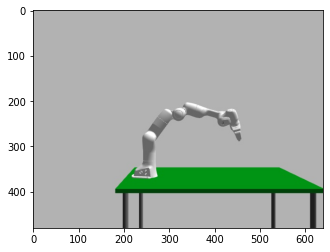

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.4676, 219.1452,   1.0000]],

        [[322.1326, 231.5281,   1.0000]],

        [[420.3123, 244.3029,   1.0000]],

        [[442.5062, 239.5785,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3239, 234.9908,   1.0000]],

        [[206.8498, 218.3908,   1.0000]],

        [[187.8360, 120.9061,   1.0000]],

        [[191.1685,  99.1303,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3309, 234.9725,   1.0000]],

        [[206.8581, 218.3746,   1.0000]],

        [[305.1776, 230.7765,   1.0000]],

        [[325.0677, 240.5120,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.1448, 203.4121,   1.0000]],

        [[277.9152, 203.18

/tmp/ipykernel_5742/2195908879.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = (vertices_gt - torch.tensor(vertices_pred)).pow(2).mean()  # Changed from sum() to mean()


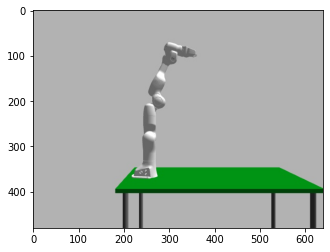

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.5139, 203.4109,   1.0000]],

        [[279.2843, 203.5444,   1.0000]],

        [[305.9368, 108.2229,   1.0000]],

        [[311.5217,  86.2966,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.1830, 203.4091,   1.0000]],

        [[278.9541, 203.4565,   1.0000]],

        [[349.7361, 134.2046,   1.0000]],

        [[362.5719, 115.4656,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.0532, 203.4131,   1.0000]],

        [[277.8234, 203.1660,   1.0000]],

        [[363.2708, 253.1706,   1.0000]],

        [[375.4557, 271.3641,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6525, 218.1693,   1.0000]],

        [[228.5736, 206.08

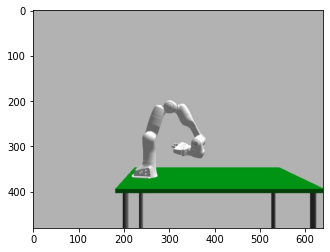

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.9531, 207.7819,   1.0000]],

        [[303.5821, 214.5495,   1.0000]],

        [[363.1849, 293.6065,   1.0000]],

        [[359.0415, 314.2213,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.0729, 222.8463,   1.0000]],

        [[325.7673, 236.4329,   1.0000]],

        [[375.0126, 322.1205,   1.0000]],

        [[359.7374, 327.8547,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7854, 298.0944,   1.0000]],

        [[175.8255, 277.6919,   1.0000]],

        [[249.7220, 211.8770,   1.0000]],

        [[270.0112, 220.0177,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.4171, 203.4100,   1.0000]],

        [[278.1880, 203.25

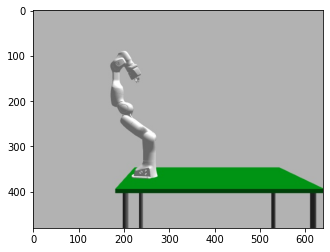

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3541, 234.9520,   1.0000]],

        [[206.8904, 218.3598,   1.0000]],

        [[187.9312, 120.8679,   1.0000]],

        [[206.7744, 110.4917,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5398, 275.8784,   1.0000]],

        [[180.3849, 255.1625,   1.0000]],

        [[111.7707, 183.3168,   1.0000]],

        [[125.6198, 166.6092,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2613, 235.0717,   1.0000]],

        [[206.7652, 218.4554,   1.0000]],

        [[214.1749, 119.4668,   1.0000]],

        [[235.9874, 118.0137,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.3624, 254.7986,   1.0000]],

        [[190.7060, 235.34

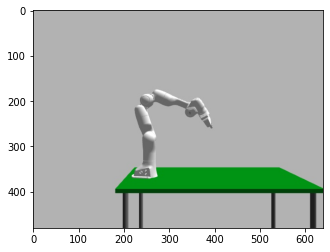

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.0291, 207.3808,   1.0000]],

        [[252.7648, 200.8711,   1.0000]],

        [[349.0797, 223.8942,   1.0000]],

        [[368.3563, 213.8266,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.9980, 207.1324,   1.0000]],

        [[301.7944, 213.3874,   1.0000]],

        [[400.8073, 216.4507,   1.0000]],

        [[405.3345, 195.4838,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.2556, 213.2348,   1.0000]],

        [[314.4622, 223.2139,   1.0000]],

        [[365.7697, 307.8784,   1.0000]],

        [[357.2341, 323.2897,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.7841, 207.0649,   1.0000]],

        [[301.5979, 213.26

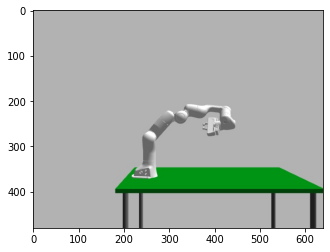

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.0605, 223.7159,   1.0000]],

        [[326.5266, 237.5603,   1.0000]],

        [[425.1563, 238.5162,   1.0000]],

        [[428.1283, 254.3960,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3407, 234.9565,   1.0000]],

        [[206.8720, 218.3614,   1.0000]],

        [[305.1847, 230.8353,   1.0000]],

        [[316.8784, 248.7910,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6987, 298.2407,   1.0000]],

        [[175.6984, 277.8307,   1.0000]],

        [[ 79.9081, 303.9210,   1.0000]],

        [[ 63.3552, 292.3751,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.5671, 254.2912,   1.0000]],

        [[191.0440, 234.88

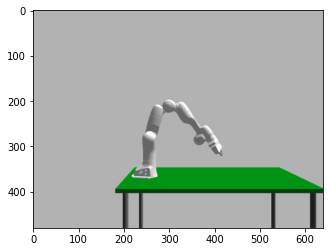

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.3255, 206.9226,   1.0000]],

        [[301.1762, 213.0016,   1.0000]],

        [[368.9024, 285.2967,   1.0000]],

        [[386.2818, 273.4807,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.3273, 254.8866,   1.0000]],

        [[190.6479, 235.4207,   1.0000]],

        [[ 95.5270, 206.5179,   1.0000]],

        [[ 91.7223, 186.5064,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.9757, 207.1276,   1.0000]],

        [[301.7752, 213.3789,   1.0000]],

        [[331.6754, 119.1950,   1.0000]],

        [[338.2015,  97.6126,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5940, 218.2087,   1.0000]],

        [[228.5017, 206.11

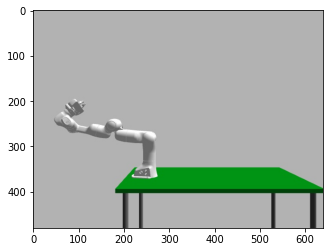

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.6399, 275.0086,   1.0000]],

        [[180.7141, 254.3162,   1.0000]],

        [[ 81.4643, 251.9123,   1.0000]],

        [[ 68.7916, 235.9880,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.3894, 254.7319,   1.0000]],

        [[190.7503, 235.2818,   1.0000]],

        [[106.7622, 182.0134,   1.0000]],

        [[116.3542, 163.2280,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6100, 297.5700,   1.0000]],

        [[175.7948, 277.1292,   1.0000]],

        [[181.4818, 178.2487,   1.0000]],

        [[196.4398, 162.0474,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.8283, 207.7389,   1.0000]],

        [[303.4685, 214.47

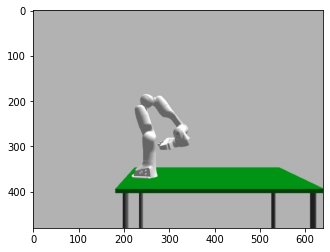

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.4421, 207.2467,   1.0000]],

        [[253.2121, 200.8443,   1.0000]],

        [[323.7052, 270.3763,   1.0000]],

        [[327.7927, 291.5637,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.5541, 219.2097,   1.0000]],

        [[322.2023, 231.6151,   1.0000]],

        [[413.4796, 270.0701,   1.0000]],

        [[435.9419, 267.8444,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7838, 253.7717,   1.0000]],

        [[191.4018, 234.4217,   1.0000]],

        [[281.4108, 193.0254,   1.0000]],

        [[299.6990, 204.7637,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.0019, 207.4577,   1.0000]],

        [[302.7139, 213.97

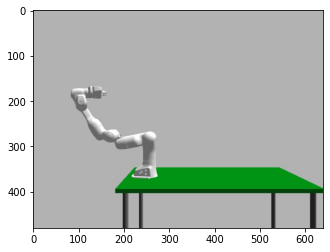

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7244, 298.2386,   1.0000]],

        [[175.7298, 277.8306,   1.0000]],

        [[107.5206, 205.7617,   1.0000]],

        [[106.4367, 184.3244,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.5357, 218.4627,   1.0000]],

        [[321.3786, 230.6016,   1.0000]],

        [[397.1011, 167.0790,   1.0000]],

        [[405.2476, 145.9886,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5893, 218.2145,   1.0000]],

        [[228.4990, 206.1168,   1.0000]],

        [[321.0331, 170.7231,   1.0000]],

        [[339.5764, 181.8863,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.1948, 218.9433,   1.0000]],

        [[321.9125, 231.25

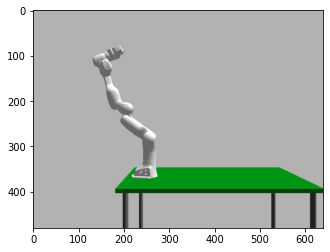

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.4721, 234.8011,   1.0000]],

        [[207.0483, 218.2393,   1.0000]],

        [[163.2101, 129.0842,   1.0000]],

        [[153.0601, 108.6306,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.9521, 219.5084,   1.0000]],

        [[322.5225, 232.0181,   1.0000]],

        [[399.6565, 294.1863,   1.0000]],

        [[420.9770, 301.8893,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.4239, 254.6459,   1.0000]],

        [[190.8074, 235.2046,   1.0000]],

        [[106.9167, 181.7933,   1.0000]],

        [[100.6559, 161.6867,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.8791, 223.5540,   1.0000]],

        [[326.3877, 237.35

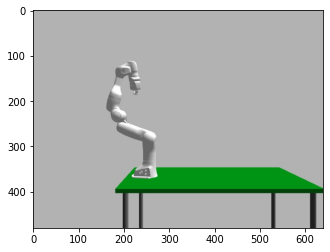

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7162, 253.9248,   1.0000]],

        [[191.2907, 234.5580,   1.0000]],

        [[198.9722, 135.6335,   1.0000]],

        [[220.9781, 133.8712,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.2112, 218.2318,   1.0000]],

        [[321.1134, 230.2865,   1.0000]],

        [[381.2099, 308.9787,   1.0000]],

        [[398.6571, 323.4137,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5036, 276.2209,   1.0000]],

        [[180.2577, 255.4966,   1.0000]],

        [[132.5730, 168.3875,   1.0000]],

        [[140.9239, 148.5635,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.1492, 207.3415,   1.0000]],

        [[252.8951, 200.86

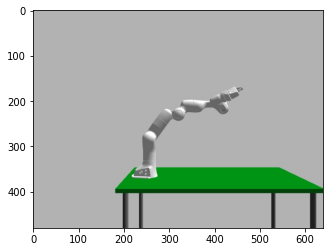

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.2181, 218.9605,   1.0000]],

        [[321.9313, 231.2780,   1.0000]],

        [[419.8426, 216.9151,   1.0000]],

        [[410.0341, 198.3992,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.4111, 207.5969,   1.0000]],

        [[303.0883, 214.2229,   1.0000]],

        [[395.1273, 250.6967,   1.0000]],

        [[417.0256, 255.9648,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7566, 253.8261,   1.0000]],

        [[191.3577, 234.4696,   1.0000]],

        [[225.0252, 141.2125,   1.0000]],

        [[232.3884, 120.0205,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.3327, 203.4097,   1.0000]],

        [[279.1036, 203.49

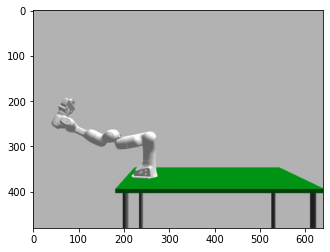

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7091, 298.2346,   1.0000]],

        [[175.7121, 277.8254,   1.0000]],

        [[ 80.0593, 251.0363,   1.0000]],

        [[ 59.6120, 241.7039,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.6843, 224.2806,   1.0000]],

        [[327.0026, 238.2874,   1.0000]],

        [[397.5320, 169.3423,   1.0000]],

        [[417.0399, 162.4744,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3378, 234.9633,   1.0000]],

        [[206.8673, 218.3672,   1.0000]],

        [[305.1806, 230.8196,   1.0000]],

        [[320.7307, 246.0960,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3360, 234.9753,   1.0000]],

        [[206.8661, 218.37

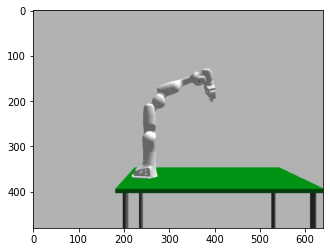

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.9448, 203.4086,   1.0000]],

        [[278.7161, 203.3940,   1.0000]],

        [[364.9886, 154.7703,   1.0000]],

        [[386.5644, 150.0203,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.7708, 203.4165,   1.0000]],

        [[277.5403, 203.0961,   1.0000]],

        [[326.1351, 289.3359,   1.0000]],

        [[334.3894, 310.0205,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.2015, 203.4091,   1.0000]],

        [[278.9726, 203.4614,   1.0000]],

        [[349.7891, 134.2448,   1.0000]],

        [[365.3863, 117.9553,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.4853, 206.9718,   1.0000]],

        [[301.3232, 213.09

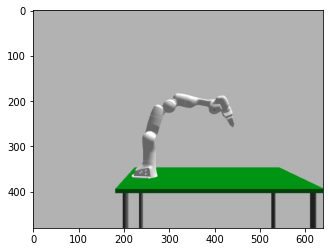

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.1652, 207.1856,   1.0000]],

        [[301.9478, 213.4843,   1.0000]],

        [[400.9450, 216.9748,   1.0000]],

        [[422.3335, 209.7085,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5663, 275.6372,   1.0000]],

        [[180.4751, 254.9275,   1.0000]],

        [[ 95.5233, 203.3887,   1.0000]],

        [[ 88.6503, 183.4005,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4402, 276.7865,   1.0000]],

        [[180.0417, 256.0485,   1.0000]],

        [[268.6229, 211.6094,   1.0000]],

        [[289.1692, 219.2800,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.2643, 203.4111,   1.0000]],

        [[278.0350, 203.21

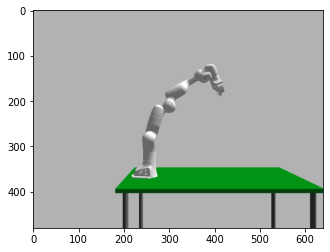

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.4390, 207.2757,   1.0000]],

        [[302.1998, 213.6478,   1.0000]],

        [[376.7305, 148.6198,   1.0000]],

        [[397.0408, 140.2857,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.5997, 297.5091,   1.0000]],

        [[175.8010, 277.0652,   1.0000]],

        [[207.5555, 183.2751,   1.0000]],

        [[214.4427, 162.1189,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.1242, 203.4123,   1.0000]],

        [[277.8946, 203.1838,   1.0000]],

        [[363.2479, 253.3491,   1.0000]],

        [[384.3092, 260.7776,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.3820, 218.3522,   1.0000]],

        [[321.2537, 230.45

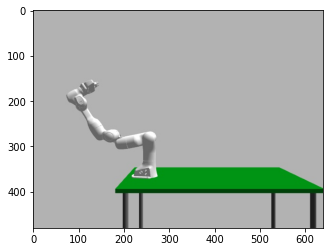

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7232, 298.2418,   1.0000]],

        [[175.7271, 277.8339,   1.0000]],

        [[107.4650, 205.8059,   1.0000]],

        [[ 94.7976, 187.3506,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.3915, 218.3564,   1.0000]],

        [[228.2649, 206.2073,   1.0000]],

        [[326.7859, 195.9065,   1.0000]],

        [[346.5526, 205.4536,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.6808, 254.0117,   1.0000]],

        [[191.2321, 234.6358,   1.0000]],

        [[172.3280, 137.1475,   1.0000]],

        [[191.2875, 126.4511,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.6373, 203.4120,   1.0000]],

        [[279.4072, 203.57

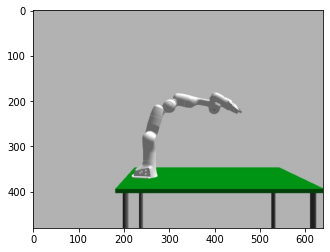

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.0515, 207.1493,   1.0000]],

        [[301.8434, 213.4183,   1.0000]],

        [[400.8515, 216.6182,   1.0000]],

        [[412.6869, 198.2229,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[295.9732, 213.0781,   1.0000]],

        [[314.2217, 222.9849,   1.0000]],

        [[320.8999, 321.7744,   1.0000]],

        [[312.5298, 340.8050,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5249, 276.0157,   1.0000]],

        [[180.3336, 255.2963,   1.0000]],

        [[111.5267, 183.6219,   1.0000]],

        [[102.3498, 163.6386,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.5044, 207.2947,   1.0000]],

        [[302.2588, 213.68

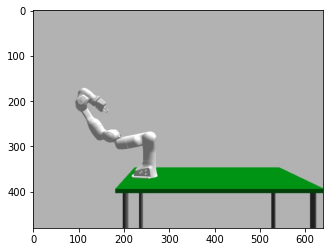

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7267, 298.2402,   1.0000]],

        [[175.7322, 277.8324,   1.0000]],

        [[107.5738, 205.7251,   1.0000]],

        [[121.6192, 188.8448,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7708, 298.1487,   1.0000]],

        [[175.8162, 277.7403,   1.0000]],

        [[250.1988, 212.4439,   1.0000]],

        [[269.9655, 221.6435,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.7593, 207.3800,   1.0000]],

        [[302.4930, 213.8358,   1.0000]],

        [[391.9597, 171.5682,   1.0000]],

        [[402.5992, 151.6776,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.1860, 218.5045,   1.0000]],

        [[228.0217, 206.30

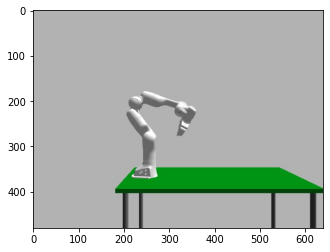

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.3411, 218.3925,   1.0000]],

        [[228.2054, 206.2304,   1.0000]],

        [[325.9714, 222.1583,   1.0000]],

        [[344.8036, 233.6821,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.8157, 207.3963,   1.0000]],

        [[302.5436, 213.8651,   1.0000]],

        [[374.8972, 146.3517,   1.0000]],

        [[381.7867, 124.6765,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5357, 218.2528,   1.0000]],

        [[228.4356, 206.1412,   1.0000]],

        [[320.8888, 170.5378,   1.0000]],

        [[340.7806, 160.4485,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7907, 253.7442,   1.0000]],

        [[191.4146, 234.39

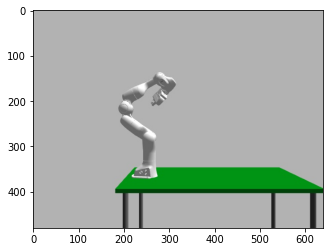

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2218, 235.1184,   1.0000]],

        [[206.7129, 218.4922,   1.0000]],

        [[283.3439, 155.6490,   1.0000]],

        [[300.1945, 169.2479,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6702, 218.1552,   1.0000]],

        [[228.5923, 206.0778,   1.0000]],

        [[216.5935, 107.5242,   1.0000]],

        [[201.7112,  89.3376,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.4659, 206.9658,   1.0000]],

        [[301.3054, 213.0816,   1.0000]],

        [[385.5739, 265.1727,   1.0000]],

        [[396.2430, 246.9805,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7098, 298.2442,   1.0000]],

        [[175.7101, 277.83

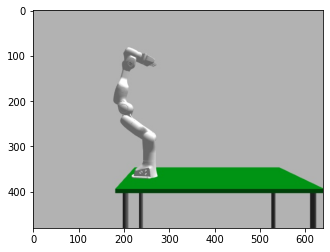

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2824, 235.0446,   1.0000]],

        [[206.7938, 218.4338,   1.0000]],

        [[214.2084, 119.4487,   1.0000]],

        [[223.2305,  99.3089,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.6301, 275.0887,   1.0000]],

        [[180.6833, 254.3940,   1.0000]],

        [[ 81.4251, 252.1494,   1.0000]],

        [[ 79.8766, 231.8024,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3073, 207.6213,   1.0000]],

        [[251.9822, 200.9245,   1.0000]],

        [[242.6474, 102.2388,   1.0000]],

        [[228.6361,  83.5796,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.4286, 234.8567,   1.0000]],

        [[206.9901, 218.28

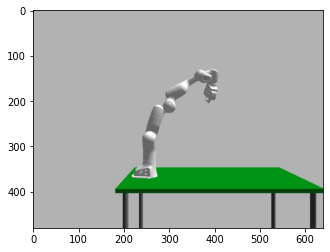

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.5093, 207.2985,   1.0000]],

        [[302.2642, 213.6889,   1.0000]],

        [[376.9133, 148.7970,   1.0000]],

        [[397.7402, 151.6895,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.1072, 203.4125,   1.0000]],

        [[277.8775, 203.1795,   1.0000]],

        [[363.2534, 253.3064,   1.0000]],

        [[382.8866, 263.9861,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.6015, 207.6614,   1.0000]],

        [[303.2620, 214.3372,   1.0000]],

        [[382.0553, 274.2875,   1.0000]],

        [[390.8294, 294.1683,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.3536, 207.2482,   1.0000]],

        [[302.1216, 213.59

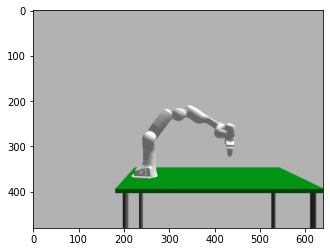

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.5318, 219.1931,   1.0000]],

        [[322.1844, 231.5927,   1.0000]],

        [[413.4865, 269.9896,   1.0000]],

        [[436.1269, 271.3374,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.4762, 203.4097,   1.0000]],

        [[278.2472, 203.2729,   1.0000]],

        [[377.2661, 204.0534,   1.0000]],

        [[398.4464, 210.4661,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4621, 276.6362,   1.0000]],

        [[180.1051, 255.9023,   1.0000]],

        [[183.0576, 156.7741,   1.0000]],

        [[204.2968, 150.5428,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2610, 235.0709,   1.0000]],

        [[206.7655, 218.45

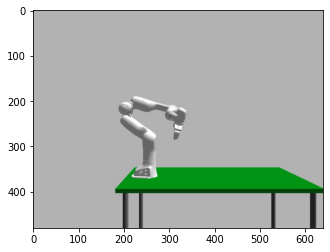

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3269, 234.9778,   1.0000]],

        [[206.8528, 218.3788,   1.0000]],

        [[305.1758, 230.7533,   1.0000]],

        [[326.3999, 237.2197,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.2531, 207.2137,   1.0000]],

        [[302.0285, 213.5354,   1.0000]],

        [[398.4619, 190.9621,   1.0000]],

        [[414.9721, 175.5442,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.6348, 203.4090,   1.0000]],

        [[278.4060, 203.3136,   1.0000]],

        [[377.4202, 204.5081,   1.0000]],

        [[391.8711, 187.8880,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4398, 276.7911,   1.0000]],

        [[180.0397, 256.05

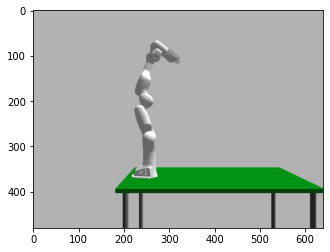

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3306, 207.6134,   1.0000]],

        [[252.0072, 200.9225,   1.0000]],

        [[269.2452, 103.2977,   1.0000]],

        [[281.7768,  85.4473,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.5127, 218.4461,   1.0000]],

        [[321.3599, 230.5790,   1.0000]],

        [[397.0407, 167.0067,   1.0000]],

        [[408.4151, 147.3649,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.5532, 207.3105,   1.0000]],

        [[302.3034, 213.7107,   1.0000]],

        [[389.6645, 167.1241,   1.0000]],

        [[383.4515, 146.4464,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4458, 276.7684,   1.0000]],

        [[180.0537, 256.03

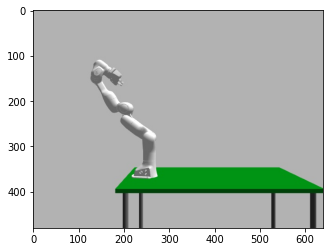

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.5814, 234.6613,   1.0000]],

        [[207.1943, 218.1278,   1.0000]],

        [[141.5776, 143.5263,   1.0000]],

        [[155.8309, 127.8950,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7046, 298.2355,   1.0000]],

        [[175.7066, 277.8260,   1.0000]],

        [[ 76.3843, 277.4223,   1.0000]],

        [[ 63.4794, 261.5486,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.6646, 203.4089,   1.0000]],

        [[278.4358, 203.3212,   1.0000]],

        [[374.2729, 178.3802,   1.0000]],

        [[387.2908, 160.1640,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.0905, 203.4088,   1.0000]],

        [[278.8617, 203.43

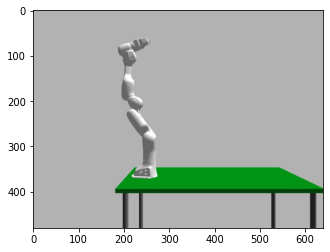

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6802, 218.1482,   1.0000]],

        [[228.6043, 206.0734,   1.0000]],

        [[216.6165, 107.5195,   1.0000]],

        [[208.2658,  85.8787,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7667, 253.8171,   1.0000]],

        [[191.3736, 234.4625,   1.0000]],

        [[289.0717, 217.9509,   1.0000]],

        [[308.4366, 228.2911,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.1156, 206.8585,   1.0000]],

        [[300.9829, 212.8827,   1.0000]],

        [[347.7296, 300.2101,   1.0000]],

        [[368.0716, 308.2340,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4688, 276.5683,   1.0000]],

        [[180.1302, 255.83

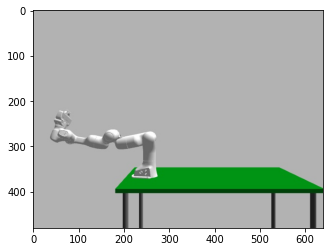

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7075, 298.2394,   1.0000]],

        [[175.7088, 277.8302,   1.0000]],

        [[ 76.3934, 277.3564,   1.0000]],

        [[ 55.6771, 270.3135,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.3167, 207.5651,   1.0000]],

        [[303.0021, 214.1664,   1.0000]],

        [[395.1299, 250.4171,   1.0000]],

        [[415.2474, 241.3933,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3544, 207.6056,   1.0000]],

        [[252.0339, 200.9212,   1.0000]],

        [[216.9240, 108.2491,   1.0000]],

        [[198.4966,  93.8459,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.9463, 203.4143,   1.0000]],

        [[277.7163, 203.13

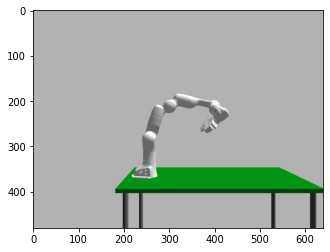

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.0654, 207.4811,   1.0000]],

        [[302.7728, 214.0168,   1.0000]],

        [[401.2719, 223.9049,   1.0000]],

        [[413.5183, 241.1316,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.4346, 218.3208,   1.0000]],

        [[228.3130, 206.1822,   1.0000]],

        [[167.5990, 127.6398,   1.0000]],

        [[144.5974, 122.5464,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.5040, 234.7601,   1.0000]],

        [[207.0910, 218.2066,   1.0000]],

        [[141.3064, 143.7446,   1.0000]],

        [[129.4078, 124.7257,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.3365, 254.8635,   1.0000]],

        [[190.6631, 235.40

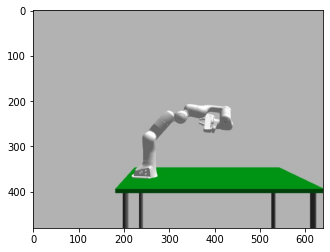

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.0949, 223.7468,   1.0000]],

        [[326.5530, 237.6002,   1.0000]],

        [[425.1815, 238.6582,   1.0000]],

        [[420.6054, 254.2592,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5073, 218.2732,   1.0000]],

        [[228.4020, 206.1542,   1.0000]],

        [[320.8133, 170.4429,   1.0000]],

        [[333.2262, 152.0438,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.8618, 207.4137,   1.0000]],

        [[302.5866, 213.8962,   1.0000]],

        [[400.1003, 196.9431,   1.0000]],

        [[418.1363, 183.3387,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4402, 276.7976,   1.0000]],

        [[180.0397, 256.05

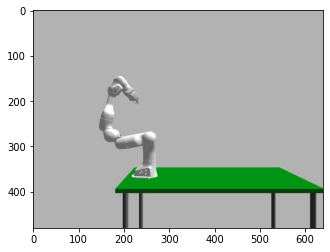

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6134, 297.5906,   1.0000]],

        [[175.7927, 277.1507,   1.0000]],

        [[181.4518, 178.2679,   1.0000]],

        [[199.0550, 164.9445,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.7594, 203.4167,   1.0000]],

        [[277.5289, 203.0933,   1.0000]],

        [[326.1510, 289.3176,   1.0000]],

        [[331.0216, 310.8618,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.4571, 207.5708,   1.0000]],

        [[252.1441, 200.9125,   1.0000]],

        [[317.0644, 126.0257,   1.0000]],

        [[324.3040, 104.3925,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.6329, 275.0658,   1.0000]],

        [[180.6921, 254.37

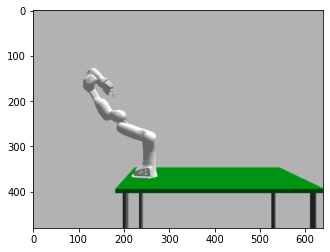

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.5459, 254.3429,   1.0000]],

        [[191.0092, 234.9327,   1.0000]],

        [[124.6476, 160.8837,   1.0000]],

        [[141.8708, 147.4978,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.5222, 207.5489,   1.0000]],

        [[252.2148, 200.9075,   1.0000]],

        [[317.2959, 126.1596,   1.0000]],

        [[338.4107, 121.1111,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.6816, 207.3524,   1.0000]],

        [[302.4210, 213.7861,   1.0000]],

        [[389.9362, 167.4913,   1.0000]],

        [[402.0986, 148.3577,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2360, 235.1031,   1.0000]],

        [[206.7316, 218.48

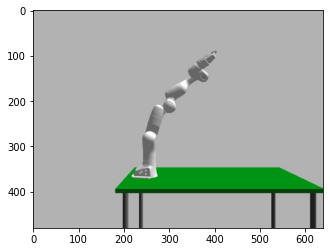

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.9381, 207.4366,   1.0000]],

        [[302.6556, 213.9375,   1.0000]],

        [[375.2230, 146.6542,   1.0000]],

        [[361.2512, 130.4379,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[309.9412, 222.7325,   1.0000]],

        [[325.6652, 236.2848,   1.0000]],

        [[350.8375, 331.8933,   1.0000]],

        [[345.3625, 351.5266,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.7596, 207.0573,   1.0000]],

        [[301.5755, 213.2499,   1.0000]],

        [[396.4035, 241.9256,   1.0000]],

        [[414.8338, 229.9685,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3185, 207.6176,   1.0000]],

        [[251.9947, 200.92

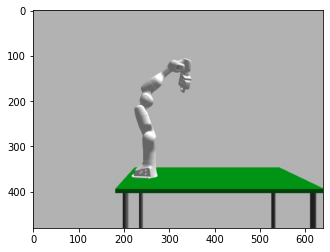

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.5432, 207.5419,   1.0000]],

        [[252.2375, 200.9059,   1.0000]],

        [[317.3714, 126.2037,   1.0000]],

        [[338.6196, 128.8201,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.2122, 218.4856,   1.0000]],

        [[228.0527, 206.2900,   1.0000]],

        [[318.3416, 247.0283,   1.0000]],

        [[337.9388, 257.4563,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2573, 235.0706,   1.0000]],

        [[206.7602, 218.4536,   1.0000]],

        [[297.4265, 178.4780,   1.0000]],

        [[319.4210, 180.5015,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6834, 297.9947,   1.0000]],

        [[175.7543, 277.57

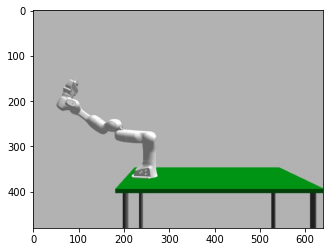

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5787, 275.5291,   1.0000]],

        [[180.5161, 254.8222,   1.0000]],

        [[ 95.6818, 203.1049,   1.0000]],

        [[ 75.8076, 191.5127,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7737, 253.7988,   1.0000]],

        [[191.3851, 234.4460,   1.0000]],

        [[289.1007, 218.0364,   1.0000]],

        [[310.9506, 214.6674,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4462, 276.7650,   1.0000]],

        [[180.0551, 256.0278,   1.0000]],

        [[233.1810, 172.3885,   1.0000]],

        [[250.7243, 158.8000,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.8787, 203.4086,   1.0000]],

        [[278.6501, 203.37

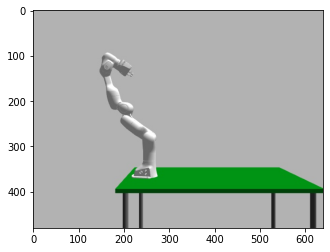

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.4211, 234.8664,   1.0000]],

        [[206.9799, 218.2914,   1.0000]],

        [[163.0242, 129.1888,   1.0000]],

        [[175.4339, 112.0689,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.5241, 203.4110,   1.0000]],

        [[279.2944, 203.5471,   1.0000]],

        [[305.9740, 108.2331,   1.0000]],

        [[314.9622,  87.7955,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.2630, 207.5447,   1.0000]],

        [[302.9524, 214.1304,   1.0000]],

        [[331.8839, 119.6180,   1.0000]],

        [[315.3329, 105.3304,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.4792, 218.4219,   1.0000]],

        [[321.3330, 230.54

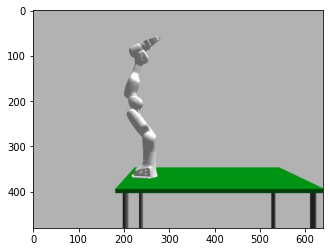

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7245, 218.1175,   1.0000]],

        [[228.6574, 206.0545,   1.0000]],

        [[243.0856, 107.8668,   1.0000]],

        [[233.2624,  86.7163,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7947, 253.7361,   1.0000]],

        [[191.4213, 234.3893,   1.0000]],

        [[267.7226, 171.1924,   1.0000]],

        [[284.6906, 156.8555,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.9824, 207.3961,   1.0000]],

        [[252.7142, 200.8743,   1.0000]],

        [[351.6942, 197.3933,   1.0000]],

        [[372.0039, 188.3202,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5720, 218.2269,   1.0000]],

        [[228.4785, 206.12

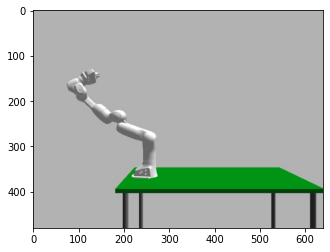

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.4327, 254.6241,   1.0000]],

        [[190.8219, 235.1850,   1.0000]],

        [[106.9564, 181.7368,   1.0000]],

        [[ 96.8785, 162.7948,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.6349, 218.5343,   1.0000]],

        [[321.4591, 230.6992,   1.0000]],

        [[397.3601, 167.3903,   1.0000]],

        [[387.6625, 148.4938,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7465, 253.8661,   1.0000]],

        [[191.3435, 234.5064,   1.0000]],

        [[289.0293, 217.9214,   1.0000]],

        [[290.1763, 238.5037,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3091, 235.0099,   1.0000]],

        [[206.8298, 218.40

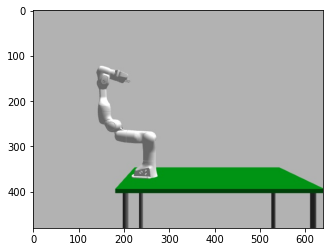

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4783, 276.4681,   1.0000]],

        [[180.1665, 255.7379,   1.0000]],

        [[156.9032, 159.2611,   1.0000]],

        [[163.4801, 138.4074,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.7263, 207.7039,   1.0000]],

        [[303.3756, 214.4123,   1.0000]],

        [[381.9783, 274.6119,   1.0000]],

        [[403.9293, 278.8651,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.0542, 207.4773,   1.0000]],

        [[302.7625, 214.0101,   1.0000]],

        [[400.3581, 197.5423,   1.0000]],

        [[416.6458, 210.9813,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4412, 276.7901,   1.0000]],

        [[180.0431, 256.05

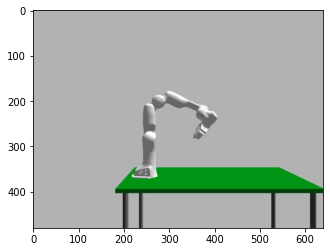

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.3847, 203.4102,   1.0000]],

        [[278.1556, 203.2496,   1.0000]],

        [[373.5359, 229.8208,   1.0000]],

        [[389.8792, 244.4056,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.9393, 218.7557,   1.0000]],

        [[321.7059, 231.0003,   1.0000]],

        [[412.0063, 190.6593,   1.0000]],

        [[430.5605, 177.6099,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7400, 253.8672,   1.0000]],

        [[191.3302, 234.5065,   1.0000]],

        [[199.0619, 135.5902,   1.0000]],

        [[204.3716, 113.9088,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3421, 207.6097,   1.0000]],

        [[252.0204, 200.92

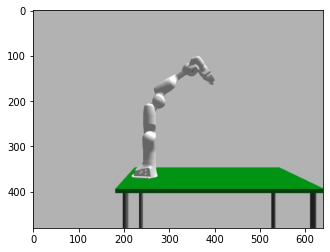

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.2218, 203.4092,   1.0000]],

        [[278.9929, 203.4668,   1.0000]],

        [[349.8473, 134.2889,   1.0000]],

        [[367.7322, 120.9184,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.2917, 223.0366,   1.0000]],

        [[325.9355, 236.6806,   1.0000]],

        [[395.4379, 306.8204,   1.0000]],

        [[381.1019, 314.8162,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3366, 207.6115,   1.0000]],

        [[252.0144, 200.9226,   1.0000]],

        [[216.8812, 108.2588,   1.0000]],

        [[207.1682,  87.5160,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.8734, 206.7860,   1.0000]],

        [[300.7608, 212.74

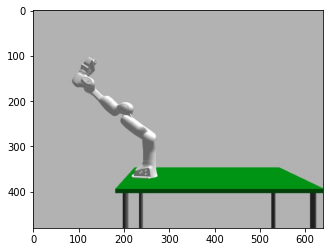

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.7535, 234.4432,   1.0000]],

        [[207.4232, 217.9540,   1.0000]],

        [[124.8115, 162.8302,   1.0000]],

        [[105.7368, 150.0835,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.2926, 223.9251,   1.0000]],

        [[326.7063, 237.8278,   1.0000]],

        [[310.8234, 335.5242,   1.0000]],

        [[295.7645, 346.8429,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6019, 218.2032,   1.0000]],

        [[228.5111, 206.1080,   1.0000]],

        [[190.8939, 114.2189,   1.0000]],

        [[184.0803,  92.6624,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.8337, 207.4451,   1.0000]],

        [[252.5529, 200.88

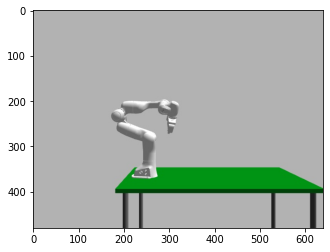

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7701, 253.8081,   1.0000]],

        [[191.3792, 234.4544,   1.0000]],

        [[289.0864, 217.9957,   1.0000]],

        [[310.9492, 221.7278,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7141, 298.2358,   1.0000]],

        [[175.7177, 277.8271,   1.0000]],

        [[ 80.1255, 250.8838,   1.0000]],

        [[ 87.8297, 230.7030,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3112, 207.6201,   1.0000]],

        [[251.9866, 200.9244,   1.0000]],

        [[242.6107, 102.2436,   1.0000]],

        [[253.1392,  83.6010,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.6906, 203.4088,   1.0000]],

        [[278.4618, 203.32

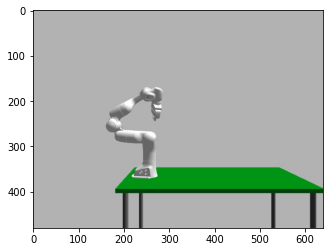

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4405, 276.7965,   1.0000]],

        [[180.0404, 256.0583,   1.0000]],

        [[253.5374, 189.6051,   1.0000]],

        [[275.4942, 191.7846,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.0249, 218.8184,   1.0000]],

        [[321.7752, 231.0854,   1.0000]],

        [[419.6080, 216.1773,   1.0000]],

        [[437.4827, 202.3523,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2537, 235.0754,   1.0000]],

        [[206.7554, 218.4574,   1.0000]],

        [[297.4113, 178.4584,   1.0000]],

        [[319.5188, 176.7928,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.7120, 203.4088,   1.0000]],

        [[278.4833, 203.33

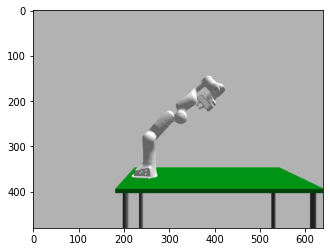

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.5818, 224.1869,   1.0000]],

        [[326.9245, 238.1671,   1.0000]],

        [[397.2369, 168.9993,   1.0000]],

        [[407.8034, 180.6460,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.3896, 207.5896,   1.0000]],

        [[303.0687, 214.2101,   1.0000]],

        [[395.1279, 250.6331,   1.0000]],

        [[417.5853, 252.3188,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.2885, 213.2529,   1.0000]],

        [[314.4904, 223.2405,   1.0000]],

        [[341.4665, 318.4967,   1.0000]],

        [[333.7284, 336.4359,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.1333, 207.1776,   1.0000]],

        [[301.9196, 213.46

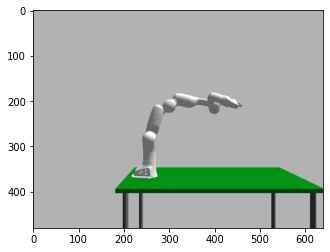

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.0213, 207.1398,   1.0000]],

        [[301.8158, 213.4009,   1.0000]],

        [[400.8266, 216.5238,   1.0000]],

        [[409.1230, 196.5343,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3100, 207.6205,   1.0000]],

        [[251.9854, 200.9245,   1.0000]],

        [[242.5910, 102.2457,   1.0000]],

        [[258.7893,  88.9096,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.7923, 203.4162,   1.0000]],

        [[277.5618, 203.1013,   1.0000]],

        [[326.1055, 289.3701,   1.0000]],

        [[340.3523, 306.5311,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7043, 298.2469,   1.0000]],

        [[175.7030, 277.83

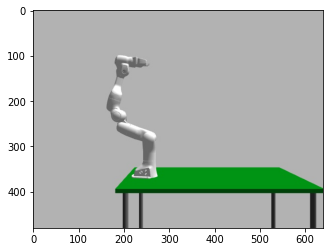

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7432, 253.8596,   1.0000]],

        [[191.3354, 234.4997,   1.0000]],

        [[199.0740, 135.5846,   1.0000]],

        [[200.5628, 113.0673,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[295.9562, 213.0689,   1.0000]],

        [[314.2072, 222.9713,   1.0000]],

        [[320.9250, 321.7578,   1.0000]],

        [[317.7120, 343.7390,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.4487, 207.2446,   1.0000]],

        [[253.2192, 200.8439,   1.0000]],

        [[323.6965, 270.3919,   1.0000]],

        [[324.2189, 291.6037,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5166, 218.2665,   1.0000]],

        [[228.4131, 206.14

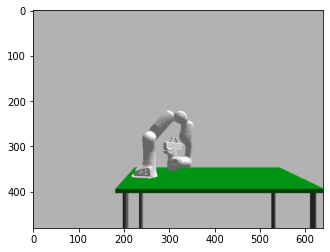

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.6285, 223.3325,   1.0000]],

        [[326.1969, 237.0621,   1.0000]],

        [[324.5472, 336.0191,   1.0000]],

        [[308.2907, 335.2778,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3059, 207.6218,   1.0000]],

        [[251.9805, 200.9245,   1.0000]],

        [[269.1079, 103.2815,   1.0000]],

        [[260.4074,  81.7534,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4450, 276.7753,   1.0000]],

        [[180.0509, 256.0378,   1.0000]],

        [[233.1920, 172.4075,   1.0000]],

        [[255.0686, 169.2125,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3613, 207.6031,   1.0000]],

        [[252.0404, 200.92

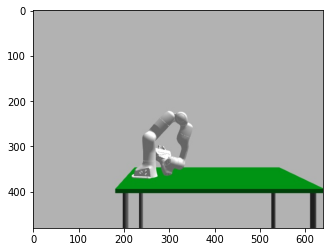

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[312.2284, 224.7808,   1.0000]],

        [[327.4214, 238.9292,   1.0000]],

        [[309.9558, 336.4082,   1.0000]],

        [[294.4763, 346.5957,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.3492, 218.3868,   1.0000]],

        [[228.2149, 206.2267,   1.0000]],

        [[325.9755, 222.1882,   1.0000]],

        [[342.5711, 236.4839,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.6450, 207.0214,   1.0000]],

        [[301.4701, 213.1841,   1.0000]],

        [[385.4986, 265.6599,   1.0000]],

        [[406.6686, 273.3235,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.1171, 207.1702,   1.0000]],

        [[301.9037, 213.45

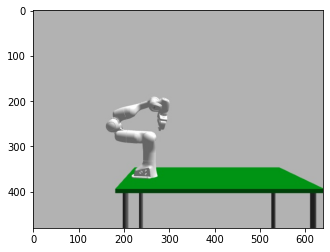

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4402, 276.7872,   1.0000]],

        [[180.0416, 256.0491,   1.0000]],

        [[268.6164, 211.5974,   1.0000]],

        [[290.2907, 215.8363,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.8927, 207.4257,   1.0000]],

        [[252.6168, 200.8805,   1.0000]],

        [[351.5869, 197.1276,   1.0000]],

        [[371.8376, 205.7310,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7264, 218.1161,   1.0000]],

        [[228.6598, 206.0537,   1.0000]],

        [[243.0831, 107.8658,   1.0000]],

        [[229.9885,  88.5640,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3312, 207.6134,   1.0000]],

        [[252.0086, 200.92

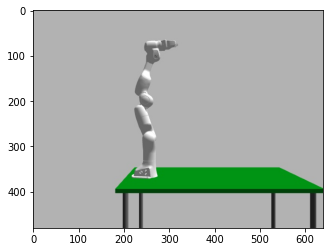

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3119, 207.6198,   1.0000]],

        [[251.9870, 200.9240,   1.0000]],

        [[269.1439, 103.2857,   1.0000]],

        [[267.6833,  80.3291,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.2968, 207.5560,   1.0000]],

        [[302.9832, 214.1505,   1.0000]],

        [[331.9955, 119.6627,   1.0000]],

        [[311.1902, 116.1132,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.2707, 255.0287,   1.0000]],

        [[190.5542, 235.5485,   1.0000]],

        [[ 95.3382, 206.9297,   1.0000]],

        [[ 73.2884, 200.2619,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.6786, 207.6876,   1.0000]],

        [[303.3321, 214.38

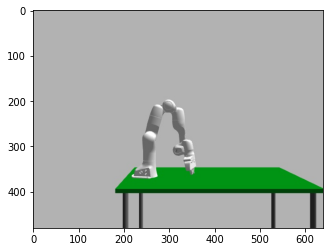

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.8795, 206.7872,   1.0000]],

        [[300.7654, 212.7497,   1.0000]],

        [[323.2967, 309.1895,   1.0000]],

        [[343.6809, 305.9196,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5607, 275.6868,   1.0000]],

        [[180.4564, 254.9758,   1.0000]],

        [[ 95.4516, 203.5177,   1.0000]],

        [[ 96.6044, 182.6578,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7900, 253.7495,   1.0000]],

        [[191.4138, 234.4014,   1.0000]],

        [[267.6162, 171.0869,   1.0000]],

        [[284.8418, 184.2804,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.5580, 203.4113,   1.0000]],

        [[279.3282, 203.55

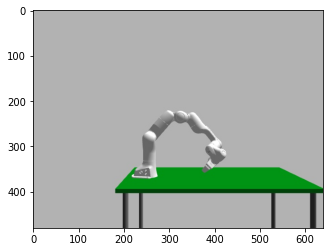

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.4722, 223.1945,   1.0000]],

        [[326.0748, 236.8856,   1.0000]],

        [[395.2166, 307.3834,   1.0000]],

        [[410.3386, 324.1902,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5351, 275.9215,   1.0000]],

        [[180.3688, 255.2045,   1.0000]],

        [[111.6947, 183.4120,   1.0000]],

        [[118.3917, 163.2430,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7225, 298.2264,   1.0000]],

        [[175.7312, 277.8178,   1.0000]],

        [[107.5477, 205.7273,   1.0000]],

        [[110.5105, 184.5354,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.9206, 203.4086,   1.0000]],

        [[278.6919, 203.38

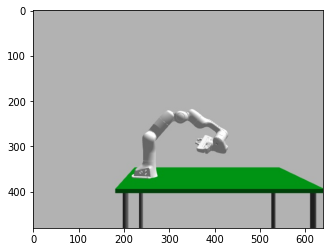

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.6078, 223.3137,   1.0000]],

        [[326.1792, 237.0402,   1.0000]],

        [[411.2610, 287.0715,   1.0000]],

        [[409.3670, 303.8273,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5904, 218.2137,   1.0000]],

        [[228.5003, 206.1162,   1.0000]],

        [[308.4896, 147.6161,   1.0000]],

        [[330.1405, 150.1155,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.5964, 207.0063,   1.0000]],

        [[301.4254, 213.1562,   1.0000]],

        [[385.5190, 265.5280,   1.0000]],

        [[407.8067, 266.0172,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7719, 253.8033,   1.0000]],

        [[191.3822, 234.45

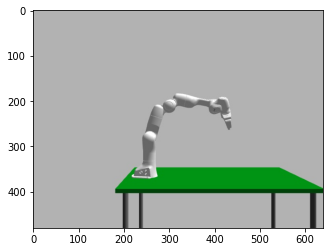

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.1882, 207.1929,   1.0000]],

        [[301.9689, 213.4977,   1.0000]],

        [[400.9639, 217.0470,   1.0000]],

        [[423.2552, 213.3203,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.7818, 203.4164,   1.0000]],

        [[277.5513, 203.0988,   1.0000]],

        [[326.1199, 289.3534,   1.0000]],

        [[337.5323, 308.5633,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6269, 218.1876,   1.0000]],

        [[228.5433, 206.0996,   1.0000]],

        [[308.6268, 147.7276,   1.0000]],

        [[327.4886, 135.7853,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.4449, 207.5749,   1.0000]],

        [[252.1309, 200.91

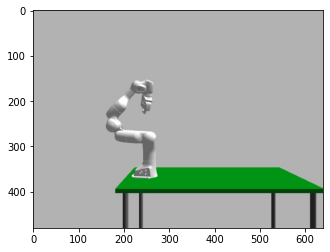

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4442, 276.7835,   1.0000]],

        [[180.0478, 256.0458,   1.0000]],

        [[233.1938, 172.4183,   1.0000]],

        [[254.8093, 176.6946,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4644, 276.6131,   1.0000]],

        [[180.1136, 255.8797,   1.0000]],

        [[183.0951, 156.7535,   1.0000]],

        [[200.7214, 143.6638,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.6601, 223.3598,   1.0000]],

        [[326.2195, 237.0999,   1.0000]],

        [[411.2257, 287.2601,   1.0000]],

        [[399.5684, 298.7379,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.0913, 207.4897,   1.0000]],

        [[302.7964, 214.03

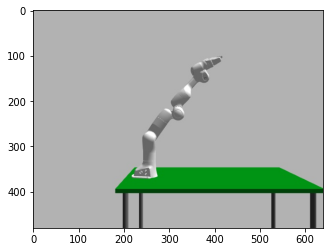

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.3584, 218.3353,   1.0000]],

        [[321.2345, 230.4277,   1.0000]],

        [[376.7949, 148.7647,   1.0000]],

        [[368.5277, 128.5446,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4998, 276.2576,   1.0000]],

        [[180.2441, 255.5324,   1.0000]],

        [[132.5020, 168.4522,   1.0000]],

        [[147.6112, 152.8032,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.7557, 207.4710,   1.0000]],

        [[252.4682, 200.8902,   1.0000]],

        [[346.8208, 170.7143,   1.0000]],

        [[367.7589, 162.7931,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.2071, 207.5283,   1.0000]],

        [[302.9021, 214.10

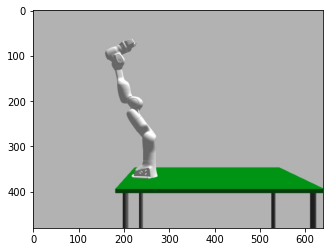

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6126, 218.1956,   1.0000]],

        [[228.5239, 206.1032,   1.0000]],

        [[190.9241, 114.2077,   1.0000]],

        [[180.4981,  93.7085,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6460, 297.7814,   1.0000]],

        [[175.7741, 277.3508,   1.0000]],

        [[154.7479, 180.5153,   1.0000]],

        [[168.2852, 163.2835,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6967, 218.1367,   1.0000]],

        [[228.6240, 206.0663,   1.0000]],

        [[216.6452, 107.5129,   1.0000]],

        [[223.2108,  86.6833,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.3066, 207.5593,   1.0000]],

        [[302.9922, 214.15

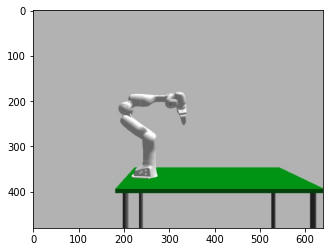

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3172, 234.9907,   1.0000]],

        [[206.8399, 218.3892,   1.0000]],

        [[304.9298, 204.3468,   1.0000]],

        [[326.8871, 201.3279,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4813, 276.4387,   1.0000]],

        [[180.1774, 255.7092,   1.0000]],

        [[156.9594, 159.2233,   1.0000]],

        [[170.4635, 142.1595,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.2395, 223.8768,   1.0000]],

        [[326.6636, 237.7678,   1.0000]],

        [[422.1816, 213.2317,   1.0000]],

        [[440.7222, 219.7551,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7604, 298.2003,   1.0000]],

        [[175.8149, 277.78

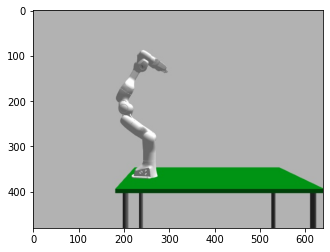

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2339, 235.1055,   1.0000]],

        [[206.7287, 218.4822,   1.0000]],

        [[240.1876, 125.0947,   1.0000]],

        [[251.1162, 105.6509,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6044, 297.5368,   1.0000]],

        [[175.7982, 277.0943,   1.0000]],

        [[181.5305, 178.2178,   1.0000]],

        [[186.4042, 156.5262,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3366, 234.9577,   1.0000]],

        [[206.8678, 218.3619,   1.0000]],

        [[305.1836, 230.8358,   1.0000]],

        [[316.8762, 248.7906,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.4595, 203.4098,   1.0000]],

        [[278.2305, 203.26

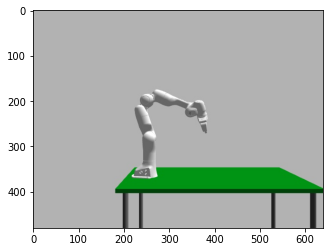

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.0628, 207.3697,   1.0000]],

        [[252.8015, 200.8689,   1.0000]],

        [[349.0927, 223.9908,   1.0000]],

        [[370.9780, 220.8958,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.5119, 207.5524,   1.0000]],

        [[252.2036, 200.9083,   1.0000]],

        [[317.2594, 126.1384,   1.0000]],

        [[337.3705, 117.4144,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6754, 218.1515,   1.0000]],

        [[228.5985, 206.0755,   1.0000]],

        [[216.6059, 107.5217,   1.0000]],

        [[204.8315,  87.3011,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.8604, 203.4153,   1.0000]],

        [[277.6302, 203.11

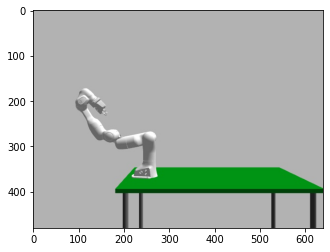

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7235, 298.2216,   1.0000]],

        [[175.7339, 277.8129,   1.0000]],

        [[107.6027, 205.6817,   1.0000]],

        [[124.6238, 191.2675,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7154, 298.2315,   1.0000]],

        [[175.7206, 277.8227,   1.0000]],

        [[ 90.6958, 226.5320,   1.0000]],

        [[ 99.8833, 206.9740,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.2368, 206.8954,   1.0000]],

        [[301.0945, 212.9513,   1.0000]],

        [[368.9839, 285.0934,   1.0000]],

        [[390.8130, 287.4595,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2251, 235.1141,   1.0000]],

        [[206.7171, 218.48

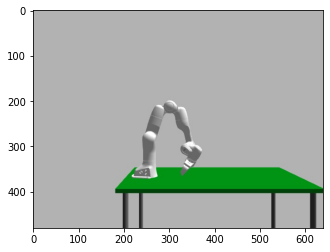

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[284.0767, 207.8247,   1.0000]],

        [[303.6946, 214.6245,   1.0000]],

        [[339.9445, 306.7547,   1.0000]],

        [[358.4302, 318.7351,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5658, 218.2285,   1.0000]],

        [[228.4683, 206.1239,   1.0000]],

        [[190.7981, 114.2544,   1.0000]],

        [[202.5320,  96.8696,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.1419, 207.1781,   1.0000]],

        [[301.9264, 213.4707,   1.0000]],

        [[400.9259, 216.9018,   1.0000]],

        [[420.7641, 206.3004,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.4034, 218.3675,   1.0000]],

        [[321.2711, 230.47

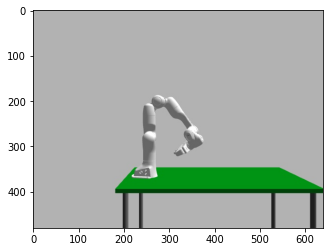

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.9743, 203.4139,   1.0000]],

        [[277.7443, 203.1464,   1.0000]],

        [[347.0496, 273.8359,   1.0000]],

        [[357.3836, 293.3824,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.6588, 207.0257,   1.0000]],

        [[301.4828, 213.1920,   1.0000]],

        [[396.3855, 241.6225,   1.0000]],

        [[418.8724, 243.3857,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3610, 207.6034,   1.0000]],

        [[252.0410, 200.9208,   1.0000]],

        [[216.9410, 108.2451,   1.0000]],

        [[196.5775,  96.9281,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.1302, 206.8629,   1.0000]],

        [[300.9964, 212.89

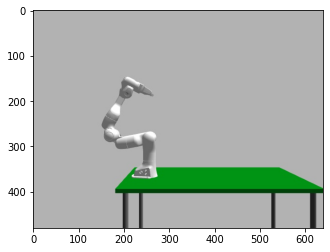

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.5986, 297.5023,   1.0000]],

        [[175.8018, 277.0580,   1.0000]],

        [[207.5607, 183.2697,   1.0000]],

        [[217.9626, 163.6560,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7204, 298.2307,   1.0000]],

        [[175.7270, 277.8223,   1.0000]],

        [[107.4588, 205.7969,   1.0000]],

        [[ 91.5024, 189.4843,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.0479, 203.4087,   1.0000]],

        [[278.8192, 203.4210,   1.0000]],

        [[365.2249, 155.0349,   1.0000]],

        [[376.7596, 135.5342,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.7475, 207.7112,   1.0000]],

        [[303.3950, 214.42

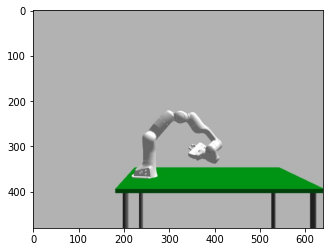

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.3635, 223.0992,   1.0000]],

        [[325.9909, 236.7619,   1.0000]],

        [[395.3514, 307.0435,   1.0000]],

        [[392.2926, 324.5185,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7908, 253.7475,   1.0000]],

        [[191.4153, 234.3996,   1.0000]],

        [[267.6039, 171.0688,   1.0000]],

        [[279.2466, 189.2027,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7011, 298.2402,   1.0000]],

        [[175.7013, 277.8305,   1.0000]],

        [[ 79.8936, 303.8316,   1.0000]],

        [[ 76.4729, 283.5546,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4401, 276.7904,   1.0000]],

        [[180.0409, 256.05

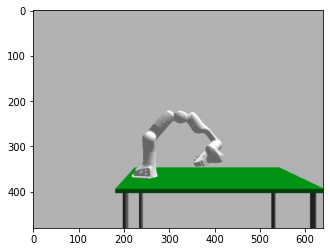

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.4185, 223.1474,   1.0000]],

        [[326.0334, 236.8245,   1.0000]],

        [[395.2840, 307.2155,   1.0000]],

        [[402.0999, 326.8994,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.5766, 207.0001,   1.0000]],

        [[301.4072, 213.1449,   1.0000]],

        [[385.5273, 265.4742,   1.0000]],

        [[407.3734, 262.2812,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5868, 218.2138,   1.0000]],

        [[228.4932, 206.1146,   1.0000]],

        [[190.8528, 114.2342,   1.0000]],

        [[191.6886,  92.4874,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.5104, 254.4305,   1.0000]],

        [[190.9506, 235.01

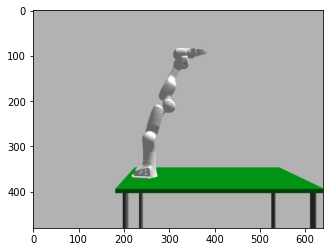

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.9458, 207.1182,   1.0000]],

        [[301.7477, 213.3616,   1.0000]],

        [[331.5754, 119.1549,   1.0000]],

        [[331.0078,  96.3119,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6792, 297.9702,   1.0000]],

        [[175.7567, 277.5490,   1.0000]],

        [[129.5558, 189.8171,   1.0000]],

        [[126.2744, 168.0287,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.3920, 219.0891,   1.0000]],

        [[322.0717, 231.4521,   1.0000]],

        [[420.2802, 244.0130,   1.0000]],

        [[437.2034, 229.7533,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7185, 298.2417,   1.0000]],

        [[175.7212, 277.83

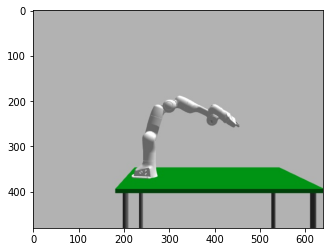

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.8151, 207.0747,   1.0000]],

        [[301.6264, 213.2818,   1.0000]],

        [[396.4130, 242.0924,   1.0000]],

        [[409.3896, 224.9459,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7335, 218.1112,   1.0000]],

        [[228.6686, 206.0507,   1.0000]],

        [[268.4958, 115.2038,   1.0000]],

        [[271.9411,  92.5992,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7045, 218.1313,   1.0000]],

        [[228.6332, 206.0629,   1.0000]],

        [[216.6546, 107.5103,   1.0000]],

        [[229.8502,  90.7677,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.7829, 223.4678,   1.0000]],

        [[326.3169, 237.23

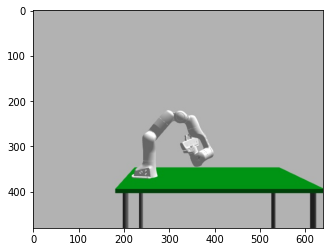

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.1322, 222.8977,   1.0000]],

        [[325.8129, 236.4999,   1.0000]],

        [[374.8953, 322.2690,   1.0000]],

        [[358.9488, 326.3286,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.8932, 203.4149,   1.0000]],

        [[277.6631, 203.1263,   1.0000]],

        [[347.1212, 273.6653,   1.0000]],

        [[368.2085, 279.8647,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.1191, 218.8876,   1.0000]],

        [[321.8513, 231.1792,   1.0000]],

        [[419.7230, 216.5372,   1.0000]],

        [[424.9364, 195.6452,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3436, 207.6090,   1.0000]],

        [[252.0213, 200.92

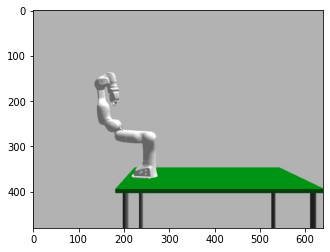

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4891, 276.3615,   1.0000]],

        [[180.2059, 255.6338,   1.0000]],

        [[157.1078, 159.1236,   1.0000]],

        [[179.7357, 158.2346,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6772, 297.7352,   1.0000]],

        [[175.8159, 277.3081,   1.0000]],

        [[230.4972, 194.7918,   1.0000]],

        [[247.0771, 208.8899,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.7348, 224.3260,   1.0000]],

        [[327.0452, 238.3447,   1.0000]],

        [[310.3715, 335.9382,   1.0000]],

        [[295.0921, 346.6888,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.3936, 207.2611,   1.0000]],

        [[302.1583, 213.62

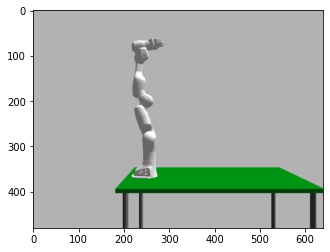

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3112, 207.6200,   1.0000]],

        [[251.9865, 200.9243,   1.0000]],

        [[242.6407, 102.2401,   1.0000]],

        [[238.8045,  79.7223,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3102, 207.6203,   1.0000]],

        [[251.9854, 200.9243,   1.0000]],

        [[242.6452, 102.2394,   1.0000]],

        [[235.1751,  80.3721,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.4296, 218.3290,   1.0000]],

        [[228.3100, 206.1898,   1.0000]],

        [[326.8472, 196.0433,   1.0000]],

        [[348.5969, 191.5264,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.3461, 254.8396,   1.0000]],

        [[190.6789, 235.37

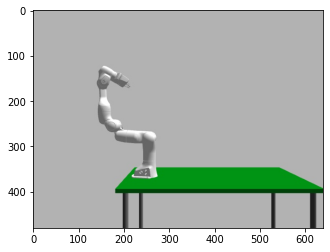

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4800, 276.4518,   1.0000]],

        [[180.1725, 255.7220,   1.0000]],

        [[156.9344, 159.2401,   1.0000]],

        [[167.1307, 140.0085,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5420, 275.8581,   1.0000]],

        [[180.3925, 255.1427,   1.0000]],

        [[111.8065, 183.2720,   1.0000]],

        [[128.6514, 169.0312,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.9585, 223.6247,   1.0000]],

        [[326.4485, 237.4426,   1.0000]],

        [[425.0819, 238.0940,   1.0000]],

        [[443.8310, 246.9871,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.1458, 206.8677,   1.0000]],

        [[301.0108, 212.89

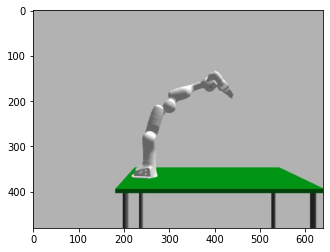

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.7400, 207.3715,   1.0000]],

        [[302.4744, 213.8205,   1.0000]],

        [[390.0593, 167.6583,   1.0000]],

        [[407.6949, 153.3854,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4399, 276.7948,   1.0000]],

        [[180.0397, 256.0566,   1.0000]],

        [[268.5817, 211.5405,   1.0000]],

        [[288.3518, 201.6891,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2433, 235.0894,   1.0000]],

        [[206.7415, 218.4688,   1.0000]],

        [[283.4934, 155.7717,   1.0000]],

        [[300.7917, 141.7050,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5797, 218.2214,   1.0000]],

        [[228.4876, 206.12

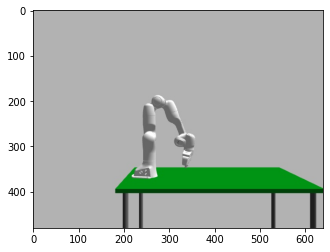

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.8458, 203.4155,   1.0000]],

        [[277.6155, 203.1145,   1.0000]],

        [[326.0334, 289.4542,   1.0000]],

        [[346.8433, 294.0883,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.9877, 207.7939,   1.0000]],

        [[303.6136, 214.5704,   1.0000]],

        [[340.0674, 306.6198,   1.0000]],

        [[337.4438, 328.1526,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7086, 298.2417,   1.0000]],

        [[175.7094, 277.8327,   1.0000]],

        [[ 76.3960, 277.3396,   1.0000]],

        [[ 54.1776, 273.7874,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7238, 218.1182,   1.0000]],

        [[228.6572, 206.05

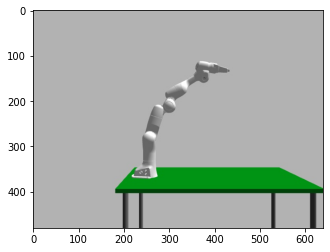

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.3140, 207.2354,   1.0000]],

        [[302.0853, 213.5749,   1.0000]],

        [[376.4050, 148.3055,   1.0000]],

        [[381.0244, 126.1484,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2437, 235.0934,   1.0000]],

        [[206.7422, 218.4726,   1.0000]],

        [[240.1361, 125.0650,   1.0000]],

        [[260.8251, 132.5875,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.2581, 218.4524,   1.0000]],

        [[228.1071, 206.2688,   1.0000]],

        [[318.3174, 247.1811,   1.0000]],

        [[338.3390, 240.1571,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.9247, 207.1092,   1.0000]],

        [[301.7271, 213.34

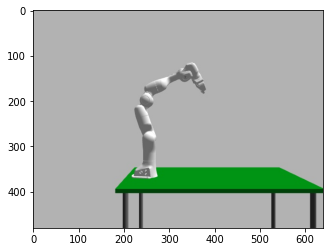

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.6101, 207.5195,   1.0000]],

        [[252.3102, 200.9009,   1.0000]],

        [[335.0328, 146.3593,   1.0000]],

        [[354.8748, 136.1118,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.2996, 254.9561,   1.0000]],

        [[190.6021, 235.4832,   1.0000]],

        [[ 95.4349, 206.7180,   1.0000]],

        [[ 80.6523, 191.3316,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7169, 298.2366,   1.0000]],

        [[175.7208, 277.8282,   1.0000]],

        [[ 90.7024, 226.5303,   1.0000]],

        [[ 96.0461, 205.9181,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6399, 297.7451,   1.0000]],

        [[175.7776, 277.31

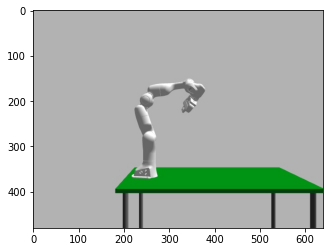

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.8480, 207.4404,   1.0000]],

        [[252.5684, 200.8837,   1.0000]],

        [[347.0076, 170.9796,   1.0000]],

        [[363.9655, 184.0907,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.3644, 219.0687,   1.0000]],

        [[322.0495, 231.4245,   1.0000]],

        [[420.2685, 243.9074,   1.0000]],

        [[434.3085, 227.1949,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.8090, 218.6607,   1.0000]],

        [[321.6004, 230.8712,   1.0000]],

        [[411.7502, 190.1920,   1.0000]],

        [[410.9841, 168.6811,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.0562, 207.1531,   1.0000]],

        [[301.8489, 213.42

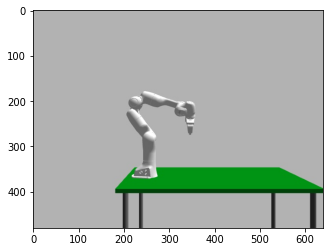

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.3124, 218.4133,   1.0000]],

        [[228.1713, 206.2437,   1.0000]],

        [[325.9563, 222.0545,   1.0000]],

        [[348.0657, 223.4847,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7115, 298.2407,   1.0000]],

        [[175.7132, 277.8319,   1.0000]],

        [[ 80.0743, 251.0094,   1.0000]],

        [[ 64.9483, 235.8801,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7776, 253.7882,   1.0000]],

        [[191.3916, 234.4365,   1.0000]],

        [[281.3524, 192.9368,   1.0000]],

        [[302.8170, 187.3054,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7166, 298.2398,   1.0000]],

        [[175.7195, 277.83

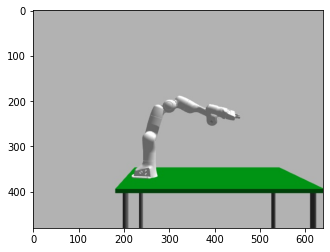

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.8662, 207.0908,   1.0000]],

        [[301.6734, 213.3113,   1.0000]],

        [[396.4216, 242.2467,   1.0000]],

        [[402.4288, 221.8989,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.8358, 207.4051,   1.0000]],

        [[302.5629, 213.8809,   1.0000]],

        [[400.0655, 196.8623,   1.0000]],

        [[415.5596, 180.5940,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2353, 235.1039,   1.0000]],

        [[206.7306, 218.4810,   1.0000]],

        [[240.1718, 125.0879,   1.0000]],

        [[256.8177, 110.7824,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.0607, 207.4772,   1.0000]],

        [[302.7676, 214.01

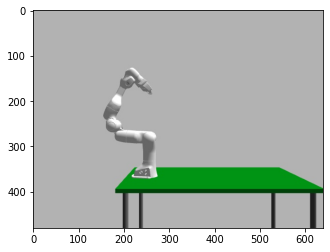

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4503, 276.7260,   1.0000]],

        [[180.0700, 255.9896,   1.0000]],

        [[209.0947, 161.2191,   1.0000]],

        [[225.1636, 146.0472,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.5767, 219.2265,   1.0000]],

        [[322.2205, 231.6379,   1.0000]],

        [[413.4726, 270.1516,   1.0000]],

        [[435.0944, 264.4039,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7265, 253.8996,   1.0000]],

        [[191.3079, 234.5355,   1.0000]],

        [[199.0130, 135.6146,   1.0000]],

        [[216.8418, 123.0721,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.2288, 213.2202,   1.0000]],

        [[314.4392, 223.19

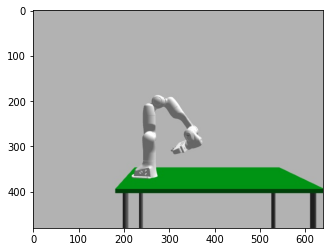

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.9871, 203.4138,   1.0000]],

        [[277.7571, 203.1495,   1.0000]],

        [[347.0380, 273.8630,   1.0000]],

        [[354.0166, 294.5825,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.1900, 207.5203,   1.0000]],

        [[302.8857, 214.0869,   1.0000]],

        [[331.6406, 119.5210,   1.0000]],

        [[334.2023,  96.8963,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7602, 298.1759,   1.0000]],

        [[175.8109, 277.7636,   1.0000]],

        [[250.5045, 212.8035,   1.0000]],

        [[269.9621, 222.5677,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.2529, 207.3078,   1.0000]],

        [[253.0074, 200.85

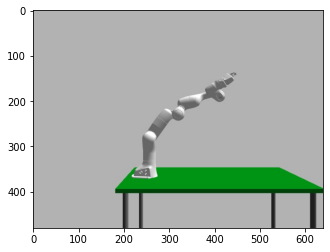

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.7460, 218.6149,   1.0000]],

        [[321.5493, 230.8089,   1.0000]],

        [[411.6263, 189.9671,   1.0000]],

        [[400.0565, 172.5208,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6065, 297.5489,   1.0000]],

        [[175.7970, 277.1070,   1.0000]],

        [[181.5126, 178.2290,   1.0000]],

        [[190.0212, 157.8014,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.4422, 254.6005,   1.0000]],

        [[190.8376, 235.1638,   1.0000]],

        [[106.9994, 181.6757,   1.0000]],

        [[ 93.3865, 164.4560,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3244, 234.9612,   1.0000]],

        [[206.8555, 218.36

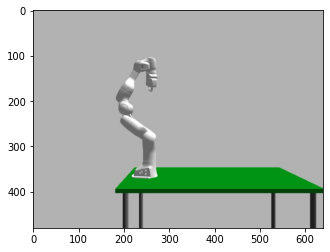

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2395, 235.0988,   1.0000]],

        [[206.7364, 218.4770,   1.0000]],

        [[240.1434, 125.0731,   1.0000]],

        [[261.9454, 125.0537,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.5661, 224.1726,   1.0000]],

        [[326.9126, 238.1487,   1.0000]],

        [[397.1919, 168.9472,   1.0000]],

        [[404.8752, 182.9711,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.7117, 219.3275,   1.0000]],

        [[322.3292, 231.7742,   1.0000]],

        [[413.4286, 270.6410,   1.0000]],

        [[418.6959, 250.3543,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7884, 253.7497,   1.0000]],

        [[191.4107, 234.40

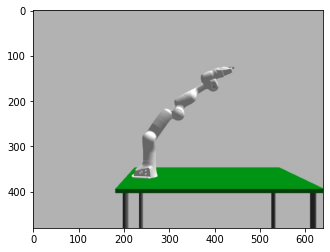

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.6155, 218.5204,   1.0000]],

        [[321.4434, 230.6801,   1.0000]],

        [[397.3098, 167.3296,   1.0000]],

        [[391.0450, 146.7331,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.1587, 206.8716,   1.0000]],

        [[301.0226, 212.9070,   1.0000]],

        [[347.6747, 300.2851,   1.0000]],

        [[362.2443, 317.3781,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.8547, 218.6940,   1.0000]],

        [[321.6374, 230.9164,   1.0000]],

        [[411.8400, 190.3556,   1.0000]],

        [[418.6318, 169.2793,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.5228, 223.2388,   1.0000]],

        [[326.1137, 236.94

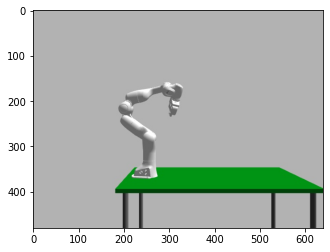

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2617, 235.0647,   1.0000]],

        [[206.7661, 218.4488,   1.0000]],

        [[297.4459, 178.5034,   1.0000]],

        [[318.6862, 184.1212,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[284.0114, 207.8020,   1.0000]],

        [[303.6352, 214.5849,   1.0000]],

        [[340.0350, 306.6558,   1.0000]],

        [[344.4553, 328.4808,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.6978, 207.3599,   1.0000]],

        [[302.4367, 213.7996,   1.0000]],

        [[391.8362, 171.3890,   1.0000]],

        [[408.2862, 155.7471,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4666, 276.5908,   1.0000]],

        [[180.1218, 255.85

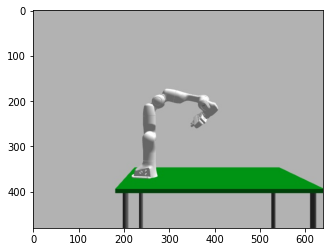

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.4225, 203.4100,   1.0000]],

        [[278.1935, 203.2592,   1.0000]],

        [[377.2133, 203.8989,   1.0000]],

        [[392.0183, 219.3642,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.1964, 206.8831,   1.0000]],

        [[301.0573, 212.9284,   1.0000]],

        [[369.0206, 285.0011,   1.0000]],

        [[389.3084, 294.4523,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7844, 253.7702,   1.0000]],

        [[191.4027, 234.4203,   1.0000]],

        [[281.4188, 193.0395,   1.0000]],

        [[297.3196, 207.5817,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.3068, 203.4096,   1.0000]],

        [[279.0777, 203.48

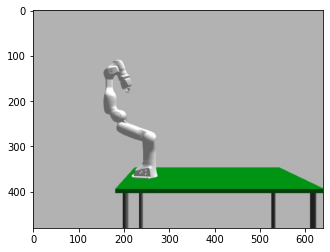

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.6867, 253.9973,   1.0000]],

        [[191.2418, 234.6230,   1.0000]],

        [[172.3586, 137.1316,   1.0000]],

        [[193.1021, 129.8998,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.3945, 207.2620,   1.0000]],

        [[253.1607, 200.8473,   1.0000]],

        [[323.7645, 270.2666,   1.0000]],

        [[342.1925, 282.5746,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.3323, 207.2820,   1.0000]],

        [[253.0934, 200.8512,   1.0000]],

        [[339.6631, 248.9229,   1.0000]],

        [[361.4577, 248.4967,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2219, 235.1208,   1.0000]],

        [[206.7122, 218.49

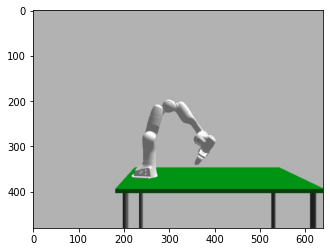

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.1799, 206.8781,   1.0000]],

        [[301.0422, 212.9191,   1.0000]],

        [[369.0355, 284.9634,   1.0000]],

        [[387.6450, 297.5721,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7934, 253.7389,   1.0000]],

        [[191.4191, 234.3918,   1.0000]],

        [[248.3789, 153.3024,   1.0000]],

        [[263.9041, 137.3791,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.6189, 275.1841,   1.0000]],

        [[180.6470, 254.4867,   1.0000]],

        [[ 85.3775, 226.3811,   1.0000]],

        [[ 96.6484, 207.7616,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7934, 253.7396,   1.0000]],

        [[191.4192, 234.39

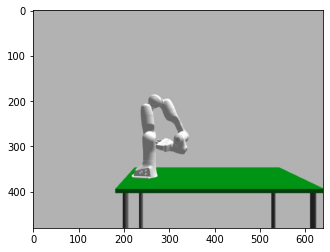

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.7321, 203.4171,   1.0000]],

        [[277.5016, 203.0866,   1.0000]],

        [[326.1844, 289.2765,   1.0000]],

        [[320.5516, 309.5949,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.6684, 234.5507,   1.0000]],

        [[207.3102, 218.0396,   1.0000]],

        [[124.5509, 163.1255,   1.0000]],

        [[126.4781, 142.6859,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.5285, 207.3025,   1.0000]],

        [[302.2808, 213.6963,   1.0000]],

        [[389.6122, 167.0536,   1.0000]],

        [[379.8368, 148.0074,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7700, 253.7945,   1.0000]],

        [[191.3801, 234.44

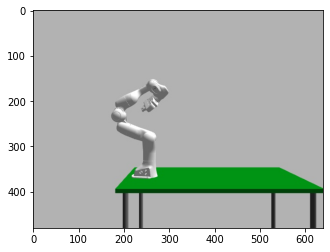

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7903, 253.7489,   1.0000]],

        [[191.4143, 234.4008,   1.0000]],

        [[267.6099, 171.0782,   1.0000]],

        [[282.2554, 186.9730,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6297, 218.1836,   1.0000]],

        [[228.5442, 206.0957,   1.0000]],

        [[190.9739, 114.1891,   1.0000]],

        [[174.3151,  97.5825,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7883, 253.7575,   1.0000]],

        [[191.4099, 234.4087,   1.0000]],

        [[281.4573, 193.0934,   1.0000]],

        [[287.9045, 213.1786,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.5900, 297.4503,   1.0000]],

        [[175.8075, 277.00

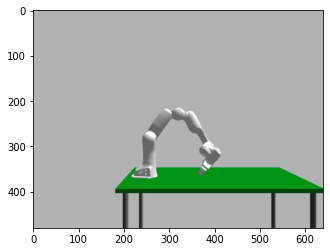

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.4489, 218.4003,   1.0000]],

        [[321.3081, 230.5175,   1.0000]],

        [[381.4399, 309.2538,   1.0000]],

        [[398.6515, 323.9963,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7307, 253.8896,   1.0000]],

        [[191.3148, 234.5265,   1.0000]],

        [[199.0281, 135.6069,   1.0000]],

        [[214.3329, 120.0376,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5188, 218.2616,   1.0000]],

        [[228.4127, 206.1448,   1.0000]],

        [[167.8470, 127.4925,   1.0000]],

        [[162.9480, 106.3739,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.2571, 223.8926,   1.0000]],

        [[326.6770, 237.78

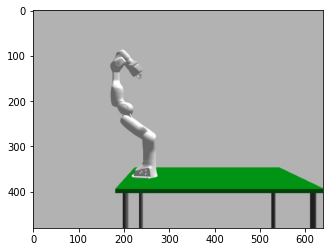

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3487, 234.9590,   1.0000]],

        [[206.8832, 218.3653,   1.0000]],

        [[187.9142, 120.8748,   1.0000]],

        [[204.4648, 107.2998,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.1408, 213.1721,   1.0000]],

        [[314.3638, 223.1212,   1.0000]],

        [[365.9160, 307.6353,   1.0000]],

        [[379.9569, 325.0831,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.6472, 203.4121,   1.0000]],

        [[279.4171, 203.5801,   1.0000]],

        [[280.2713, 104.6467,   1.0000]],

        [[263.9280,  88.7017,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.6844, 207.4947,   1.0000]],

        [[252.3908, 200.89

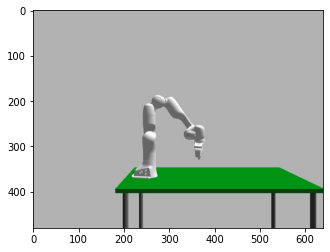

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.8753, 203.4151,   1.0000]],

        [[277.6451, 203.1218,   1.0000]],

        [[347.1368, 273.6277,   1.0000]],

        [[368.7136, 276.1676,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.9302, 223.5974,   1.0000]],

        [[326.4312, 237.4085,   1.0000]],

        [[323.8646, 336.3494,   1.0000]],

        [[308.1714, 331.6505,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2182, 235.1259,   1.0000]],

        [[206.7073, 218.4985,   1.0000]],

        [[263.7561, 137.4148,   1.0000]],

        [[281.8500, 124.6581,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.9066, 207.7658,   1.0000]],

        [[303.5398, 214.52

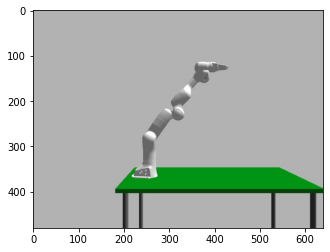

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.4203, 218.3797,   1.0000]],

        [[321.2849, 230.4884,   1.0000]],

        [[376.9869, 148.9214,   1.0000]],

        [[379.0897, 126.4193,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.2771, 223.0239,   1.0000]],

        [[325.9242, 236.6641,   1.0000]],

        [[374.5958, 322.6311,   1.0000]],

        [[358.6440, 326.5604,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.9808, 206.8177,   1.0000]],

        [[300.8588, 212.8067,   1.0000]],

        [[323.1426, 309.3041,   1.0000]],

        [[339.9085, 296.9832,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7082, 218.1295,   1.0000]],

        [[228.6390, 206.06

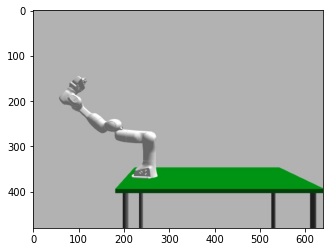

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5751, 275.5605,   1.0000]],

        [[180.5042, 254.8528,   1.0000]],

        [[ 95.6354, 203.1877,   1.0000]],

        [[ 78.3615, 188.7878,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.4944, 203.4096,   1.0000]],

        [[278.2655, 203.2776,   1.0000]],

        [[377.2839, 204.1057,   1.0000]],

        [[399.3994, 206.9874,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.9178, 218.7400,   1.0000]],

        [[321.6885, 230.9790,   1.0000]],

        [[411.9641, 190.5821,   1.0000]],

        [[428.2368, 174.7586,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.7393, 207.4764,   1.0000]],

        [[252.4505, 200.89

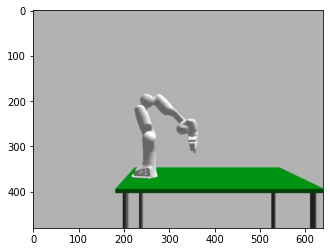

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.3600, 207.2731,   1.0000]],

        [[253.1233, 200.8494,   1.0000]],

        [[323.8039, 270.1905,   1.0000]],

        [[345.1237, 272.1205,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.0230, 207.1426,   1.0000]],

        [[301.8185, 213.4062,   1.0000]],

        [[331.8334, 119.2585,   1.0000]],

        [[347.1989, 104.1704,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.8799, 207.4174,   1.0000]],

        [[302.6024, 213.9030,   1.0000]],

        [[375.0684, 146.5104,   1.0000]],

        [[371.0522, 124.7240,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.7299, 207.3703,   1.0000]],

        [[302.4660, 213.81

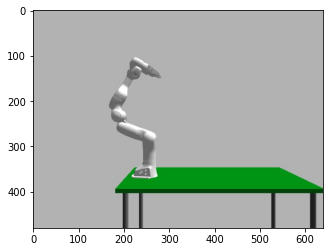

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7581, 253.8224,   1.0000]],

        [[191.3603, 234.4664,   1.0000]],

        [[225.0241, 141.2084,   1.0000]],

        [[235.8485, 121.7357,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6374, 297.7307,   1.0000]],

        [[175.7790, 277.2977,   1.0000]],

        [[154.8367, 180.4464,   1.0000]],

        [[175.5857, 172.2121,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.3683, 203.4103,   1.0000]],

        [[278.1392, 203.2454,   1.0000]],

        [[373.5309, 229.7751,   1.0000]],

        [[392.2247, 241.6062,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.6509, 274.9192,   1.0000]],

        [[180.7485, 254.22

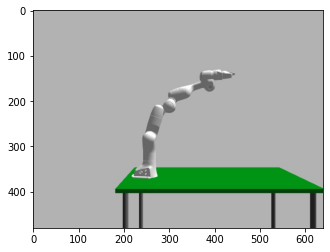

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.6109, 207.3293,   1.0000]],

        [[302.3563, 213.7446,   1.0000]],

        [[389.7867, 167.2891,   1.0000]],

        [[391.1586, 145.2520,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.1143, 206.8608,   1.0000]],

        [[300.9848, 212.8893,   1.0000]],

        [[322.3101, 309.5454,   1.0000]],

        [[343.0340, 312.6276,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6024, 297.5245,   1.0000]],

        [[175.7995, 277.0814,   1.0000]],

        [[181.5491, 178.2063,   1.0000]],

        [[182.5541, 155.8547,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.6445, 223.3461,   1.0000]],

        [[326.2074, 237.08

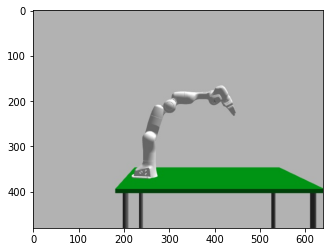

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.8888, 207.4226,   1.0000]],

        [[302.6114, 213.9122,   1.0000]],

        [[400.1367, 197.0276,   1.0000]],

        [[420.1760, 186.4974,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.5749, 224.1803,   1.0000]],

        [[326.9229, 238.1571,   1.0000]],

        [[310.5243, 335.7876,   1.0000]],

        [[295.3132, 346.7160,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.3977, 223.1292,   1.0000]],

        [[326.0173, 236.8009,   1.0000]],

        [[395.3097, 307.1504,   1.0000]],

        [[398.8447, 326.6490,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.0919, 207.4876,   1.0000]],

        [[302.7962, 214.02

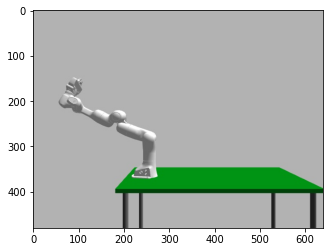

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.2805, 255.0040,   1.0000]],

        [[190.5705, 235.5263,   1.0000]],

        [[ 95.3711, 206.8575,   1.0000]],

        [[ 75.1872, 196.9408,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.4414, 203.4104,   1.0000]],

        [[279.2120, 203.5251,   1.0000]],

        [[329.8600, 118.4531,   1.0000]],

        [[326.7876,  95.7975,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.2612, 213.2380,   1.0000]],

        [[314.4672, 223.2191,   1.0000]],

        [[318.6640, 322.1216,   1.0000]],

        [[321.8024, 344.3492,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6486, 297.7963,   1.0000]],

        [[175.7726, 277.36

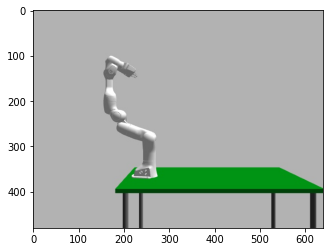

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.6671, 254.0451,   1.0000]],

        [[191.2094, 234.6658,   1.0000]],

        [[172.2570, 137.1845,   1.0000]],

        [[182.7710, 118.2382,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3209, 207.6167,   1.0000]],

        [[251.9967, 200.9233,   1.0000]],

        [[269.1934, 103.2916,   1.0000]],

        [[275.1396,  81.6291,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.4545, 234.8235,   1.0000]],

        [[207.0248, 218.2572,   1.0000]],

        [[163.1449, 129.1207,   1.0000]],

        [[160.5868, 107.2809,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6897, 218.1427,   1.0000]],

        [[228.6172, 206.07

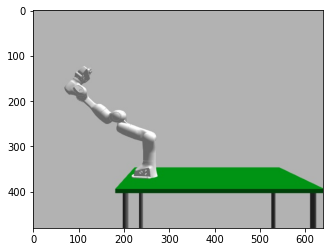

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.4514, 254.5777,   1.0000]],

        [[190.8528, 235.1433,   1.0000]],

        [[107.0414, 181.6161,   1.0000]],

        [[ 90.2762, 166.6308,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2723, 235.0576,   1.0000]],

        [[206.7800, 218.4441,   1.0000]],

        [[214.1943, 119.4574,   1.0000]],

        [[231.9533, 107.1440,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6959, 218.1382,   1.0000]],

        [[228.6246, 206.0680,   1.0000]],

        [[290.7154, 128.7769,   1.0000]],

        [[308.3494, 115.2765,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.9706, 219.5224,   1.0000]],

        [[322.5373, 232.03

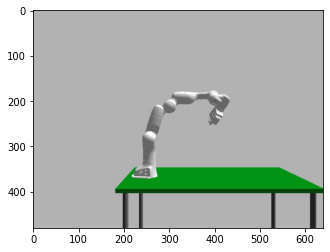

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.0290, 207.4690,   1.0000]],

        [[302.7395, 213.9952,   1.0000]],

        [[400.3245, 197.4642,   1.0000]],

        [[418.9687, 207.9533,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.9345, 206.8037,   1.0000]],

        [[300.8161, 212.7806,   1.0000]],

        [[323.2131, 309.2518,   1.0000]],

        [[339.9647, 296.9106,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.6046, 234.6318,   1.0000]],

        [[207.2253, 218.1043,   1.0000]],

        [[141.6578, 143.4620,   1.0000]],

        [[161.1356, 133.4702,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6218, 218.1892,   1.0000]],

        [[228.5348, 206.09

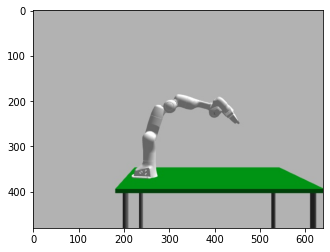

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.3002, 207.5595,   1.0000]],

        [[302.9872, 214.1566,   1.0000]],

        [[401.4230, 224.6397,   1.0000]],

        [[418.4905, 210.4962,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.8167, 223.4985,   1.0000]],

        [[326.3398, 237.2794,   1.0000]],

        [[421.4327, 263.5889,   1.0000]],

        [[437.2448, 277.0866,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4423, 276.7796,   1.0000]],

        [[180.0472, 256.0417,   1.0000]],

        [[233.2365, 172.4400,   1.0000]],

        [[249.9993, 186.5511,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.7046, 223.3991,   1.0000]],

        [[326.2536, 237.15

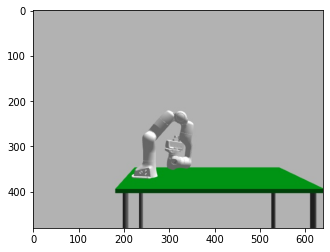

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.8610, 223.5364,   1.0000]],

        [[326.3775, 237.3288,   1.0000]],

        [[324.0228, 336.2741,   1.0000]],

        [[308.2937, 331.6448,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7258, 298.2398,   1.0000]],

        [[175.7311, 277.8319,   1.0000]],

        [[107.5506, 205.7415,   1.0000]],

        [[114.4703, 185.4164,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.4868, 203.4107,   1.0000]],

        [[279.2573, 203.5372,   1.0000]],

        [[305.8369, 108.1955,   1.0000]],

        [[300.5299,  85.7891,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7830, 253.7738,   1.0000]],

        [[191.4005, 234.42

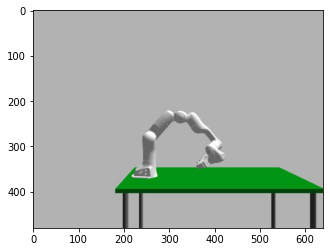

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.4373, 223.1638,   1.0000]],

        [[326.0478, 236.8458,   1.0000]],

        [[395.2607, 307.2739,   1.0000]],

        [[405.1375, 326.5618,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.8558, 223.5333,   1.0000]],

        [[326.3698, 237.3244,   1.0000]],

        [[421.4311, 263.7453,   1.0000]],

        [[441.6237, 273.1470,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.1367, 207.5048,   1.0000]],

        [[302.8379, 214.0592,   1.0000]],

        [[401.3184, 224.1275,   1.0000]],

        [[421.2254, 233.5236,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.6572, 234.5650,   1.0000]],

        [[207.2952, 218.05

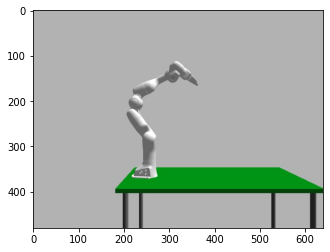

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6446, 218.1749,   1.0000]],

        [[228.5643, 206.0915,   1.0000]],

        [[308.6928, 147.7809,   1.0000]],

        [[322.6871, 130.1915,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.7053, 207.4877,   1.0000]],

        [[252.4135, 200.8939,   1.0000]],

        [[346.7189, 170.5713,   1.0000]],

        [[361.2714, 153.5826,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.8045, 203.4161,   1.0000]],

        [[277.5742, 203.1044,   1.0000]],

        [[326.0888, 289.3895,   1.0000]],

        [[342.7599, 303.9858,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.7107, 234.4972,   1.0000]],

        [[207.3664, 217.99

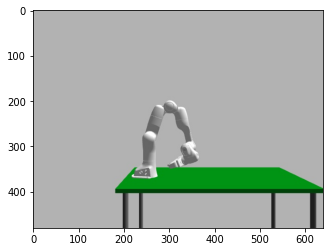

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[284.0224, 207.8058,   1.0000]],

        [[303.6452, 214.5915,   1.0000]],

        [[340.0200, 306.6724,   1.0000]],

        [[347.8714, 327.6816,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.5167, 254.4149,   1.0000]],

        [[190.9610, 234.9972,   1.0000]],

        [[124.4939, 161.0365,   1.0000]],

        [[127.8493, 140.2128,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.8323, 206.7733,   1.0000]],

        [[300.7225, 212.7244,   1.0000]],

        [[323.1441, 309.1805,   1.0000]],

        [[343.7450, 313.2536,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.5349, 207.3068,   1.0000]],

        [[302.2876, 213.70

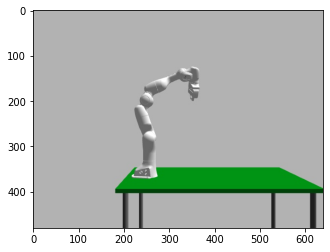

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.5657, 207.5343,   1.0000]],

        [[252.2620, 200.9042,   1.0000]],

        [[334.9076, 146.2462,   1.0000]],

        [[356.6698, 146.9492,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.6417, 207.5090,   1.0000]],

        [[252.3445, 200.8986,   1.0000]],

        [[335.1215, 146.4393,   1.0000]],

        [[350.7410, 130.1490,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.3116, 223.0539,   1.0000]],

        [[325.9508, 236.7031,   1.0000]],

        [[395.4139, 306.8823,   1.0000]],

        [[383.4621, 317.7881,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.3965, 203.4101,   1.0000]],

        [[279.1672, 203.51

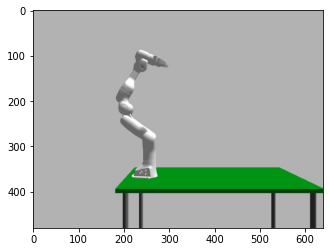

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2332, 235.1064,   1.0000]],

        [[206.7276, 218.4829,   1.0000]],

        [[240.1956, 125.0982,   1.0000]],

        [[247.7112, 103.8787,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.9673, 203.4086,   1.0000]],

        [[278.7387, 203.3999,   1.0000]],

        [[365.0404, 154.8281,   1.0000]],

        [[385.7525, 146.5126,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2865, 235.0315,   1.0000]],

        [[206.7989, 218.4220,   1.0000]],

        [[304.8566, 204.1589,   1.0000]],

        [[312.6377, 223.6989,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.6065, 203.4117,   1.0000]],

        [[279.3765, 203.56

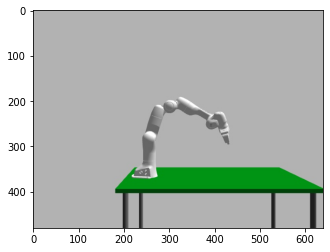

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.3455, 207.5748,   1.0000]],

        [[303.0284, 214.1837,   1.0000]],

        [[395.1292, 250.5025,   1.0000]],

        [[416.6874, 244.9324,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.5911, 254.2323,   1.0000]],

        [[191.0836, 234.8335,   1.0000]],

        [[146.7182, 145.8985,   1.0000]],

        [[159.1090, 128.4719,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3688, 207.6005,   1.0000]],

        [[252.0485, 200.9194,   1.0000]],

        [[294.7758, 111.4733,   1.0000]],

        [[311.7500,  97.6869,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7926, 253.7400,   1.0000]],

        [[191.4178, 234.39

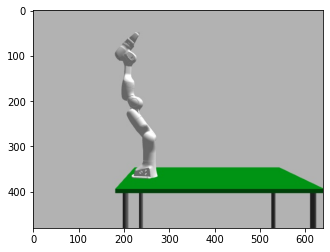

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6642, 218.1594,   1.0000]],

        [[228.5851, 206.0804,   1.0000]],

        [[216.5782, 107.5273,   1.0000]],

        [[199.0191,  91.9254,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.9174, 207.1092,   1.0000]],

        [[301.7216, 213.3452,   1.0000]],

        [[331.4807, 119.1169,   1.0000]],

        [[323.9158,  97.6916,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6931, 218.1392,   1.0000]],

        [[228.6196, 206.0678,   1.0000]],

        [[216.6400, 107.5142,   1.0000]],

        [[219.5185,  85.5071,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.0526, 206.8394,   1.0000]],

        [[300.9249, 212.84

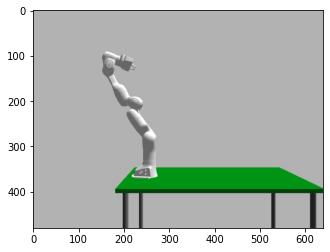

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5516, 218.2385,   1.0000]],

        [[228.4515, 206.1302,   1.0000]],

        [[167.9392, 127.4387,   1.0000]],

        [[174.6467, 107.8316,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.7917, 203.4086,   1.0000]],

        [[278.5630, 203.3541,   1.0000]],

        [[374.4833, 178.7363,   1.0000]],

        [[396.6230, 175.9905,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7900, 253.7495,   1.0000]],

        [[191.4136, 234.4014,   1.0000]],

        [[267.6279, 171.1010,   1.0000]],

        [[286.9373, 181.2080,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7199, 298.2394,   1.0000]],

        [[175.7236, 277.83

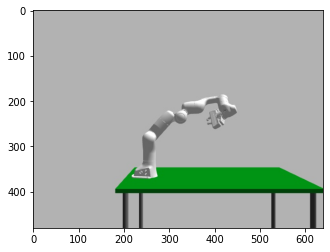

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.1818, 223.8248,   1.0000]],

        [[326.6194, 237.7008,   1.0000]],

        [[422.0948, 212.9956,   1.0000]],

        [[432.4128, 226.0237,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4415, 276.7868,   1.0000]],

        [[180.0443, 256.0488,   1.0000]],

        [[253.5163, 189.5685,   1.0000]],

        [[268.8971, 204.6759,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.1822, 203.4118,   1.0000]],

        [[277.9526, 203.1983,   1.0000]],

        [[363.2292, 253.4939,   1.0000]],

        [[384.8232, 250.1482,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.4087, 218.3440,   1.0000]],

        [[228.2853, 206.19

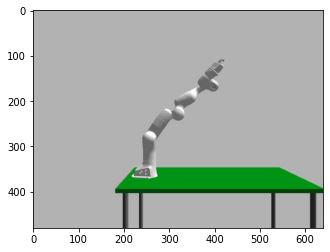

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.6761, 218.5642,   1.0000]],

        [[321.4926, 230.7399,   1.0000]],

        [[397.4671, 167.5194,   1.0000]],

        [[381.8574, 153.6330,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.3842, 207.2653,   1.0000]],

        [[253.1494, 200.8479,   1.0000]],

        [[323.7765, 270.2435,   1.0000]],

        [[343.7707, 279.3522,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4394, 276.7941,   1.0000]],

        [[180.0383, 256.0560,   1.0000]],

        [[268.6408, 211.6588,   1.0000]],

        [[275.9309, 231.2548,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.8011, 207.4559,   1.0000]],

        [[252.5176, 200.88

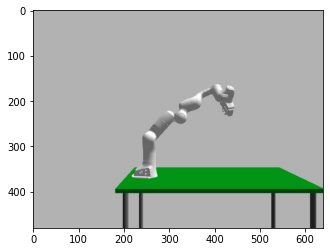

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.4073, 224.0284,   1.0000]],

        [[326.7916, 237.9631,   1.0000]],

        [[412.6503, 189.4503,   1.0000]],

        [[433.2784, 187.8354,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.6242, 254.1510,   1.0000]],

        [[191.1383, 234.7607,   1.0000]],

        [[146.9045, 145.7666,   1.0000]],

        [[140.2757, 124.3488,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.2148, 213.2125,   1.0000]],

        [[314.4272, 223.1809,   1.0000]],

        [[365.8211, 307.7922,   1.0000]],

        [[365.9793, 328.3168,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.2963, 223.9280,   1.0000]],

        [[326.7069, 237.83

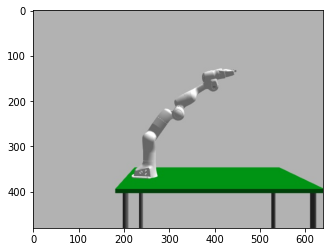

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.5968, 218.5068,   1.0000]],

        [[321.4283, 230.6617,   1.0000]],

        [[397.2610, 167.2709,   1.0000]],

        [[394.6133, 145.5842,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.7670, 218.6302,   1.0000]],

        [[321.5663, 230.8297,   1.0000]],

        [[411.6675, 190.0419,   1.0000]],

        [[403.4392, 170.6747,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.4620, 224.0780,   1.0000]],

        [[326.8333, 238.0269,   1.0000]],

        [[412.7730, 189.6596,   1.0000]],

        [[428.6138, 196.9238,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3417, 234.9680,   1.0000]],

        [[206.8737, 218.37

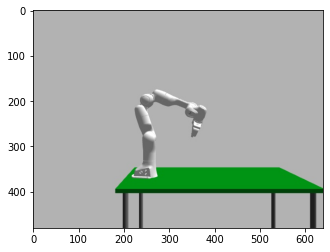

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.1173, 207.3519,   1.0000]],

        [[252.8606, 200.8652,   1.0000]],

        [[349.1131, 224.1478,   1.0000]],

        [[369.9587, 231.9253,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.7636, 223.4514,   1.0000]],

        [[326.2990, 237.2185,   1.0000]],

        [[421.4340, 263.3774,   1.0000]],

        [[427.6606, 279.9037,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.2419, 213.2273,   1.0000]],

        [[314.4504, 223.2028,   1.0000]],

        [[365.7870, 307.8494,   1.0000]],

        [[360.0252, 325.4894,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7199, 253.9157,   1.0000]],

        [[191.2969, 234.54

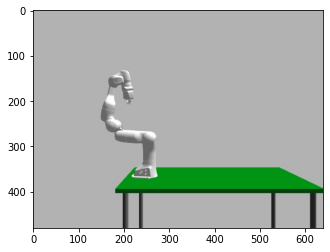

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4606, 276.6513,   1.0000]],

        [[180.0995, 255.9171,   1.0000]],

        [[183.0323, 156.7876,   1.0000]],

        [[205.1640, 154.2918,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.9364, 223.6051,   1.0000]],

        [[326.4316, 237.4172,   1.0000]],

        [[425.0659, 238.0025,   1.0000]],

        [[445.7070, 244.4468,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.9113, 207.4195,   1.0000]],

        [[252.6371, 200.8792,   1.0000]],

        [[351.6093, 197.1833,   1.0000]],

        [[373.1609, 202.3537,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6904, 298.0348,   1.0000]],

        [[175.7506, 277.61

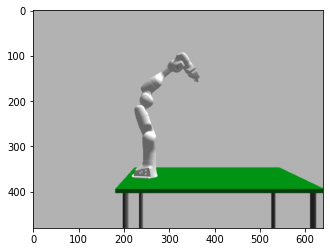

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.5003, 207.5563,   1.0000]],

        [[252.1910, 200.9092,   1.0000]],

        [[317.2180, 126.1144,   1.0000]],

        [[335.7473, 113.9837,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7206, 298.2402,   1.0000]],

        [[175.7242, 277.8321,   1.0000]],

        [[ 90.7636, 226.4589,   1.0000]],

        [[ 76.7467, 209.5814,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.8060, 207.3953,   1.0000]],

        [[302.5356, 213.8633,   1.0000]],

        [[400.0252, 196.7692,   1.0000]],

        [[412.4715, 178.2948,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5540, 218.2397,   1.0000]],

        [[228.4572, 206.13

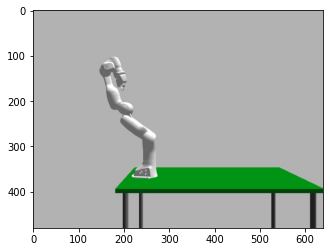

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3857, 234.9115,   1.0000]],

        [[206.9327, 218.3275,   1.0000]],

        [[162.9014, 129.2585,   1.0000]],

        [[184.4941, 124.3950,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.8777, 207.4306,   1.0000]],

        [[252.6006, 200.8816,   1.0000]],

        [[351.5688, 197.0827,   1.0000]],

        [[369.9463, 208.8195,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7187, 298.2400,   1.0000]],

        [[175.7220, 277.8318,   1.0000]],

        [[ 90.7243, 226.5075,   1.0000]],

        [[ 88.0121, 205.5981,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3994, 207.5902,   1.0000]],

        [[252.0816, 200.91

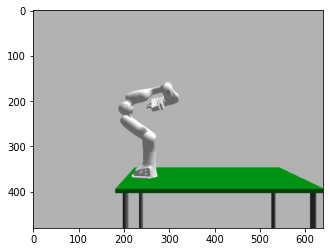

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2791, 235.0412,   1.0000]],

        [[206.7893, 218.4299,   1.0000]],

        [[297.5281, 178.6174,   1.0000]],

        [[303.4059, 198.9822,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.3647, 203.4099,   1.0000]],

        [[279.1355, 203.5047,   1.0000]],

        [[329.6045, 118.3267,   1.0000]],

        [[343.4798, 100.8270,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.1548, 213.1797,   1.0000]],

        [[314.3757, 223.1324,   1.0000]],

        [[365.8979, 307.6649,   1.0000]],

        [[377.6290, 326.9462,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5081, 276.1779,   1.0000]],

        [[180.2737, 255.45

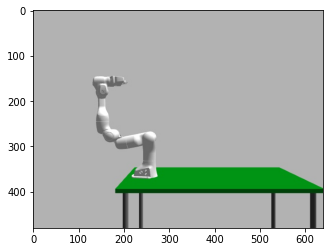

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6576, 297.8488,   1.0000]],

        [[175.7675, 277.4215,   1.0000]],

        [[154.6284, 180.6072,   1.0000]],

        [[153.2975, 158.3623,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2727, 235.0501,   1.0000]],

        [[206.7807, 218.4370,   1.0000]],

        [[297.4973, 178.5750,   1.0000]],

        [[310.0625, 195.8692,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.1977, 213.2031,   1.0000]],

        [[314.4125, 223.1671,   1.0000]],

        [[365.8429, 307.7559,   1.0000]],

        [[369.0746, 328.8919,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6301, 297.6882,   1.0000]],

        [[175.7832, 277.25

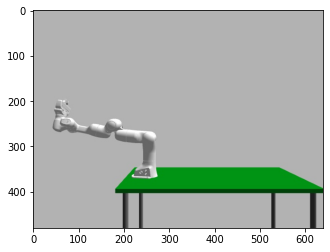

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.6548, 274.8872,   1.0000]],

        [[180.7608, 254.1984,   1.0000]],

        [[ 81.5245, 251.5494,   1.0000]],

        [[ 59.3646, 247.6147,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.0176, 207.4629,   1.0000]],

        [[302.7282, 213.9845,   1.0000]],

        [[355.1578, 130.1212,   1.0000]],

        [[335.7716, 121.5438,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.1257, 213.1638,   1.0000]],

        [[314.3508, 223.1090,   1.0000]],

        [[365.9358, 307.6031,   1.0000]],

        [[381.8739, 322.6846,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.5915, 297.4593,   1.0000]],

        [[175.8065, 277.01

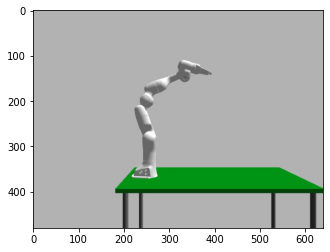

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.6834, 207.4950,   1.0000]],

        [[252.3898, 200.8955,   1.0000]],

        [[335.2386, 146.5452,   1.0000]],

        [[341.2455, 124.8061,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.4043, 207.2588,   1.0000]],

        [[253.1712, 200.8466,   1.0000]],

        [[323.7529, 270.2886,   1.0000]],

        [[340.0771, 285.4124,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.6331, 234.5955,   1.0000]],

        [[207.2632, 218.0753,   1.0000]],

        [[124.4445, 163.2458,   1.0000]],

        [[137.4998, 146.6212,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.2852, 203.4109,   1.0000]],

        [[278.0560, 203.22

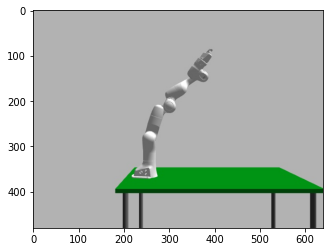

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.9558, 207.4425,   1.0000]],

        [[302.6718, 213.9479,   1.0000]],

        [[375.2699, 146.6979,   1.0000]],

        [[358.6969, 133.3736,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.4599, 218.3030,   1.0000]],

        [[228.3430, 206.1709,   1.0000]],

        [[167.6751, 127.5942,   1.0000]],

        [[147.2799, 115.7557,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.4455, 219.1288,   1.0000]],

        [[322.1148, 231.5059,   1.0000]],

        [[420.3029, 244.2182,   1.0000]],

        [[441.3645, 236.0504,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2857, 235.0405,   1.0000]],

        [[206.7982, 218.43

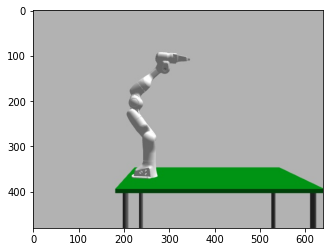

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6675, 218.1585,   1.0000]],

        [[228.5911, 206.0810,   1.0000]],

        [[290.5746, 128.7052,   1.0000]],

        [[292.2731, 105.9655,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.3099, 254.9303,   1.0000]],

        [[190.6191, 235.4600,   1.0000]],

        [[ 95.4691, 206.6434,   1.0000]],

        [[ 84.0650, 189.1792,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7014, 298.0981,   1.0000]],

        [[175.7447, 277.6832,   1.0000]],

        [[129.3294, 190.0562,   1.0000]],

        [[147.2994, 177.0144,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.1798, 218.2097,   1.0000]],

        [[321.0876, 230.25

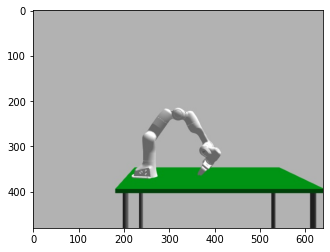

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.3916, 218.3596,   1.0000]],

        [[321.2612, 230.4617,   1.0000]],

        [[381.3829, 309.1876,   1.0000]],

        [[398.6571, 323.8496,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.6759, 254.0235,   1.0000]],

        [[191.2241, 234.6464,   1.0000]],

        [[172.3029, 137.1606,   1.0000]],

        [[188.9370, 123.3169,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.6365, 275.0367,   1.0000]],

        [[180.7033, 254.3435,   1.0000]],

        [[ 81.4505, 251.9958,   1.0000]],

        [[ 72.2698, 234.0528,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.5326, 207.5454,   1.0000]],

        [[252.2261, 200.90

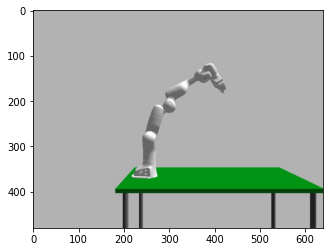

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.4181, 207.2690,   1.0000]],

        [[302.1806, 213.6356,   1.0000]],

        [[376.6762, 148.5672,   1.0000]],

        [[395.5742, 136.8087,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7245, 298.2309,   1.0000]],

        [[175.7323, 277.8226,   1.0000]],

        [[107.5724, 205.7148,   1.0000]],

        [[118.2166, 186.8417,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.1790, 207.3317,   1.0000]],

        [[252.9274, 200.8611,   1.0000]],

        [[349.1352, 224.3284,   1.0000]],

        [[360.4466, 242.6084,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.5927, 297.4661,   1.0000]],

        [[175.8058, 277.02

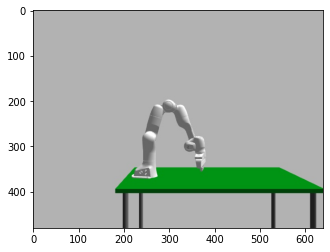

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.0849, 206.8492,   1.0000]],

        [[300.9547, 212.8654,   1.0000]],

        [[347.7690, 300.1566,   1.0000]],

        [[369.0336, 300.7357,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7935, 253.7388,   1.0000]],

        [[191.4193, 234.3917,   1.0000]],

        [[248.3676, 153.2945,   1.0000]],

        [[260.9686, 134.8793,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[295.9829, 213.0834,   1.0000]],

        [[314.2302, 222.9928,   1.0000]],

        [[320.8854, 321.7840,   1.0000]],

        [[310.2915, 338.5042,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5996, 218.2071,   1.0000]],

        [[228.5111, 206.11

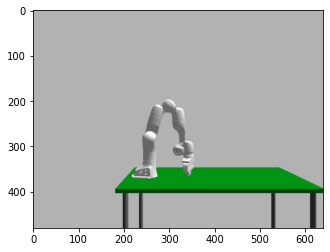

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.8676, 206.7836,   1.0000]],

        [[300.7544, 212.7430,   1.0000]],

        [[323.3147, 309.1759,   1.0000]],

        [[344.0911, 309.7568,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.2719, 218.2747,   1.0000]],

        [[321.1631, 230.3453,   1.0000]],

        [[381.2679, 309.0492,   1.0000]],

        [[398.6570, 323.5613,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.2582, 203.4094,   1.0000]],

        [[279.0293, 203.4764,   1.0000]],

        [[349.9514, 134.3680,   1.0000]],

        [[370.7555, 127.9029,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.2300, 207.5360,   1.0000]],

        [[302.9231, 214.11

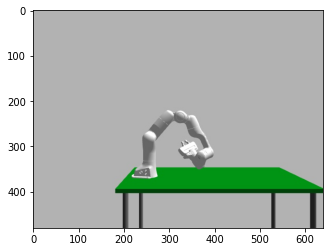

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.0603, 222.8354,   1.0000]],

        [[325.7575, 236.4187,   1.0000]],

        [[375.0326, 322.0890,   1.0000]],

        [[361.5105, 331.1647,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.6131, 203.4117,   1.0000]],

        [[279.3831, 203.5710,   1.0000]],

        [[280.1330, 104.6368,   1.0000]],

        [[283.5940,  82.5949,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.4863, 218.2883,   1.0000]],

        [[228.3771, 206.1638,   1.0000]],

        [[326.9376, 196.2416,   1.0000]],

        [[340.8314, 179.4807,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2382, 235.1004,   1.0000]],

        [[206.7346, 218.47

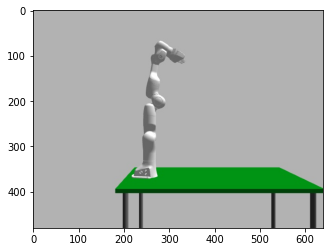

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.5985, 203.4116,   1.0000]],

        [[279.3685, 203.5671,   1.0000]],

        [[280.0757, 104.6326,   1.0000]],

        [[290.2821,  85.6481,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[309.9804, 222.7664,   1.0000]],

        [[325.6956, 236.3289,   1.0000]],

        [[375.1580, 321.8890,   1.0000]],

        [[375.0507, 342.2417,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.4528, 223.1774,   1.0000]],

        [[326.0598, 236.8635,   1.0000]],

        [[395.2412, 307.3225,   1.0000]],

        [[407.9157, 325.6439,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6849, 218.1449,   1.0000]],

        [[228.6098, 206.07

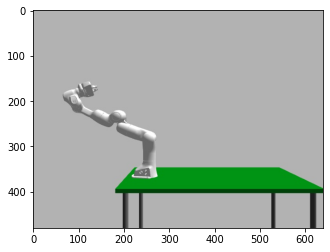

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.3189, 254.9076,   1.0000]],

        [[190.6340, 235.4396,   1.0000]],

        [[ 95.4992, 206.5782,   1.0000]],

        [[ 87.7892, 187.5592,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7271, 218.1158,   1.0000]],

        [[228.6610, 206.0536,   1.0000]],

        [[268.4492, 115.1904,   1.0000]],

        [[278.9169,  95.3310,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.8546, 203.4086,   1.0000]],

        [[278.6259, 203.3705,   1.0000]],

        [[374.5869, 178.9126,   1.0000]],

        [[394.6420, 187.0258,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.9473, 207.4076,   1.0000]],

        [[252.6762, 200.87

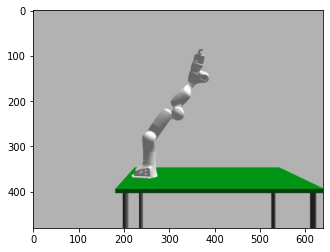

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.2765, 218.2767,   1.0000]],

        [[321.1679, 230.3477,   1.0000]],

        [[376.5431, 148.5594,   1.0000]],

        [[356.4646, 143.0444,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.6844, 223.3813,   1.0000]],

        [[326.2382, 237.1278,   1.0000]],

        [[421.4342, 263.0638,   1.0000]],

        [[413.1800, 277.1393,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6869, 298.0149,   1.0000]],

        [[175.7524, 277.5959,   1.0000]],

        [[129.4760, 189.9008,   1.0000]],

        [[134.1804, 168.7243,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.2806, 218.4362,   1.0000]],

        [[228.1337, 206.25

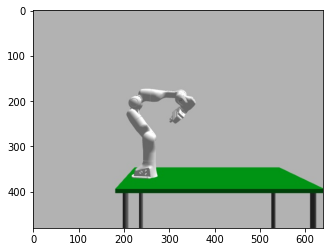

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.3729, 218.3698,   1.0000]],

        [[228.2429, 206.2159,   1.0000]],

        [[326.7556, 195.8369,   1.0000]],

        [[342.0060, 211.0771,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.8963, 218.7243,   1.0000]],

        [[321.6711, 230.9577,   1.0000]],

        [[411.9218, 190.5049,   1.0000]],

        [[425.4117, 172.3704,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.5939, 297.4738,   1.0000]],

        [[175.8050, 277.0282,   1.0000]],

        [[207.5821, 183.2469,   1.0000]],

        [[228.0743, 174.8120,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.6232, 207.5151,   1.0000]],

        [[252.3244, 200.89

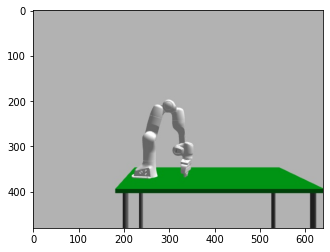

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.0367, 206.8366,   1.0000]],

        [[300.9127, 212.8438,   1.0000]],

        [[322.5405, 309.4464,   1.0000]],

        [[343.2030, 313.1030,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3089, 207.6208,   1.0000]],

        [[251.9840, 200.9244,   1.0000]],

        [[242.6472, 102.2390,   1.0000]],

        [[231.7455,  81.6729,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.4907, 219.1624,   1.0000]],

        [[322.1512, 231.5513,   1.0000]],

        [[420.3221, 244.3911,   1.0000]],

        [[442.9768, 243.2177,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.8521, 219.4330,   1.0000]],

        [[322.4421, 231.91

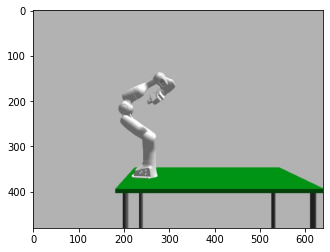

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2206, 235.1201,   1.0000]],

        [[206.7113, 218.4936,   1.0000]],

        [[283.3308, 155.6366,   1.0000]],

        [[297.5683, 171.9028,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5424, 218.2450,   1.0000]],

        [[228.4406, 206.1343,   1.0000]],

        [[167.9135, 127.4536,   1.0000]],

        [[170.8197, 106.7363,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.3169, 223.9465,   1.0000]],

        [[326.7226, 237.8577,   1.0000]],

        [[422.2970, 213.5499,   1.0000]],

        [[444.4288, 208.9330,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7915, 253.7422,   1.0000]],

        [[191.4160, 234.39

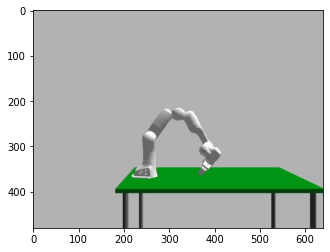

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.3619, 218.3385,   1.0000]],

        [[321.2369, 230.4328,   1.0000]],

        [[381.3542, 309.1539,   1.0000]],

        [[398.6535, 323.7832,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7905, 253.7480,   1.0000]],

        [[191.4143, 234.4000,   1.0000]],

        [[267.6491, 171.1240,   1.0000]],

        [[289.4261, 174.1950,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.2803, 207.2989,   1.0000]],

        [[253.0371, 200.8545,   1.0000]],

        [[339.6839, 248.7871,   1.0000]],

        [[359.5479, 258.8150,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.6550, 207.5045,   1.0000]],

        [[252.3589, 200.89

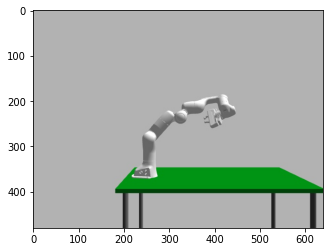

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.1646, 223.8093,   1.0000]],

        [[326.6063, 237.6809,   1.0000]],

        [[422.0689, 212.9254,   1.0000]],

        [[428.9723, 227.4306,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.5064, 219.1741,   1.0000]],

        [[322.1639, 231.5671,   1.0000]],

        [[413.4942, 269.8978,   1.0000]],

        [[435.6490, 274.7657,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.1505, 207.1831,   1.0000]],

        [[301.9354, 213.4799,   1.0000]],

        [[356.0805, 130.7590,   1.0000]],

        [[370.9669, 114.2079,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.4057, 207.2628,   1.0000]],

        [[302.1683, 213.62

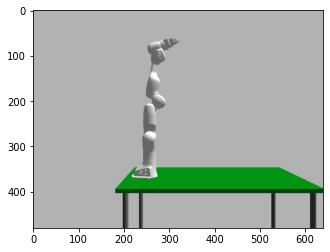

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.6315, 203.4119,   1.0000]],

        [[279.4015, 203.5759,   1.0000]],

        [[280.2062, 104.6421,   1.0000]],

        [[272.8900,  82.7848,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7754, 253.7942,   1.0000]],

        [[191.3879, 234.4419,   1.0000]],

        [[281.3343, 192.9113,   1.0000]],

        [[301.5307, 183.8212,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.7884, 218.6457,   1.0000]],

        [[321.5837, 230.8508,   1.0000]],

        [[411.7096, 190.1183,   1.0000]],

        [[407.1422, 169.3666,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.5994, 207.3277,   1.0000]],

        [[302.3466, 213.74

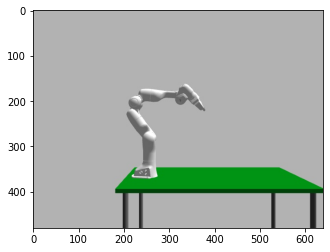

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.4652, 218.3035,   1.0000]],

        [[228.3522, 206.1735,   1.0000]],

        [[326.9040, 196.1681,   1.0000]],

        [[343.5797, 181.9606,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.5748, 223.2846,   1.0000]],

        [[326.1538, 237.0025,   1.0000]],

        [[411.2834, 286.9518,   1.0000]],

        [[416.4548, 304.9530,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7366, 253.8754,   1.0000]],

        [[191.3246, 234.5138,   1.0000]],

        [[199.0494, 135.5963,   1.0000]],

        [[208.0046, 115.3862,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.2650, 207.3038,   1.0000]],

        [[253.0205, 200.85

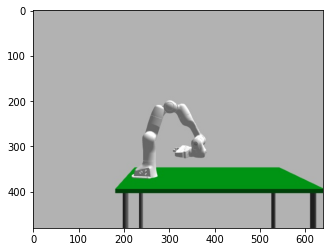

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.9347, 207.7756,   1.0000]],

        [[303.5654, 214.5383,   1.0000]],

        [[363.2044, 293.5679,   1.0000]],

        [[362.6725, 314.9320,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.2391, 218.4662,   1.0000]],

        [[228.0845, 206.2776,   1.0000]],

        [[318.3270, 247.1188,   1.0000]],

        [[340.0720, 247.2007,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.1089, 203.4088,   1.0000]],

        [[278.8801, 203.4370,   1.0000]],

        [[349.5235, 134.0438,   1.0000]],

        [[348.2960, 111.4853,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7062, 297.8342,   1.0000]],

        [[175.8177, 277.41

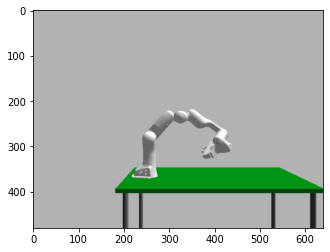

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.5574, 223.2693,   1.0000]],

        [[326.1404, 236.9827,   1.0000]],

        [[411.2953, 286.8889,   1.0000]],

        [[419.8486, 304.7390,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.2745, 207.5485,   1.0000]],

        [[302.9629, 214.1372,   1.0000]],

        [[331.9218, 119.6332,   1.0000]],

        [[313.3775, 108.6507,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.9346, 207.4377,   1.0000]],

        [[302.6533, 213.9393,   1.0000]],

        [[400.1982, 197.1703,   1.0000]],

        [[422.3759, 193.5852,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.2069, 222.9627,   1.0000]],

        [[325.8704, 236.58

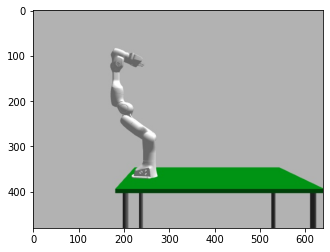

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3298, 234.9833,   1.0000]],

        [[206.8576, 218.3848,   1.0000]],

        [[187.8548, 120.8987,   1.0000]],

        [[194.9285, 100.3485,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[284.0471, 207.8144,   1.0000]],

        [[303.6676, 214.6065,   1.0000]],

        [[339.9858, 306.7097,   1.0000]],

        [[353.9544, 324.2512,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.5974, 254.2168,   1.0000]],

        [[191.0940, 234.8196,   1.0000]],

        [[146.7534, 145.8734,   1.0000]],

        [[155.6623, 126.4569,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.9956, 206.8221,   1.0000]],

        [[300.8724, 212.81

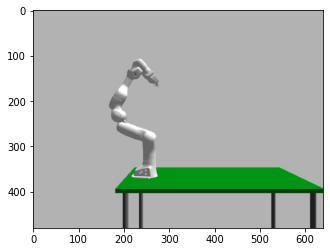

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7616, 253.8143,   1.0000]],

        [[191.3661, 234.4591,   1.0000]],

        [[225.0207, 141.1987,   1.0000]],

        [[241.6752, 126.7722,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.4928, 218.4319,   1.0000]],

        [[321.3438, 230.5595,   1.0000]],

        [[396.9886, 166.9444,   1.0000]],

        [[411.2641, 149.3271,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4397, 276.7932,   1.0000]],

        [[180.0389, 256.0551,   1.0000]],

        [[268.6366, 211.6486,   1.0000]],

        [[279.3137, 229.8155,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2840, 235.0348,   1.0000]],

        [[206.7956, 218.42

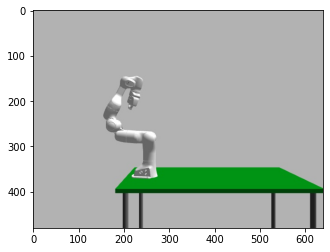

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4549, 276.6785,   1.0000]],

        [[180.0877, 255.9431,   1.0000]],

        [[209.1416, 161.1836,   1.0000]],

        [[230.5273, 167.2717,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.6436, 234.5822,   1.0000]],

        [[207.2771, 218.0647,   1.0000]],

        [[124.4760, 163.2103,   1.0000]],

        [[134.0639, 144.7669,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.5928, 223.3004,   1.0000]],

        [[326.1676, 237.0230,   1.0000]],

        [[411.2712, 287.0170,   1.0000]],

        [[412.9219, 304.6489,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.0997, 207.3576,   1.0000]],

        [[252.8414, 200.86

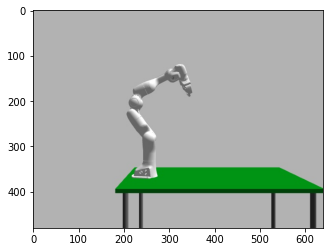

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6166, 218.1949,   1.0000]],

        [[228.5312, 206.1043,   1.0000]],

        [[308.5886, 147.6968,   1.0000]],

        [[329.0726, 139.1211,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.2662, 213.2407,   1.0000]],

        [[314.4713, 223.2225,   1.0000]],

        [[341.4994, 318.4635,   1.0000]],

        [[329.3151, 331.0428,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.8722, 219.4481,   1.0000]],

        [[322.4583, 231.9369,   1.0000]],

        [[399.7341, 293.9307,   1.0000]],

        [[420.4510, 287.2234,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.8941, 223.5694,   1.0000]],

        [[326.3992, 237.36

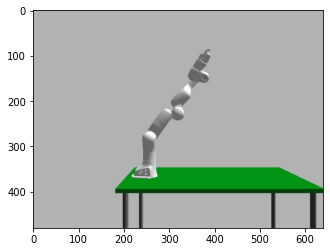

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.3059, 218.2977,   1.0000]],

        [[321.1918, 230.3764,   1.0000]],

        [[376.6330, 148.6327,   1.0000]],

        [[359.8628, 136.0178,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2786, 235.0495,   1.0000]],

        [[206.7886, 218.4377,   1.0000]],

        [[214.2032, 119.4519,   1.0000]],

        [[226.5447, 101.4285,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2817, 235.0378,   1.0000]],

        [[206.7927, 218.4271,   1.0000]],

        [[304.8440, 204.1206,   1.0000]],

        [[305.2975, 224.8608,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.4842, 207.2903,   1.0000]],

        [[302.2412, 213.67

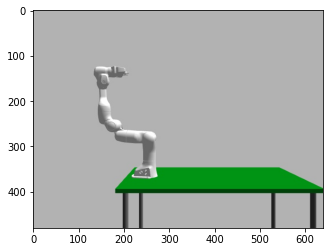

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4754, 276.4975,   1.0000]],

        [[180.1556, 255.7667,   1.0000]],

        [[156.8461, 159.2991,   1.0000]],

        [[155.6478, 137.0264,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.6757, 207.3526,   1.0000]],

        [[302.4165, 213.7866,   1.0000]],

        [[391.7917, 171.3247,   1.0000]],

        [[410.4709, 158.5373,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.1423, 218.9046,   1.0000]],

        [[321.8701, 231.2023,   1.0000]],

        [[419.7511, 216.6256,   1.0000]],

        [[421.1629, 195.4091,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5270, 218.2591,   1.0000]],

        [[228.4253, 206.14

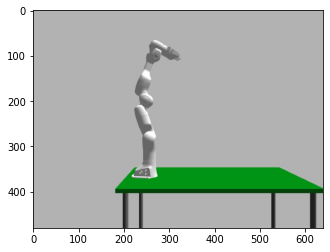

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3267, 207.6147,   1.0000]],

        [[252.0030, 200.9228,   1.0000]],

        [[269.2246, 103.2953,   1.0000]],

        [[278.6196,  83.2532,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.8047, 219.3973,   1.0000]],

        [[322.4040, 231.8684,   1.0000]],

        [[399.8001, 293.7138,   1.0000]],

        [[413.5541, 277.8067,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[309.9938, 222.7779,   1.0000]],

        [[325.7060, 236.3439,   1.0000]],

        [[375.1370, 321.9225,   1.0000]],

        [[371.9644, 340.9835,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.6852, 219.3077,   1.0000]],

        [[322.3079, 231.74

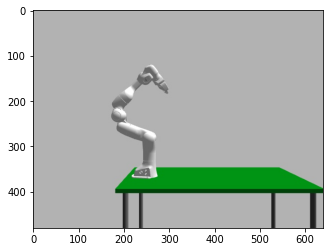

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7932, 253.7391,   1.0000]],

        [[191.4187, 234.3919,   1.0000]],

        [[248.3916, 153.3114,   1.0000]],

        [[266.3669, 140.3386,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.2003, 223.8415,   1.0000]],

        [[326.6336, 237.7223,   1.0000]],

        [[422.1227, 213.0713,   1.0000]],

        [[435.5769, 224.2426,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.6432, 203.4120,   1.0000]],

        [[279.4131, 203.5791,   1.0000]],

        [[280.2544, 104.6455,   1.0000]],

        [[266.5560,  86.1530,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.6068, 203.4091,   1.0000]],

        [[278.3780, 203.30

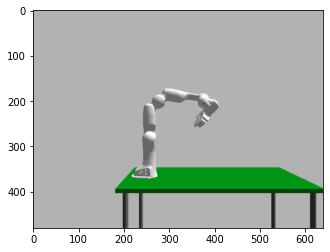

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.4392, 203.4099,   1.0000]],

        [[278.2102, 203.2635,   1.0000]],

        [[377.2298, 203.9470,   1.0000]],

        [[394.7336, 216.7124,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2900, 235.0268,   1.0000]],

        [[206.8036, 218.4183,   1.0000]],

        [[304.8656, 204.1848,   1.0000]],

        [[316.0367, 222.2603,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.0341, 206.8338,   1.0000]],

        [[300.9079, 212.8367,   1.0000]],

        [[347.8345, 300.0675,   1.0000]],

        [[365.8071, 289.6386,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6974, 298.0753,   1.0000]],

        [[175.7468, 277.65

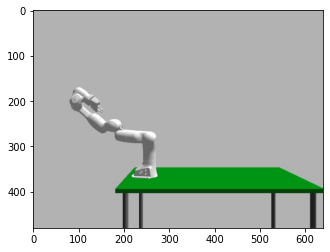

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5497, 275.7855,   1.0000]],

        [[180.4193, 255.0718,   1.0000]],

        [[ 95.3108, 203.7724,   1.0000]],

        [[111.0974, 188.2101,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6714, 297.9247,   1.0000]],

        [[175.7611, 277.5013,   1.0000]],

        [[129.6383, 189.7316,   1.0000]],

        [[118.7217, 169.8601,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.9679, 206.8138,   1.0000]],

        [[300.8469, 212.7994,   1.0000]],

        [[323.1622, 309.2896,   1.0000]],

        [[339.9245, 296.9635,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.5962, 297.4873,   1.0000]],

        [[175.8035, 277.04

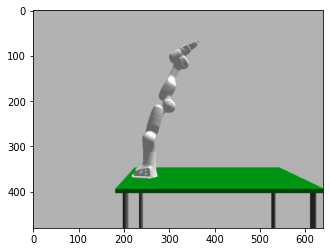

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.9040, 207.1050,   1.0000]],

        [[301.7093, 213.3375,   1.0000]],

        [[331.4361, 119.0990,   1.0000]],

        [[320.6167,  99.3564,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.5511, 207.6443,   1.0000]],

        [[303.2160, 214.3069,   1.0000]],

        [[395.1236, 251.1092,   1.0000]],

        [[402.1078, 271.0364,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7468, 253.8654,   1.0000]],

        [[191.3439, 234.5058,   1.0000]],

        [[289.0320, 217.9345,   1.0000]],

        [[293.9021, 238.1239,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.2432, 218.2544,   1.0000]],

        [[321.1396, 230.31

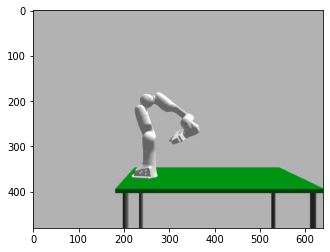

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.2280, 207.3159,   1.0000]],

        [[252.9804, 200.8579,   1.0000]],

        [[339.7061, 248.6472,   1.0000]],

        [[349.4182, 268.0390,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.2607, 207.2183,   1.0000]],

        [[302.0364, 213.5439,   1.0000]],

        [[356.4170, 130.9774,   1.0000]],

        [[351.4542, 109.0344,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.2827, 207.2232,   1.0000]],

        [[302.0556, 213.5526,   1.0000]],

        [[398.5061, 191.0533,   1.0000]],

        [[412.2126, 173.2841,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[309.9713, 222.7577,   1.0000]],

        [[325.6898, 236.31

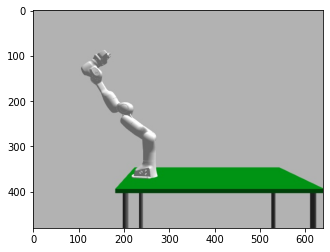

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.4918, 234.7756,   1.0000]],

        [[207.0747, 218.2190,   1.0000]],

        [[141.2626, 143.7800,   1.0000]],

        [[126.0715, 126.6376,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4767, 276.4839,   1.0000]],

        [[180.1607, 255.7533,   1.0000]],

        [[156.8727, 159.2814,   1.0000]],

        [[159.6028, 137.3993,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3321, 234.9554,   1.0000]],

        [[206.8645, 218.3591,   1.0000]],

        [[305.1846, 230.8451,   1.0000]],

        [[316.8651, 248.8036,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.7222, 218.5976,   1.0000]],

        [[321.5300, 230.78

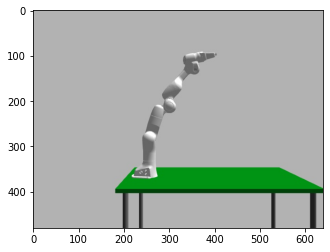

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.1087, 207.4932,   1.0000]],

        [[302.8115, 214.0386,   1.0000]],

        [[355.4379, 130.2985,   1.0000]],

        [[353.1133, 107.7511,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.7497, 206.7479,   1.0000]],

        [[300.6454, 212.6762,   1.0000]],

        [[323.3868, 309.0720,   1.0000]],

        [[343.9591, 313.3242,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6610, 218.1632,   1.0000]],

        [[228.5837, 206.0841,   1.0000]],

        [[308.7537, 147.8299,   1.0000]],

        [[316.2152, 126.6066,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4398, 276.7901,   1.0000]],

        [[180.0401, 256.05

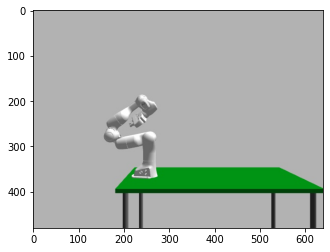

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7597, 298.1967,   1.0000]],

        [[175.8153, 277.7822,   1.0000]],

        [[251.0071, 213.3950,   1.0000]],

        [[265.9945, 228.7169,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.4157, 254.6663,   1.0000]],

        [[190.7939, 235.2228,   1.0000]],

        [[106.8799, 181.8456,   1.0000]],

        [[104.6005, 161.1650,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.2980, 213.2581,   1.0000]],

        [[314.4985, 223.2482,   1.0000]],

        [[341.4525, 318.5109,   1.0000]],

        [[336.3354, 338.4101,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.7378, 203.4087,   1.0000]],

        [[278.5091, 203.34

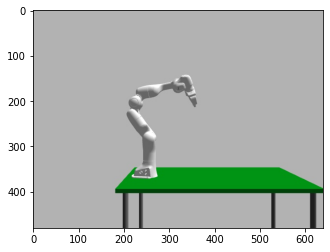

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5452, 218.2460,   1.0000]],

        [[228.4469, 206.1369,   1.0000]],

        [[320.9142, 170.5698,   1.0000]],

        [[342.1794, 163.9510,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.0026, 223.6614,   1.0000]],

        [[326.4874, 237.4921,   1.0000]],

        [[323.6989, 336.4276,   1.0000]],

        [[308.0355, 331.6970,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.6635, 219.2914,   1.0000]],

        [[322.2904, 231.7255,   1.0000]],

        [[413.4445, 270.4663,   1.0000]],

        [[425.8313, 253.2085,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4700, 276.5568,   1.0000]],

        [[180.1345, 255.82

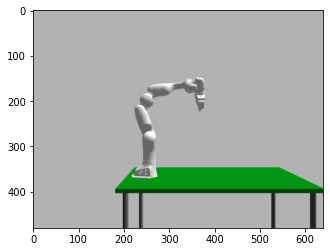

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.7867, 207.4607,   1.0000]],

        [[252.5018, 200.8880,   1.0000]],

        [[346.8833, 170.8025,   1.0000]],

        [[369.0317, 170.1690,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.4230, 207.5823,   1.0000]],

        [[252.1072, 200.9152,   1.0000]],

        [[295.0099, 111.5516,   1.0000]],

        [[288.9239,  89.3465,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.7112, 223.4049,   1.0000]],

        [[326.2612, 237.1567,   1.0000]],

        [[324.3633, 336.1103,   1.0000]],

        [[308.5694, 331.5637,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2371, 235.1017,   1.0000]],

        [[206.7332, 218.47

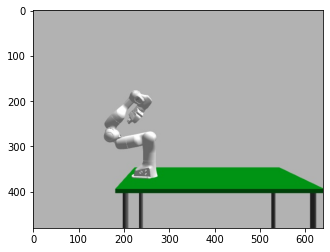

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7362, 297.9363,   1.0000]],

        [[175.8196, 277.5228,   1.0000]],

        [[230.0454, 194.7240,   1.0000]],

        [[246.7173, 208.7475,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7090, 253.9423,   1.0000]],

        [[191.2788, 234.5737,   1.0000]],

        [[198.9403, 135.6465,   1.0000]],

        [[220.6227, 141.3195,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.8601, 206.7813,   1.0000]],

        [[300.7475, 212.7388,   1.0000]],

        [[323.3366, 309.1654,   1.0000]],

        [[343.9100, 313.4264,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.2695, 218.4442,   1.0000]],

        [[228.1205, 206.26

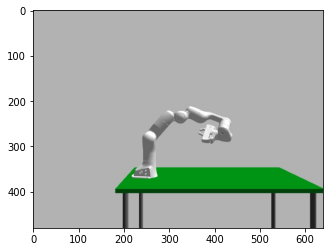

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.7230, 223.4155,   1.0000]],

        [[326.2678, 237.1720,   1.0000]],

        [[421.4343, 263.2164,   1.0000]],

        [[420.3352, 279.4283,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.6922, 218.5759,   1.0000]],

        [[321.5056, 230.7557,   1.0000]],

        [[397.5087, 167.5697,   1.0000]],

        [[379.5676, 156.8927,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.8571, 207.4099,   1.0000]],

        [[302.5815, 213.8896,   1.0000]],

        [[375.0077, 146.4541,   1.0000]],

        [[374.6561, 124.0492,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.4796, 207.5632,   1.0000]],

        [[252.1685, 200.91

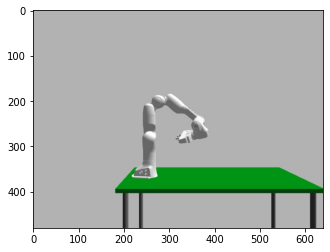

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.0223, 203.4134,   1.0000]],

        [[277.7925, 203.1583,   1.0000]],

        [[363.2809, 253.0928,   1.0000]],

        [[368.6785, 273.7159,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7188, 298.1949,   1.0000]],

        [[175.7364, 277.7849,   1.0000]],

        [[107.6442, 205.6191,   1.0000]],

        [[127.1627, 194.1013,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4977, 276.2780,   1.0000]],

        [[180.2366, 255.5522,   1.0000]],

        [[132.4627, 168.4880,   1.0000]],

        [[150.3333, 155.6380,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5061, 276.1976,   1.0000]],

        [[180.2663, 255.47

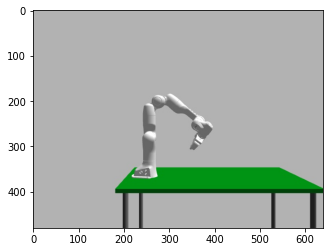

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.0888, 203.4127,   1.0000]],

        [[277.8591, 203.1749,   1.0000]],

        [[363.2593, 253.2603,   1.0000]],

        [[380.8900, 266.8806,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6193, 297.6252,   1.0000]],

        [[175.7892, 277.1871,   1.0000]],

        [[181.3993, 178.3003,   1.0000]],

        [[203.5367, 175.4537,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7806, 253.7802,   1.0000]],

        [[191.3965, 234.4293,   1.0000]],

        [[281.3782, 192.9743,   1.0000]],

        [[303.4610, 194.5511,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.6580, 254.0672,   1.0000]],

        [[191.1945, 234.68

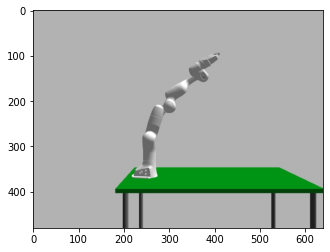

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.9218, 207.4313,   1.0000]],

        [[302.6407, 213.9278,   1.0000]],

        [[375.1797, 146.6140,   1.0000]],

        [[364.2392, 127.9679,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.0316, 207.4676,   1.0000]],

        [[302.7411, 213.9928,   1.0000]],

        [[355.2010, 130.1485,   1.0000]],

        [[337.5878, 118.0635,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[295.9640, 213.0734,   1.0000]],

        [[314.2138, 222.9779,   1.0000]],

        [[320.8461, 321.7668,   1.0000]],

        [[320.2431, 344.2790,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.5858, 297.4261,   1.0000]],

        [[175.8099, 276.97

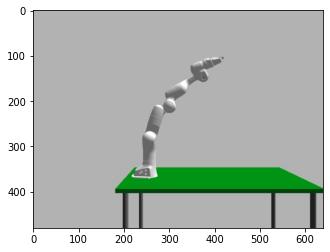

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.8992, 207.4238,   1.0000]],

        [[302.6200, 213.9144,   1.0000]],

        [[375.1195, 146.5580,   1.0000]],

        [[367.5306, 126.0372,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7686, 253.8121,   1.0000]],

        [[191.3767, 234.4580,   1.0000]],

        [[289.0800, 217.9765,   1.0000]],

        [[309.9908, 225.1327,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7148, 298.2329,   1.0000]],

        [[175.7193, 277.8242,   1.0000]],

        [[ 90.6751, 226.5596,   1.0000]],

        [[106.6071, 210.7498,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4843, 276.4086,   1.0000]],

        [[180.1885, 255.67

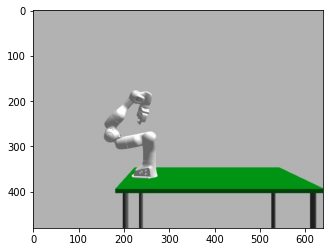

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7868, 298.1020,   1.0000]],

        [[175.8245, 277.7000,   1.0000]],

        [[229.6493, 194.6556,   1.0000]],

        [[250.6781, 201.1652,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5376, 275.8988,   1.0000]],

        [[180.3773, 255.1823,   1.0000]],

        [[111.7348, 183.3618,   1.0000]],

        [[122.1667, 164.6549,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.3627, 213.2937,   1.0000]],

        [[314.5539, 223.3007,   1.0000]],

        [[341.3521, 318.6071,   1.0000]],

        [[350.1904, 339.1595,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3219, 234.9844,   1.0000]],

        [[206.8462, 218.38

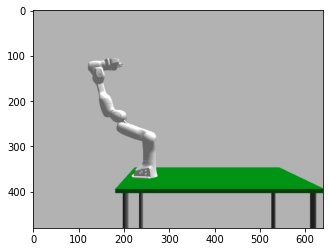

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.6178, 254.1667,   1.0000]],

        [[191.1277, 234.7748,   1.0000]],

        [[146.8680, 145.7923,   1.0000]],

        [[144.1561, 123.9291,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.0101, 203.4086,   1.0000]],

        [[278.7815, 203.4111,   1.0000]],

        [[365.1384, 154.9379,   1.0000]],

        [[382.2598, 140.1435,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7200, 218.1210,   1.0000]],

        [[228.6530, 206.0571,   1.0000]],

        [[290.8369, 128.8400,   1.0000]],

        [[312.4517, 129.8703,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3945, 234.9005,   1.0000]],

        [[206.9443, 218.31

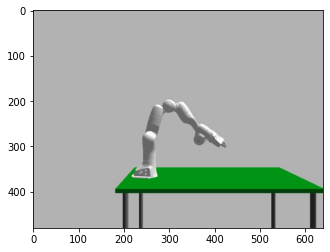

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.3727, 206.9371,   1.0000]],

        [[301.2197, 213.0285,   1.0000]],

        [[368.8586, 285.4050,   1.0000]],

        [[380.7828, 268.1696,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3527, 207.6060,   1.0000]],

        [[252.0311, 200.9207,   1.0000]],

        [[294.7067, 111.4502,   1.0000]],

        [[314.9920, 104.5353,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.3891, 224.0119,   1.0000]],

        [[326.7777, 237.9419,   1.0000]],

        [[412.6094, 189.3806,   1.0000]],

        [[433.6871, 184.7965,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.0361, 213.1132,   1.0000]],

        [[314.2752, 223.03

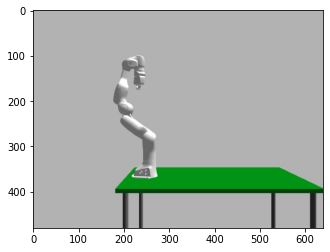

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2575, 235.0766,   1.0000]],

        [[206.7601, 218.4593,   1.0000]],

        [[214.1665, 119.4699,   1.0000]],

        [[236.0945, 121.8582,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.2978, 207.2932,   1.0000]],

        [[253.0560, 200.8534,   1.0000]],

        [[339.6768, 248.8329,   1.0000]],

        [[360.8076, 255.5481,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.6886, 207.0350,   1.0000]],

        [[301.5102, 213.2091,   1.0000]],

        [[396.3909, 241.7119,   1.0000]],

        [[418.8285, 239.8778,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7081, 218.1295,   1.0000]],

        [[228.6388, 206.06

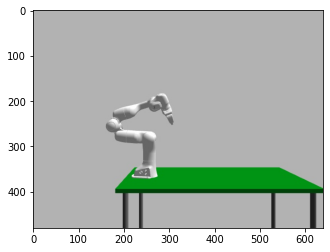

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4400, 276.7922,   1.0000]],

        [[180.0404, 256.0541,   1.0000]],

        [[268.5913, 211.5556,   1.0000]],

        [[289.8079, 205.0953,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4466, 276.7618,   1.0000]],

        [[180.0564, 256.0247,   1.0000]],

        [[233.1757, 172.3814,   1.0000]],

        [[248.0889, 155.9163,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.0391, 203.4132,   1.0000]],

        [[277.8093, 203.1625,   1.0000]],

        [[363.2754, 253.1352,   1.0000]],

        [[372.1799, 272.8350,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.9146, 206.7987,   1.0000]],

        [[300.7991, 212.77

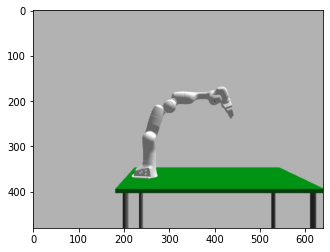

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.9119, 207.4302,   1.0000]],

        [[302.6324, 213.9258,   1.0000]],

        [[400.1677, 197.0993,   1.0000]],

        [[421.5995, 189.9425,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5629, 218.2333,   1.0000]],

        [[228.4678, 206.1288,   1.0000]],

        [[320.9615, 170.6302,   1.0000]],

        [[343.0401, 171.3726,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.4482, 218.3113,   1.0000]],

        [[228.3291, 206.1762,   1.0000]],

        [[167.6400, 127.6152,   1.0000]],

        [[145.6200, 119.0053,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6488, 218.1703,   1.0000]],

        [[228.5668, 206.08

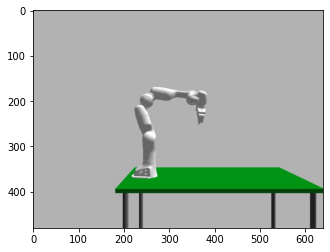

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.9258, 207.4147,   1.0000]],

        [[252.6528, 200.8782,   1.0000]],

        [[351.6266, 197.2261,   1.0000]],

        [[373.8384, 198.8452,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.3098, 213.2646,   1.0000]],

        [[314.5087, 223.2578,   1.0000]],

        [[341.4349, 318.5286,   1.0000]],

        [[339.0807, 339.8097,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7004, 298.2427,   1.0000]],

        [[175.6998, 277.8330,   1.0000]],

        [[ 79.9008, 303.8783,   1.0000]],

        [[ 69.3442, 286.9632,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.6221, 207.3351,   1.0000]],

        [[302.3674, 213.75

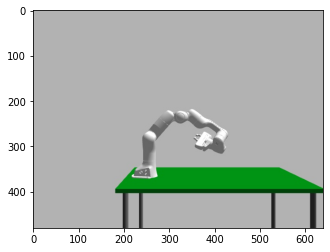

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.6280, 223.3315,   1.0000]],

        [[326.1947, 237.0632,   1.0000]],

        [[411.2474, 287.1443,   1.0000]],

        [[405.8816, 302.5459,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.1328, 207.3468,   1.0000]],

        [[252.8774, 200.8642,   1.0000]],

        [[349.1188, 224.1928,   1.0000]],

        [[368.3463, 235.1874,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2648, 235.0672,   1.0000]],

        [[206.7699, 218.4518,   1.0000]],

        [[214.1820, 119.4638,   1.0000]],

        [[235.2475, 114.2214,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.3031, 218.4199,   1.0000]],

        [[228.1604, 206.24

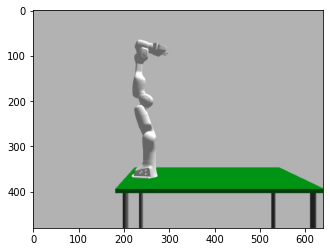

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3118, 207.6198,   1.0000]],

        [[251.9872, 200.9243,   1.0000]],

        [[242.6268, 102.2418,   1.0000]],

        [[246.2280,  80.4099,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.9606, 207.1228,   1.0000]],

        [[301.7613, 213.3701,   1.0000]],

        [[331.6248, 119.1747,   1.0000]],

        [[334.6568,  96.6266,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7064, 298.2473,   1.0000]],

        [[175.7052, 277.8383,   1.0000]],

        [[ 76.3811, 277.4690,   1.0000]],

        [[ 66.9097, 259.4927,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7635, 253.8248,   1.0000]],

        [[191.3687, 234.46

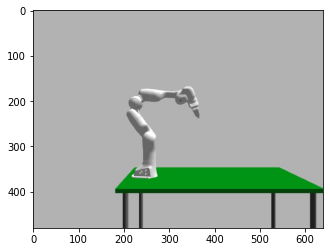

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.4393, 218.3220,   1.0000]],

        [[228.3216, 206.1854,   1.0000]],

        [[326.8629, 196.0778,   1.0000]],

        [[347.5219, 188.1002,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.3017, 218.2958,   1.0000]],

        [[321.1876, 230.3743,   1.0000]],

        [[381.2965, 309.0842,   1.0000]],

        [[398.6549, 323.6366,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.5385, 207.5435,   1.0000]],

        [[252.2324, 200.9063,   1.0000]],

        [[334.8299, 146.1759,   1.0000]],

        [[354.7429, 154.1670,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.6110, 275.2502,   1.0000]],

        [[180.6218, 254.55

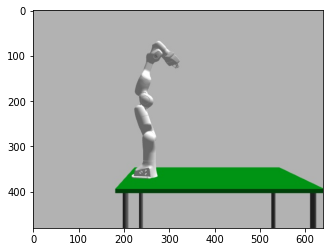

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3350, 207.6120,   1.0000]],

        [[252.0119, 200.9221,   1.0000]],

        [[269.2684, 103.3005,   1.0000]],

        [[284.5428,  88.1376,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.7084, 206.7353,   1.0000]],

        [[300.6070, 212.6522,   1.0000]],

        [[323.5089, 309.0168,   1.0000]],

        [[344.0664, 313.3621,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.3144, 207.2878,   1.0000]],

        [[253.0739, 200.8523,   1.0000]],

        [[339.6702, 248.8763,   1.0000]],

        [[361.4518, 252.0648,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.3665, 207.5818,   1.0000]],

        [[303.0476, 214.19

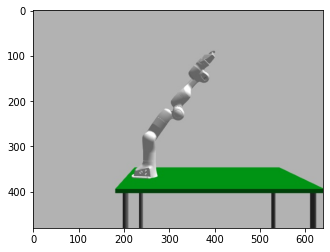

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[304.3217, 218.3090,   1.0000]],

        [[321.2047, 230.3919,   1.0000]],

        [[376.6818, 148.6724,   1.0000]],

        [[362.3533, 133.0217,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.3540, 254.8196,   1.0000]],

        [[190.6921, 235.3605,   1.0000]],

        [[ 95.6153, 206.3273,   1.0000]],

        [[103.6241, 186.8750,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4399, 276.7968,   1.0000]],

        [[180.0393, 256.0585,   1.0000]],

        [[253.5864, 189.6599,   1.0000]],

        [[269.9963, 174.7833,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7203, 218.1202,   1.0000]],

        [[228.6521, 206.05

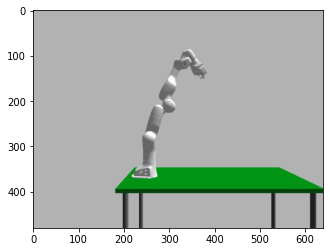

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.0378, 207.1473,   1.0000]],

        [[301.8321, 213.4147,   1.0000]],

        [[331.8826, 119.2784,   1.0000]],

        [[349.3623, 107.3259,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.9961, 206.8240,   1.0000]],

        [[300.8750, 212.8200,   1.0000]],

        [[322.6612, 309.3935,   1.0000]],

        [[343.3125, 313.1305,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.6257, 203.4119,   1.0000]],

        [[279.3957, 203.5744,   1.0000]],

        [[280.1830, 104.6404,   1.0000]],

        [[276.3905,  82.0598,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.9871, 203.4086,   1.0000]],

        [[278.7584, 203.40

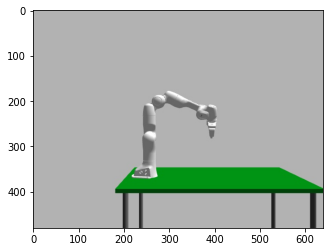

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.3047, 203.4108,   1.0000]],

        [[278.0754, 203.2293,   1.0000]],

        [[373.5116, 229.5990,   1.0000]],

        [[395.8299, 231.3258,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.4950, 203.4108,   1.0000]],

        [[279.2654, 203.5394,   1.0000]],

        [[305.8671, 108.2037,   1.0000]],

        [[304.1852,  85.2727,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4829, 276.4225,   1.0000]],

        [[180.1833, 255.6934,   1.0000]],

        [[156.9901, 159.2025,   1.0000]],

        [[173.1983, 144.5745,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3158, 207.6185,   1.0000]],

        [[251.9911, 200.92

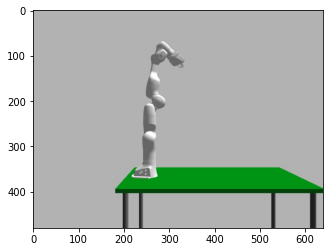

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.5919, 203.4116,   1.0000]],

        [[279.3619, 203.5653,   1.0000]],

        [[280.0498, 104.6307,   1.0000]],

        [[293.2254,  88.0206,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.2163, 206.8892,   1.0000]],

        [[301.0757, 212.9397,   1.0000]],

        [[369.0025, 285.0467,   1.0000]],

        [[390.3752, 291.0494,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.1151, 207.1718,   1.0000]],

        [[301.9030, 213.4594,   1.0000]],

        [[355.9724, 130.6891,   1.0000]],

        [[374.8805, 120.2690,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7130, 298.2391,   1.0000]],

        [[175.7154, 277.83

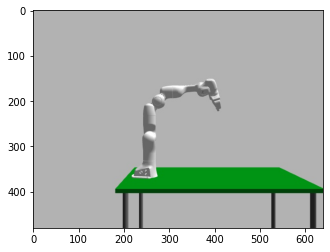

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.7666, 203.4087,   1.0000]],

        [[278.5379, 203.3476,   1.0000]],

        [[374.4418, 178.6659,   1.0000]],

        [[395.9687, 172.2741,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.6510, 224.2501,   1.0000]],

        [[326.9772, 238.2483,   1.0000]],

        [[397.4360, 169.2305,   1.0000]],

        [[415.9081, 168.7963,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.1920, 218.5002,   1.0000]],

        [[228.0289, 206.2994,   1.0000]],

        [[318.3543, 246.9564,   1.0000]],

        [[330.8193, 264.8790,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.8979, 203.4086,   1.0000]],

        [[278.6693, 203.38

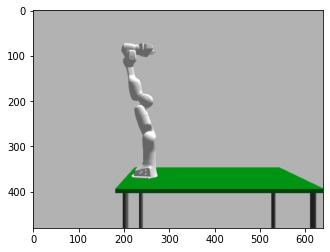

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3229, 207.6161,   1.0000]],

        [[251.9995, 200.9236,   1.0000]],

        [[216.8537, 108.2642,   1.0000]],

        [[218.2596,  86.6256,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4595, 276.6632,   1.0000]],

        [[180.0952, 255.9287,   1.0000]],

        [[183.0117, 156.7982,   1.0000]],

        [[205.3913, 158.1024,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5818, 218.2198,   1.0000]],

        [[228.4900, 206.1202,   1.0000]],

        [[308.4562, 147.5886,   1.0000]],

        [[329.2440, 153.7296,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.6177, 223.3230,   1.0000]],

        [[326.1886, 237.04

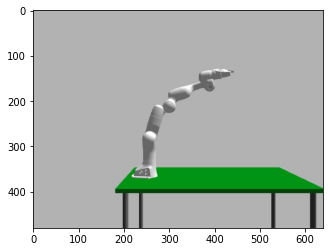

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.5912, 207.3229,   1.0000]],

        [[302.3382, 213.7330,   1.0000]],

        [[389.7448, 167.2325,   1.0000]],

        [[387.2941, 145.5462,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[309.9655, 222.7535,   1.0000]],

        [[325.6840, 236.3121,   1.0000]],

        [[375.1816, 321.8516,   1.0000]],

        [[378.1724, 342.9122,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3397, 207.6104,   1.0000]],

        [[252.0170, 200.9218,   1.0000]],

        [[269.2937, 103.3035,   1.0000]],

        [[286.8780,  91.2865,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.1138, 213.1573,   1.0000]],

        [[314.3406, 223.09

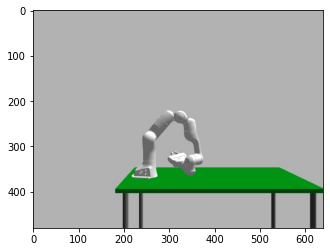

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.1664, 222.9258,   1.0000]],

        [[325.8419, 236.5379,   1.0000]],

        [[350.7083, 332.2742,   1.0000]],

        [[341.8936, 349.1685,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.2262, 207.2051,   1.0000]],

        [[302.0037, 213.5197,   1.0000]],

        [[398.4216, 190.8790,   1.0000]],

        [[417.2321, 178.2408,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4591, 276.6339,   1.0000]],

        [[180.1037, 255.8995,   1.0000]],

        [[183.1175, 156.7734,   1.0000]],

        [[205.1756, 161.3722,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7199, 218.1204,   1.0000]],

        [[228.6516, 206.05

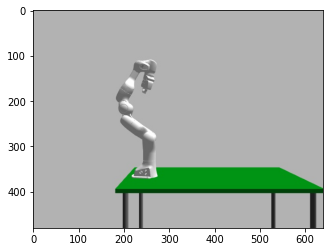

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2410, 235.0968,   1.0000]],

        [[206.7385, 218.4754,   1.0000]],

        [[240.1396, 125.0698,   1.0000]],

        [[261.6992, 128.8708,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.8501, 207.4397,   1.0000]],

        [[252.5706, 200.8835,   1.0000]],

        [[351.5356, 196.9995,   1.0000]],

        [[364.5543, 213.9406,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.9172, 223.5879,   1.0000]],

        [[326.4168, 237.3950,   1.0000]],

        [[425.0519, 237.9225,   1.0000]],

        [[446.9902, 241.7038,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.4244, 203.4103,   1.0000]],

        [[279.1951, 203.52

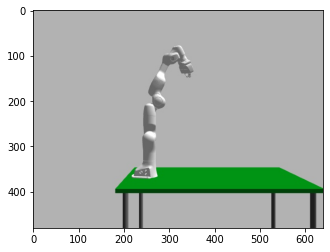

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.5704, 203.4114,   1.0000]],

        [[279.3406, 203.5596,   1.0000]],

        [[306.1439, 108.2800,   1.0000]],

        [[325.0636,  99.0333,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.4428, 206.9587,   1.0000]],

        [[301.2842, 213.0685,   1.0000]],

        [[385.5836, 265.1099,   1.0000]],

        [[392.7202, 245.2632,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.0463, 207.4724,   1.0000]],

        [[302.7545, 214.0015,   1.0000]],

        [[355.2460, 130.1769,   1.0000]],

        [[339.9378, 114.9408,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5297, 275.9713,   1.0000]],

        [[180.3502, 255.25

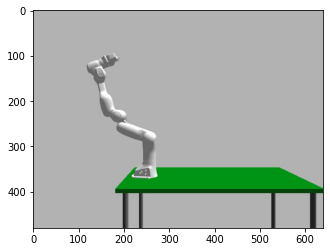

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.6311, 254.1341,   1.0000]],

        [[191.1498, 234.7455,   1.0000]],

        [[146.9445, 145.7386,   1.0000]],

        [[136.5767, 125.3998,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.6463, 207.3430,   1.0000]],

        [[302.3896, 213.7693,   1.0000]],

        [[391.7326, 171.2393,   1.0000]],

        [[412.0717, 161.6498,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7763, 253.7792,   1.0000]],

        [[191.3907, 234.4278,   1.0000]],

        [[225.0329, 141.1658,   1.0000]],

        [[244.5032, 151.8882,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.1057, 223.7531,   1.0000]],

        [[326.5671, 237.61

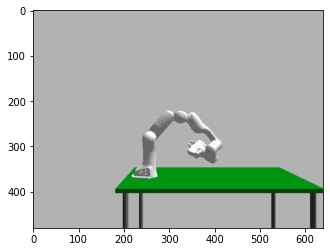

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.3482, 223.0859,   1.0000]],

        [[325.9791, 236.7447,   1.0000]],

        [[395.3698, 306.9961,   1.0000]],

        [[389.1200, 322.6960,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.1119, 213.1551,   1.0000]],

        [[314.3399, 223.0976,   1.0000]],

        [[319.9050, 321.9432,   1.0000]],

        [[321.3458, 344.4659,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.2880, 207.2271,   1.0000]],

        [[302.0614, 213.5598,   1.0000]],

        [[376.3372, 148.2401,   1.0000]],

        [[377.2442, 125.8119,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7240, 298.2397,   1.0000]],

        [[175.7289, 277.83

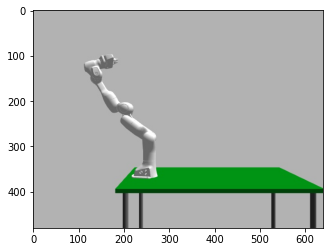

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.5158, 234.7449,   1.0000]],

        [[207.1068, 218.1945,   1.0000]],

        [[141.3486, 143.7106,   1.0000]],

        [[133.0883, 123.3755,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.7806, 223.4637,   1.0000]],

        [[326.3169, 237.2368,   1.0000]],

        [[350.0647, 333.2922,   1.0000]],

        [[339.2198, 347.9063,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4953, 276.3014,   1.0000]],

        [[180.2279, 255.5751,   1.0000]],

        [[132.4171, 168.5294,   1.0000]],

        [[152.5235, 158.8444,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2681, 235.0629,   1.0000]],

        [[206.7744, 218.44

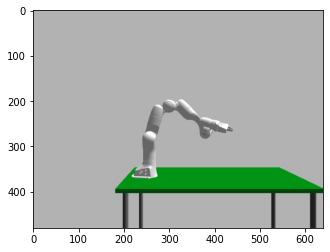

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.4127, 206.9494,   1.0000]],

        [[301.2564, 213.0513,   1.0000]],

        [[385.5963, 265.0276,   1.0000]],

        [[388.9713, 244.1192,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3593, 234.9453,   1.0000]],

        [[206.8974, 218.3545,   1.0000]],

        [[187.9478, 120.8613,   1.0000]],

        [[208.5259, 113.9576,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6754, 297.9482,   1.0000]],

        [[175.7588, 277.5259,   1.0000]],

        [[129.5954, 189.7759,   1.0000]],

        [[122.3820, 168.6409,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2167, 235.1280,   1.0000]],

        [[206.7054, 218.50

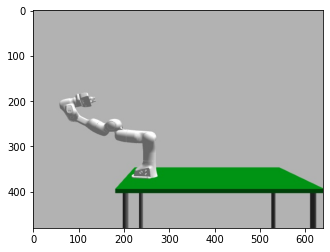

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.6049, 275.3013,   1.0000]],

        [[180.6023, 254.6007,   1.0000]],

        [[ 85.2606, 226.7133,   1.0000]],

        [[ 81.0036, 206.6412,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.5018, 224.1142,   1.0000]],

        [[326.8636, 238.0735,   1.0000]],

        [[412.8621, 189.8117,   1.0000]],

        [[423.1892, 201.9940,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[284.0352, 207.8103,   1.0000]],

        [[303.6568, 214.5992,   1.0000]],

        [[340.0024, 306.6917,   1.0000]],

        [[351.0682, 326.2605,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.4838, 223.2046,   1.0000]],

        [[326.0837, 236.89

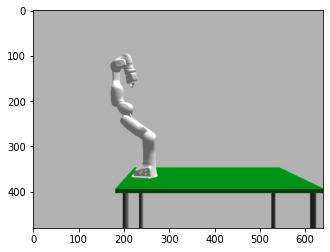

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3650, 234.9380,   1.0000]],

        [[206.9050, 218.3486,   1.0000]],

        [[187.9663, 120.8539,   1.0000]],

        [[209.6910, 117.6320,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7135, 298.2392,   1.0000]],

        [[175.7160, 277.8305,   1.0000]],

        [[ 80.1069, 250.9315,   1.0000]],

        [[ 79.8774, 230.0753,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.9197, 207.7704,   1.0000]],

        [[303.5517, 214.5292,   1.0000]],

        [[363.2204, 293.5363,   1.0000]],

        [[366.3299, 315.0264,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3088, 235.0019,   1.0000]],

        [[206.8287, 218.39

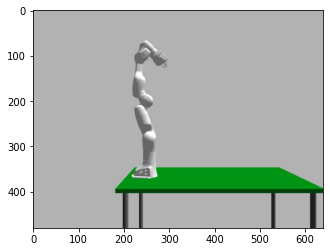

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3105, 207.6203,   1.0000]],

        [[251.9860, 200.9244,   1.0000]],

        [[242.6001, 102.2448,   1.0000]],

        [[256.1665,  86.0261,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4454, 276.7716,   1.0000]],

        [[180.0524, 256.0342,   1.0000]],

        [[233.1893, 172.4014,   1.0000]],

        [[254.2328, 165.5228,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.9972, 207.3912,   1.0000]],

        [[252.7303, 200.8733,   1.0000]],

        [[351.7119, 197.4369,   1.0000]],

        [[370.1404, 185.1755,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2346, 235.1048,   1.0000]],

        [[206.7296, 218.48

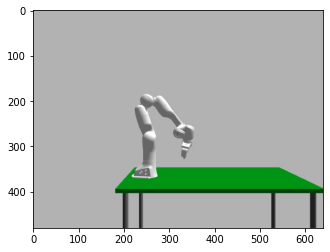

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.3732, 207.2688,   1.0000]],

        [[253.1376, 200.8486,   1.0000]],

        [[323.7890, 270.2195,   1.0000]],

        [[344.7617, 275.8231,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.4964, 218.2774,   1.0000]],

        [[228.3861, 206.1547,   1.0000]],

        [[167.7825, 127.5305,   1.0000]],

        [[155.5723, 108.4788,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.4675, 203.4106,   1.0000]],

        [[279.2381, 203.5321,   1.0000]],

        [[305.7650, 108.1758,   1.0000]],

        [[293.7534,  88.8044,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7679, 253.7996,   1.0000]],

        [[191.3766, 234.44

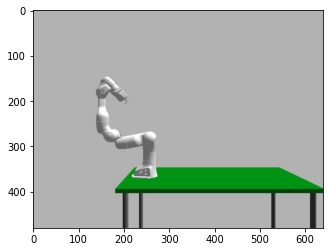

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6435, 297.7664,   1.0000]],

        [[175.7756, 277.3351,   1.0000]],

        [[154.7741, 180.4950,   1.0000]],

        [[171.2292, 165.8875,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7115, 218.1270,   1.0000]],

        [[228.6428, 206.0608,   1.0000]],

        [[268.3392, 115.1589,   1.0000]],

        [[288.3724, 106.9971,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.3202, 213.2703,   1.0000]],

        [[314.5176, 223.2662,   1.0000]],

        [[341.4195, 318.5440,   1.0000]],

        [[341.9498, 340.6099,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.4845, 254.4946,   1.0000]],

        [[190.9078, 235.06

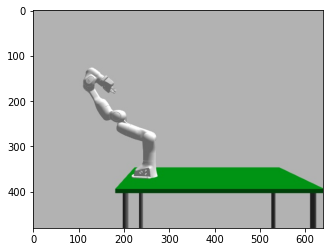

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.5394, 254.3589,   1.0000]],

        [[190.9985, 234.9470,   1.0000]],

        [[124.6134, 160.9176,   1.0000]],

        [[138.9296, 144.9301,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.4077, 254.6862,   1.0000]],

        [[190.7806, 235.2408,   1.0000]],

        [[106.8440, 181.8968,   1.0000]],

        [[108.6779, 161.2518,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.8753, 203.4086,   1.0000]],

        [[278.6467, 203.3759,   1.0000]],

        [[374.6211, 178.9710,   1.0000]],

        [[392.7727, 190.3094,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2323, 235.1048,   1.0000]],

        [[206.7271, 218.48

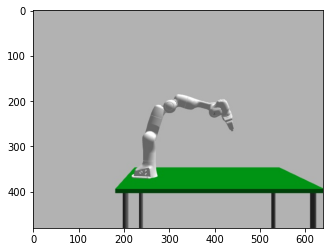

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.2545, 207.5442,   1.0000]],

        [[302.9454, 214.1293,   1.0000]],

        [[401.3940, 224.4963,   1.0000]],

        [[422.4250, 216.4754,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2299, 235.1076,   1.0000]],

        [[206.7235, 218.4834,   1.0000]],

        [[283.4057, 155.7020,   1.0000]],

        [[305.3835, 155.5393,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.9987, 203.4137,   1.0000]],

        [[277.7688, 203.1524,   1.0000]],

        [[347.0275, 273.8878,   1.0000]],

        [[350.4844, 295.1656,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.9841, 207.4541,   1.0000]],

        [[302.6984, 213.96

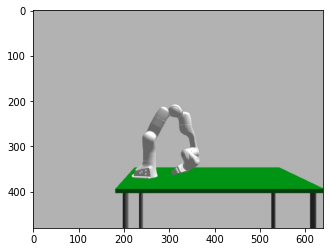

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.3362, 213.2799,   1.0000]],

        [[314.5309, 223.2804,   1.0000]],

        [[341.2858, 318.5771,   1.0000]],

        [[350.2325, 339.0631,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3408, 234.9594,   1.0000]],

        [[206.8713, 218.3640,   1.0000]],

        [[305.1816, 230.8396,   1.0000]],

        [[317.8619, 248.2323,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5017, 276.2393,   1.0000]],

        [[180.2509, 255.5145,   1.0000]],

        [[132.5375, 168.4199,   1.0000]],

        [[144.4539, 150.4309,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7213, 298.2278,   1.0000]],

        [[175.7291, 277.81

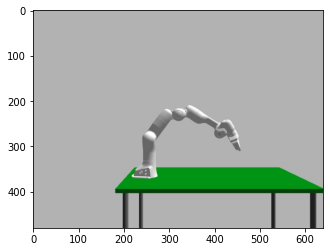

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.5994, 219.2435,   1.0000]],

        [[322.2388, 231.6608,   1.0000]],

        [[413.4653, 270.2341,   1.0000]],

        [[433.6080, 261.1260,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.2296, 207.5335,   1.0000]],

        [[302.9219, 214.1105,   1.0000]],

        [[331.7729, 119.5736,   1.0000]],

        [[323.7805,  98.3313,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7924, 253.7426,   1.0000]],

        [[191.4175, 234.3951,   1.0000]],

        [[267.6869, 171.1602,   1.0000]],

        [[288.4161, 163.2521,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.4627, 234.8131,   1.0000]],

        [[207.0357, 218.24

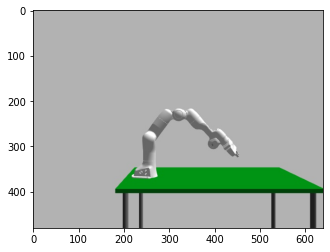

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.8307, 219.4169,   1.0000]],

        [[322.4250, 231.8948,   1.0000]],

        [[399.7747, 293.7975,   1.0000]],

        [[416.3670, 280.5811,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.5388, 223.2530,   1.0000]],

        [[326.1261, 236.9615,   1.0000]],

        [[411.3082, 286.8214,   1.0000]],

        [[423.0418, 303.9958,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4418, 276.7833,   1.0000]],

        [[180.0457, 256.0453,   1.0000]],

        [[253.5149, 189.5621,   1.0000]],

        [[265.9788, 207.0175,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4518, 276.7112,   1.0000]],

        [[180.0756, 255.97

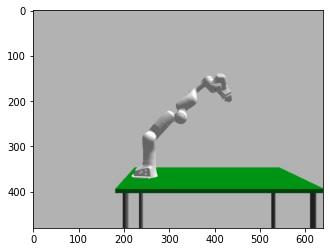

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.7032, 224.2979,   1.0000]],

        [[327.0169, 238.3096,   1.0000]],

        [[397.5864, 169.4059,   1.0000]],

        [[416.7768, 159.5265,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.2024, 207.5244,   1.0000]],

        [[302.8971, 214.0943,   1.0000]],

        [[331.6820, 119.5375,   1.0000]],

        [[330.6765,  96.7036,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.7633, 207.3791,   1.0000]],

        [[302.4957, 213.8342,   1.0000]],

        [[374.7576, 146.2225,   1.0000]],

        [[388.0464, 127.7866,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.2759, 203.4095,   1.0000]],

        [[279.0469, 203.48

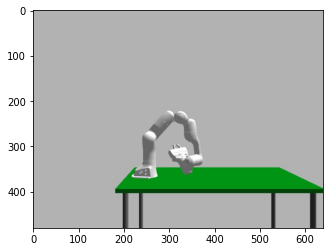

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.1267, 223.7719,   1.0000]],

        [[326.5832, 237.6358,   1.0000]],

        [[349.7068, 333.8601,   1.0000]],

        [[336.2486, 344.2185,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.0709, 203.4088,   1.0000]],

        [[278.8422, 203.4270,   1.0000]],

        [[365.2774, 155.0938,   1.0000]],

        [[373.4864, 134.0702,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.7125, 207.0425,   1.0000]],

        [[301.5321, 213.2228,   1.0000]],

        [[396.3952, 241.7837,   1.0000]],

        [[418.1286, 236.4071,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3725, 234.9284,   1.0000]],

        [[206.9151, 218.34

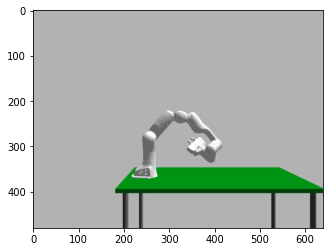

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.3299, 223.0699,   1.0000]],

        [[325.9650, 236.7239,   1.0000]],

        [[395.3919, 306.9391,   1.0000]],

        [[386.1469, 320.4234,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.5123, 276.1383,   1.0000]],

        [[180.2884, 255.4159,   1.0000]],

        [[132.7353, 168.2414,   1.0000]],

        [[125.2568, 147.1402,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.3167, 235.0002,   1.0000]],

        [[206.8400, 218.3982,   1.0000]],

        [[187.8122, 120.9154,   1.0000]],

        [[187.2832,  98.5462,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7848, 253.7693,   1.0000]],

        [[191.4032, 234.41

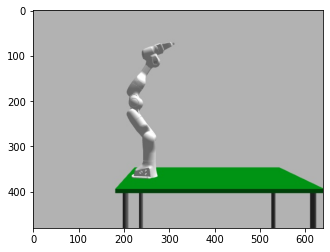

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7410, 218.1058,   1.0000]],

        [[228.6772, 206.0472,   1.0000]],

        [[268.5578, 115.2222,   1.0000]],

        [[260.8795,  93.4482,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.5952, 297.4812,   1.0000]],

        [[175.8042, 277.0359,   1.0000]],

        [[207.5762, 183.2527,   1.0000]],

        [[226.3133, 171.4324,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7148, 298.2430,   1.0000]],

        [[175.7164, 277.8346,   1.0000]],

        [[ 80.1123, 250.9239,   1.0000]],

        [[ 83.9377, 230.1012,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3117, 207.6199,   1.0000]],

        [[251.9871, 200.92

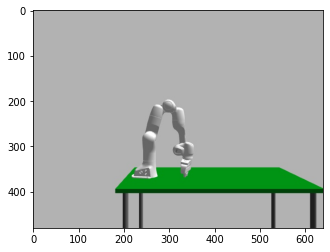

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.7912, 206.7607,   1.0000]],

        [[300.6842, 212.7004,   1.0000]],

        [[323.2657, 309.1262,   1.0000]],

        [[343.8528, 313.2877,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.3998, 254.7059,   1.0000]],

        [[190.7675, 235.2585,   1.0000]],

        [[106.8086, 181.9472,   1.0000]],

        [[112.6124, 161.9429,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7206, 298.2372,   1.0000]],

        [[175.7252, 277.8289,   1.0000]],

        [[ 90.7800, 226.4348,   1.0000]],

        [[ 73.6354, 211.9743,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4525, 276.7038,   1.0000]],

        [[180.0784, 255.96

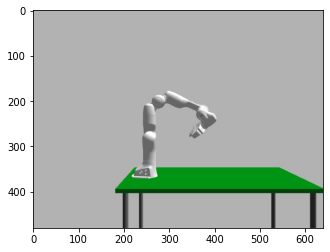

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.4007, 203.4101,   1.0000]],

        [[278.1716, 203.2537,   1.0000]],

        [[373.5406, 229.8651,   1.0000]],

        [[387.0551, 246.7747,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5788, 218.2194,   1.0000]],

        [[228.4837, 206.1181,   1.0000]],

        [[190.8317, 114.2419,   1.0000]],

        [[195.4949,  93.3602,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7046, 298.2453,   1.0000]],

        [[175.7038, 277.8361,   1.0000]],

        [[ 76.3752, 277.5121,   1.0000]],

        [[ 74.4690, 256.9355,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.6584, 274.8580,   1.0000]],

        [[180.7721, 254.17

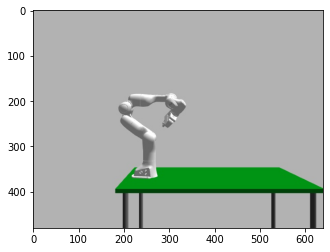

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2970, 235.0176,   1.0000]],

        [[206.8129, 218.4109,   1.0000]],

        [[304.8827, 204.2310,   1.0000]],

        [[321.7869, 217.8593,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.6964, 253.9736,   1.0000]],

        [[191.2579, 234.6017,   1.0000]],

        [[172.4106, 137.1050,   1.0000]],

        [[194.8764, 137.2860,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.1573, 207.5117,   1.0000]],

        [[302.8567, 214.0714,   1.0000]],

        [[401.3317, 224.1917,   1.0000]],

        [[422.7440, 230.2882,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.5709, 234.6748,   1.0000]],

        [[207.1802, 218.13

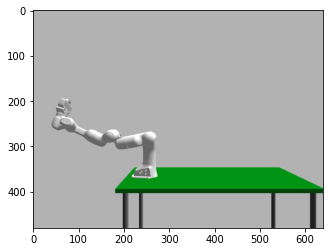

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7085, 298.2345,   1.0000]],

        [[175.7114, 277.8252,   1.0000]],

        [[ 80.0514, 251.0548,   1.0000]],

        [[ 57.7905, 245.1133,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.1425, 207.5044,   1.0000]],

        [[302.8423, 214.0586,   1.0000]],

        [[355.5420, 130.3645,   1.0000]],

        [[360.4823, 108.0797,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.5313, 206.9861,   1.0000]],

        [[301.3656, 213.1190,   1.0000]],

        [[385.5464, 265.3511,   1.0000]],

        [[404.5675, 255.1715,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.9201, 206.7994,   1.0000]],

        [[300.8028, 212.77

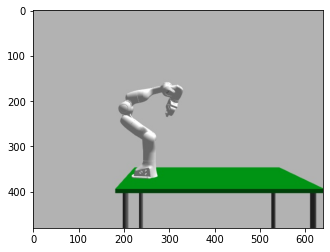

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2649, 235.0604,   1.0000]],

        [[206.7704, 218.4454,   1.0000]],

        [[297.4601, 178.5225,   1.0000]],

        [[317.3341, 187.5511,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.5525, 207.5388,   1.0000]],

        [[252.2476, 200.9052,   1.0000]],

        [[334.8700, 146.2122,   1.0000]],

        [[356.0115, 150.6313,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7228, 253.9088,   1.0000]],

        [[191.3017, 234.5436,   1.0000]],

        [[198.9988, 135.6215,   1.0000]],

        [[218.8105, 126.4416,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.6071, 223.3137,   1.0000]],

        [[326.1804, 237.03

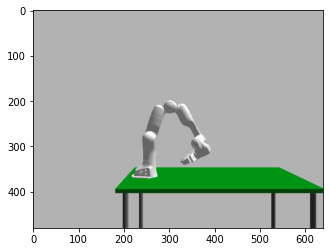

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.8914, 207.7606,   1.0000]],

        [[303.5260, 214.5121,   1.0000]],

        [[363.2506, 293.4767,   1.0000]],

        [[373.3241, 313.3353,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.1697, 207.1892,   1.0000]],

        [[301.9530, 213.4910,   1.0000]],

        [[356.1391, 130.7970,   1.0000]],

        [[368.3154, 111.8412,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3115, 207.6200,   1.0000]],

        [[251.9870, 200.9244,   1.0000]],

        [[216.8356, 108.2668,   1.0000]],

        [[228.8336,  91.3036,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7857, 298.0961,   1.0000]],

        [[175.8251, 277.69

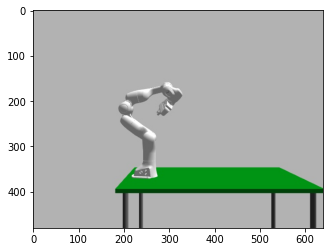

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2707, 235.0527,   1.0000]],

        [[206.7781, 218.4391,   1.0000]],

        [[297.4875, 178.5606,   1.0000]],

        [[312.9545, 193.5187,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.1274, 203.4089,   1.0000]],

        [[278.8986, 203.4419,   1.0000]],

        [[349.5767, 134.0840,   1.0000]],

        [[352.1089, 111.4927,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.4243, 224.0437,   1.0000]],

        [[326.8045, 237.9829,   1.0000]],

        [[412.6884, 189.5152,   1.0000]],

        [[432.2618, 190.9622,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7385, 218.1076,   1.0000]],

        [[228.6743, 206.04

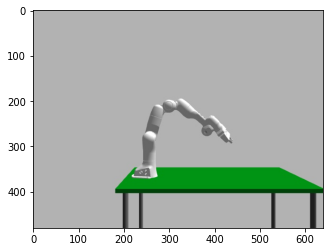

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.5071, 206.9786,   1.0000]],

        [[301.3434, 213.1052,   1.0000]],

        [[385.5566, 265.2852,   1.0000]],

        [[402.2700, 252.0047,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.6405, 219.2742,   1.0000]],

        [[322.2719, 231.7023,   1.0000]],

        [[413.4521, 270.3829,   1.0000]],

        [[428.9062, 255.4294,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.6434, 274.9799,   1.0000]],

        [[180.7251, 254.2884,   1.0000]],

        [[ 81.4785, 251.8269,   1.0000]],

        [[ 65.6865, 238.3831,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.8887, 224.4669,   1.0000]],

        [[327.1628, 238.52

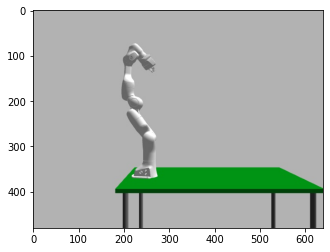

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7082, 218.1287,   1.0000]],

        [[228.6376, 206.0613,   1.0000]],

        [[216.6588, 107.5091,   1.0000]],

        [[232.6286,  93.5615,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.2169, 207.3194,   1.0000]],

        [[252.9684, 200.8586,   1.0000]],

        [[339.7112, 248.6171,   1.0000]],

        [[345.9849, 269.0583,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.4236, 207.2526,   1.0000]],

        [[253.1920, 200.8454,   1.0000]],

        [[323.7292, 270.3326,   1.0000]],

        [[334.5287, 289.6278,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.6968, 234.5148,   1.0000]],

        [[207.3478, 218.01

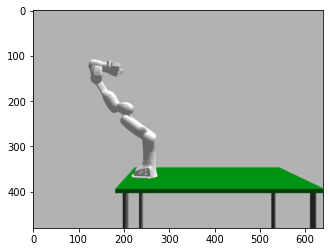

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.5511, 234.6999,   1.0000]],

        [[207.1539, 218.1586,   1.0000]],

        [[141.4727, 143.6106,   1.0000]],

        [[145.0022, 122.9933,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4404, 276.7972,   1.0000]],

        [[180.0400, 256.0590,   1.0000]],

        [[253.5447, 189.6142,   1.0000]],

        [[275.6413, 188.1213,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7473, 253.8643,   1.0000]],

        [[191.3446, 234.5048,   1.0000]],

        [[289.0352, 217.9490,   1.0000]],

        [[297.4661, 237.1652,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.6181, 297.5328,   1.0000]],

        [[175.8127, 277.09

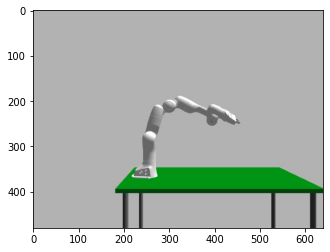

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.8381, 207.0819,   1.0000]],

        [[301.6476, 213.2951,   1.0000]],

        [[396.4169, 242.1620,   1.0000]],

        [[406.0561, 223.1388,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7336, 253.8827,   1.0000]],

        [[191.3195, 234.5203,   1.0000]],

        [[199.0384, 135.6017,   1.0000]],

        [[211.3576, 117.4506,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.5736, 254.2754,   1.0000]],

        [[191.0546, 234.8721,   1.0000]],

        [[146.6204, 145.9683,   1.0000]],

        [[166.8966, 137.2294,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7011, 298.2432,   1.0000]],

        [[175.7004, 277.83

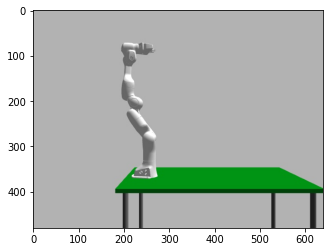

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6893, 218.1418,   1.0000]],

        [[228.6151, 206.0695,   1.0000]],

        [[216.6339, 107.5156,   1.0000]],

        [[215.7390,  84.9717,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.4890, 207.5601,   1.0000]],

        [[252.1788, 200.9100,   1.0000]],

        [[317.1780, 126.0913,   1.0000]],

        [[333.5455, 110.8429,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.1627, 203.4090,   1.0000]],

        [[278.9339, 203.4512,   1.0000]],

        [[349.6780, 134.1606,   1.0000]],

        [[359.3408, 113.5091,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.7656, 298.0353,   1.0000]],

        [[175.8217, 277.62

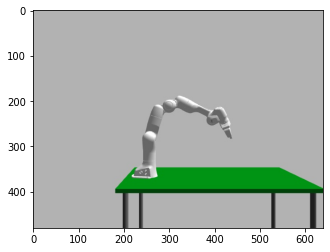

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.7340, 207.0492,   1.0000]],

        [[301.5519, 213.2352,   1.0000]],

        [[396.3990, 241.8485,   1.0000]],

        [[416.7827, 233.0554,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.6088, 218.2005,   1.0000]],

        [[228.5220, 206.1079,   1.0000]],

        [[308.5593, 147.6729,   1.0000]],

        [[330.0634, 142.6994,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.5040, 203.4109,   1.0000]],

        [[279.2744, 203.5418,   1.0000]],

        [[305.9004, 108.2129,   1.0000]],

        [[307.8806,  85.4427,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.1463, 203.4090,   1.0000]],

        [[278.9175, 203.44

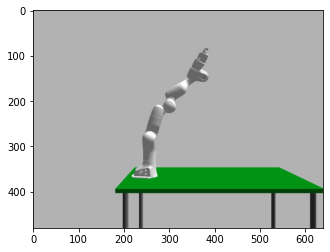

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.9738, 207.4484,   1.0000]],

        [[302.6883, 213.9586,   1.0000]],

        [[375.3175, 146.7424,   1.0000]],

        [[356.6240, 136.7148,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.0404, 223.6980,   1.0000]],

        [[326.5112, 237.5372,   1.0000]],

        [[425.1417, 238.4335,   1.0000]],

        [[431.8072, 253.7570,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.2231, 235.1167,   1.0000]],

        [[206.7146, 218.4908,   1.0000]],

        [[283.3555, 155.6595,   1.0000]],

        [[302.3500, 166.1796,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.3792, 203.4100,   1.0000]],

        [[279.1499, 203.50

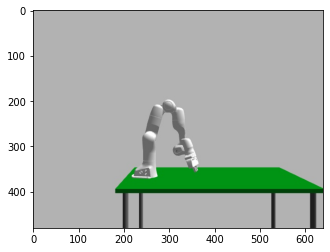

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[280.8947, 206.7917,   1.0000]],

        [[300.7794, 212.7583,   1.0000]],

        [[323.2736, 309.2067,   1.0000]],

        [[342.6635, 302.1900,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.9150, 219.4804,   1.0000]],

        [[322.4926, 231.9804,   1.0000]],

        [[399.6924, 294.0677,   1.0000]],

        [[422.0359, 294.5966,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.0154, 206.8281,   1.0000]],

        [[300.8906, 212.8261,   1.0000]],

        [[347.8587, 300.0347,   1.0000]],

        [[363.5870, 286.4017,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.3027, 207.6229,   1.0000]],

        [[251.9771, 200.92

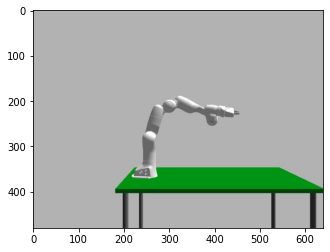

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[281.8928, 207.0991,   1.0000]],

        [[301.6978, 213.3266,   1.0000]],

        [[396.4259, 242.3267,   1.0000]],

        [[398.6264, 221.2534,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.2901, 254.9798,   1.0000]],

        [[190.5864, 235.5045,   1.0000]],

        [[ 95.4033, 206.7869,   1.0000]],

        [[ 77.6593, 193.9458,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[233.1635, 207.3368,   1.0000]],

        [[252.9106, 200.8622,   1.0000]],

        [[349.1298, 224.2823,   1.0000]],

        [[363.5153, 240.6025,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4488, 276.7401,   1.0000]],

        [[180.0647, 256.00

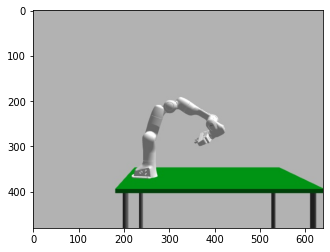

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.5325, 207.6380,   1.0000]],

        [[303.1990, 214.2957,   1.0000]],

        [[395.1241, 251.0545,   1.0000]],

        [[405.5658, 269.7476,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.7987, 223.4825,   1.0000]],

        [[326.3260, 237.2588,   1.0000]],

        [[421.4333, 263.5169,   1.0000]],

        [[434.3798, 278.4680,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.5081, 218.2691,   1.0000]],

        [[228.4000, 206.1495,   1.0000]],

        [[167.8164, 127.5105,   1.0000]],

        [[159.1448, 107.1226,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[232.7245, 207.4814,   1.0000]],

        [[252.4343, 200.89

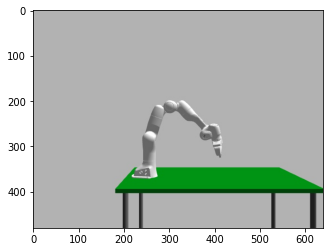

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.7726, 207.7198,   1.0000]],

        [[303.4178, 214.4403,   1.0000]],

        [[381.9490, 274.7327,   1.0000]],

        [[403.6722, 271.7104,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4876, 276.3763,   1.0000]],

        [[180.2004, 255.6482,   1.0000]],

        [[157.0789, 159.1427,   1.0000]],

        [[179.0121, 154.5124,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4399, 276.7896,   1.0000]],

        [[180.0404, 256.0515,   1.0000]],

        [[268.6238, 211.6166,   1.0000]],

        [[287.4753, 222.4366,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7921, 253.7410,   1.0000]],

        [[191.4170, 234.39

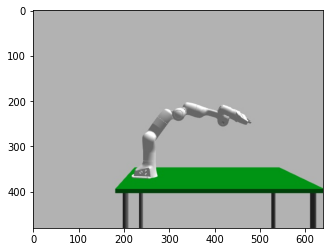

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[305.3357, 219.0473,   1.0000]],

        [[322.0262, 231.3957,   1.0000]],

        [[420.2561, 243.7971,   1.0000]],

        [[430.9842, 225.1364,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[311.0181, 223.6780,   1.0000]],

        [[326.4941, 237.5113,   1.0000]],

        [[425.1253, 238.3411,   1.0000]],

        [[435.3124, 252.6585,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[183.7597, 253.8187,   1.0000]],

        [[191.3630, 234.4631,   1.0000]],

        [[225.0226, 141.2040,   1.0000]],

        [[238.9737, 124.0103,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.3278, 213.2753,   1.0000]],

        [[314.5238, 223.27

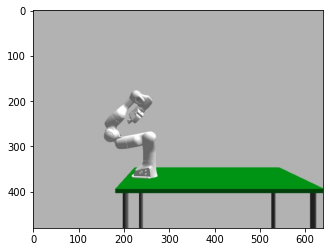

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[179.5886, 297.4313,   1.0000]],

        [[175.8112, 276.9839,   1.0000]],

        [[231.1792, 194.8995,   1.0000]],

        [[247.6216, 209.1048,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.4508, 207.2773,   1.0000]],

        [[302.2096, 213.6507,   1.0000]],

        [[398.7556, 191.5718,   1.0000]],

        [[387.0522, 173.7825,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.1593, 207.5100,   1.0000]],

        [[302.8578, 214.0687,   1.0000]],

        [[355.5940, 130.3975,   1.0000]],

        [[363.9785, 109.2500,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.5267, 234.7310,   1.0000]],

        [[207.1214, 218.18

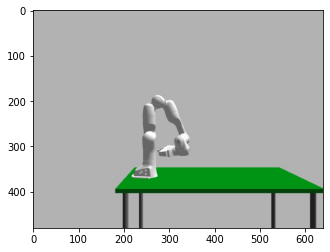

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[256.7500, 203.4168,   1.0000]],

        [[277.5195, 203.0910,   1.0000]],

        [[326.1642, 289.3025,   1.0000]],

        [[327.5235, 311.0709,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[296.1880, 213.1973,   1.0000]],

        [[314.4048, 223.1595,   1.0000]],

        [[319.3056, 322.0349,   1.0000]],

        [[321.6775, 344.4322,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.2303, 218.4725,   1.0000]],

        [[228.0742, 206.2816,   1.0000]],

        [[318.3316, 247.0897,   1.0000]],

        [[339.9905, 250.7722,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[257.0720, 203.4129,   1.0000]],

        [[277.8423, 203.17

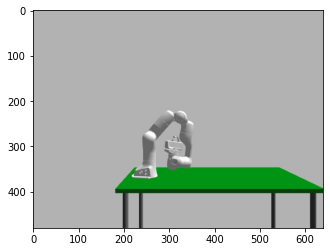

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.6364, 223.3395,   1.0000]],

        [[326.2030, 237.0711,   1.0000]],

        [[324.5331, 336.0280,   1.0000]],

        [[308.6958, 331.5922,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.3348, 207.2421,   1.0000]],

        [[302.1044, 213.5871,   1.0000]],

        [[376.4594, 148.3578,   1.0000]],

        [[384.6218, 127.1308,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[284.0009, 207.7984,   1.0000]],

        [[303.6255, 214.5784,   1.0000]],

        [[340.0495, 306.6397,   1.0000]],

        [[340.9780, 328.6377,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.6799, 234.5362,   1.0000]],

        [[207.3254, 218.02

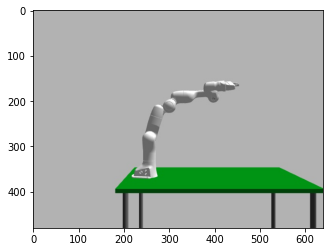

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[282.3800, 207.2545,   1.0000]],

        [[302.1447, 213.6094,   1.0000]],

        [[398.6508, 191.3534,   1.0000]],

        [[398.0154, 169.8192,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[178.4432, 276.7941,   1.0000]],

        [[180.0439, 256.0562,   1.0000]],

        [[233.1900, 172.4285,   1.0000]],

        [[252.0734, 183.6211,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[211.7183, 218.1221,   1.0000]],

        [[228.6507, 206.0577,   1.0000]],

        [[268.3877, 115.1729,   1.0000]],

        [[284.6057, 100.3382,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[283.5082, 207.6297,   1.0000]],

        [[303.1769, 214.28

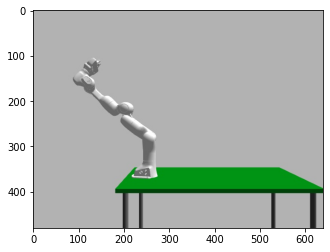

ground_truth_kp [tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[194.7391, 234.4614,   1.0000]],

        [[207.4040, 217.9685,   1.0000]],

        [[124.7669, 162.8809,   1.0000]],

        [[108.2081, 147.6916,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[258.2915, 203.4095,   1.0000]],

        [[279.0625, 203.4852,   1.0000]],

        [[350.0466, 134.4405,   1.0000]],

        [[371.3062, 135.5449,   1.0000]]], device='cuda:0'), tensor([[[257.9522, 366.9199,   1.0000]],

        [[257.9597, 283.0131,   1.0000]],

        [[310.7408, 223.4312,   1.0000]],

        [[326.2815, 237.1924,   1.0000]],

        [[421.4342, 263.2868,   1.0000]],

        [[424.0190, 279.8912,   1.0000]]], device='cuda:0')]
[[258, 367, 0.99996066, 1], [258, 283, 0.9999323, 2], [194, 233, 0.9997259, 3], [207, 218, 0.9996935, 4], [124, 163, 0.99857354, 5], [108, 147, 0.9952833, 

In [14]:
# Define the model
model = KeypointPipeline(weights_path)
model = model.to(device)

# Define the loss
criterion = TrifocalLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 1  # Define your number of epochs
batch_size = 4

KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = train_test_split(root_dir) +"/val"
KEYPOINTS_FOLDER_TEST = train_test_split(root_dir) +"/test"

dataset_train = KPDataset(KEYPOINTS_FOLDER_TRAIN, transform=None, demo=False)
dataset_val = KPDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = KPDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)
v = 1

model.train()
for epoch in range(num_epochs):
    # For each batch in your training data
    for batch in data_loader_train:
        img_tuple, target_dict_tuple, img_files = batch
        print("Processing images:", img_files)
        # Plot first image of the batch
        img_to_show = img_tuple[0].numpy().transpose((1, 2, 0))
        plt.imshow(img_to_show)
        plt.show()
        imgs = torch.stack(img_tuple).to(device)  # Stack images into a single tensor
        vertices_gt = [target['keypoints'].to(device) for target in target_dict_tuple]  # List of ground truth keypoints for each image
        print("ground_truth_kp", vertices_gt)
    
        # Forward pass
        output = model(imgs)  # Output will be a list of tuples, each containing vertices_pred, edges_prob, edges_gt for an image
        


        # Compute the losses
        loss = 0
        for i in range(len(output)):
            vertices_pred, edges_prob, edges_gt = output[i]
            vertices_gt_i = vertices_gt[i]
            trifocal_loss = criterion(vertices_pred, vertices_gt_i)
            ce_loss = edge_loss(edges_prob, edges_gt)

            # Combined loss
            loss += trifocal_loss + ce_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)   
        optimizer.step()

    # Print loss for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

model_save_path = f"/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_occ_b{batch_size}_e{num_epochs}_v{v}.pth"
    
# Save the state dict of the model, not the entire model
# torch.save(model.state_dict(), model_save_path)
    
torch.save(model, model_save_path)


# model.train()
# # Epoch loop
# for epoch in range(num_epochs):
#     # For each batch in your training data
#     for batch in data_loader_train:
#         img_tuple, target_dict_tuple = batch
#         img = img_tuple[0]
# #         print(img.shape)
#         target = target_dict_tuple[0]
#         img = img.to(device)
#         vertices_gt = target['keypoints'].to(device)
#         num_vertices = vertices_gt.shape[0]
#         print(num_vertices)
#         vertices_gt[:, :, 2] = torch.arange(1, num_vertices+1).unsqueeze(1).to(device)

#         # Forward pass
#         vertices_pred, edges_prob, edges_gt = model(img)
        
#         # Compute the losses
#         trifocal_loss = criterion(vertices_pred, vertices_gt)
#         ce_loss = edge_loss(edges_prob, edges_gt)

#         # Combined loss
#         loss = trifocal_loss + ce_loss
# #         loss = trifocal_loss

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
        
#         optimizer.step()

#     # Print loss for each epoch
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

In [ ]:
def visualize_and_save(img, vertices, filename):
    print("type of image befor conversion",type(img))    
    print("type of vertices before conversion", type(vertices))
    print(img)
    img = (img.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
#     img = (img * 255).astype(np.uint8)  # Convert back from [0, 1] range to [0, 255]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    vertices = vertices.cpu().numpy()

    print(f"Image shape before saving: {img.shape}")  # print the image shape
    print("type of vertices", type(vertices))
#     print("entered vertices", vertices)
#     print("entered image", img)

    # Convert grayscale to BGR if necessary
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
    for i in range(vertices.shape[0]):
        img = cv2.circle(img, (int(vertices[i, 0]), int(vertices[i, 1])), radius=2, color=(0, 0, 255), thickness=-1)
        
    result = cv2.imwrite(filename, img)
    print(f"Image saved at {filename}: {result}")  # print if save was successful

    # If the image didn't save correctly, save the image data to a text file for examination
    if not result:
        with open(filename + ".txt", "w") as f:
            np.savetxt(f, img.flatten())

In [20]:
def test_and_save_model(model, data_loader_test):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_trifocal_loss = 0.0
    total_ce_loss = 0.0
    num_batches = 0

    # We don't need to track gradients during evaluation
    with torch.no_grad():
        for idx, batch in enumerate(data_loader_test):
            img_tuple, target_dict_tuple, img_file = batch

            total_batch_loss = 0.0
            total_batch_trifocal_loss = 0.0
            total_batch_ce_loss = 0.0

            for i in range(len(img_tuple)):
                img = img_tuple[i].to(device)
                target = target_dict_tuple[i]

                vertices_gt = target['keypoints'].to(device)
                num_vertices = vertices_gt.shape[0]
                vertices_gt[:, :, 2] = torch.arange(1, num_vertices+1).unsqueeze(1).to(device)

                # Forward pass
                output = model(img.unsqueeze(0))
                print("Output per img", output[0])
                vertices_pred, edges_prob, edges_gt = output[0]                
                

                # Print the shapes for debugging
                print(f"img shape: {img.shape}, vertices_pred shape: {vertices_pred.shape}")

                # Compute the losses
                trifocal_loss = criterion(vertices_pred, vertices_gt)
                ce_loss = edge_loss(edges_prob, edges_gt)

                # Combined loss
                loss = trifocal_loss + ce_loss

                total_batch_loss += loss.item()
                total_batch_trifocal_loss += trifocal_loss.item()
                total_batch_ce_loss += ce_loss.item()

                # Visualize and save the prediction
                filename = f'/home/jc-merlab/Pictures/Data/occ_vis_data/image_{idx}_{i}.jpg'
                visualize_and_save(img, vertices_pred, filename)
                print(f"Image saved at {filename}")  # Print statement to confirm image save
            
            total_loss += total_batch_loss / len(img_tuple)
            total_trifocal_loss += total_batch_trifocal_loss / len(img_tuple)
            total_ce_loss += total_batch_ce_loss / len(img_tuple)
            num_batches += 1
    
    # Average the loss over all batches
    avg_loss = total_loss / num_batches
    avg_trifocal_loss = total_trifocal_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    
    print(f'Avg. Test Loss: {avg_loss}, Avg. Trifocal Loss: {avg_trifocal_loss}, Avg. Cross Entropy Loss: {avg_ce_loss}')
    return avg_loss, avg_trifocal_loss, avg_ce_loss

In [82]:
def test_model(model, data_loader_test):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_trifocal_loss = 0.0
    total_ce_loss = 0.0
    num_batches = 0
    
    all_vertices_pred = []  # List to store all predicted vertices
    
    # We don't need to track gradients during evaluation
    with torch.no_grad():
        for batch in data_loader_test:
            img_tuple, target_dict_tuple, img_file = batch
            
            total_batch_loss = 0.0
            total_batch_trifocal_loss = 0.0
            total_batch_ce_loss = 0.0

            for i in range(len(img_tuple)):
                img = img_tuple[i].to(device)
                target = target_dict_tuple[i]

                vertices_gt = target['keypoints'].to(device)
                num_vertices = vertices_gt.shape[0]
                vertices_gt[:, :, 2] = torch.arange(1, num_vertices+1).unsqueeze(1).to(device)

                # Forward pass
                output = model(img.unsqueeze(0))
                print("Output per img", output[0])
                vertices_pred, edges_prob, edges_gt = output[0]

                # Compute the losses
                trifocal_loss = criterion(vertices_pred, vertices_gt)
                ce_loss = edge_loss(edges_prob, edges_gt)

                # Combined loss
                loss = trifocal_loss + ce_loss

                total_batch_loss += loss.item()
                total_batch_trifocal_loss += trifocal_loss.item()
                total_batch_ce_loss += ce_loss.item()

                # Save the predictions for this image
                all_vertices_pred.append(vertices_pred.cpu().numpy())
            
            total_loss += total_batch_loss / len(img_tuple)
            total_trifocal_loss += total_batch_trifocal_loss / len(img_tuple)
            total_ce_loss += total_batch_ce_loss / len(img_tuple)
            num_batches += 1
    
    # Average the loss over all batches
    avg_loss = total_loss / num_batches
    avg_trifocal_loss = total_trifocal_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    
    print(f'Avg. Test Loss: {avg_loss}, Avg. Trifocal Loss: {avg_trifocal_loss}, Avg. Cross Entropy Loss: {avg_ce_loss}, All Predicted Vertices: {all_vertices_pred}')
    return avg_loss, avg_trifocal_loss, avg_ce_loss, all_vertices_pred

In [21]:
# avg_loss, avg_trifocal_loss, avg_ce_loss, all_preds = test_and_save_model(model, data_loader_test)

avg_loss, avg_trifocal_loss, avg_ce_loss = test_and_save_model(model, data_loader_test)

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [236.9707, 294.5504,  21.1286],
        [154.1622, 309.9083,  19.6380],
        [161.7301, 288.4437,  21.0059],
        [212.1253, 205.8226,  21.7504],
        [204.4948, 223.9656,  35.0076]], device='cuda:0'), tensor([[2.6033e-20, 3.2781e-14, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         2.6686e-06, 8.2732e-06, 3.8995e-05, 9.0420e-13, 9.7556e-01, 2.5707e-21,
         9.9998e-01, 2.3288e-11, 4.3911e-04, 6.3744e-20, 7.7668e-28, 9.9991e-01,
         1.6538e-07, 1.0000e+00, 9.5112e-01, 1.8762e-01, 1.0000e+00, 1.2511e-25,
         1.0000e+00, 1.0000e+00, 2.4794e-08, 1.5393e-28, 1.0000e+00, 1.0000e+00,
         2.4638e-12, 1.0000e+00, 1.0000e+00, 9.9999e-01, 6.9015e-28, 5.9988e-16,
         9.9953e-01, 1.0000e+00, 1.0000e+00, 7.7040e-03, 1.0000e+00, 1.2590e-02,
         4.7395e-01, 1.0000e+00, 9.9989e-01, 5.8023e-17, 1.0000e+00, 4.0034e-09,
         9.9702e-01, 4.1154e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 6.3899e-

/tmp/ipykernel_22992/4205303711.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = (vertices_gt - torch.tensor(vertices_pred)).pow(2).mean()  # Changed from sum() to mean()


type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [243.3905, 293.8263,  20.1515],
        [152.9352, 311.2681,  20.9344],
        [161.8303, 287.3467,  20.9664],
        [115.4780, 192.1092,  16.1234],
        [116.4620, 194.8673,  27.8580]], device='cuda:0'), tensor([[2.2808e-20, 2.5522e-12, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         3.4109e-07, 3.0795e-05, 8.0341e-05, 8.5231e-13, 9.3519e-01, 3.1171e-20,
         9.9959e-01, 1.0350e-10, 3.9629e-04, 1.0043e-18, 2.0156e-29, 9.9999e-01,
         4.8509e-07, 1.0000e+00, 9.8643e-01, 5.2959e-01, 1.0000e+00, 6.4638e-22,
         1.0000e+00, 1.0000e+00, 6.5391e-08, 2.5426e-26, 1.0000e+00, 9.9972e-01,
         3.3305e-13, 1.0000e+00, 1.0000e+00, 9.9999e-01, 2.1323e-27, 3.5655e-15,
         9.7271e-01, 1.0000e+00, 1.0000e+00, 5.6440e-04, 1.0000e+00, 8.8604e-02,
         8.0825e-01, 1.0000e+00, 9.9975e-01, 1.3335e-14, 1.0000e+00, 5.3043e-12,
         9.7520e-01, 1.3769e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00, 7.0592e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [242.7990, 293.7978,  18.9300],
        [155.9143, 312.5832,  17.4776],
        [160.7144, 288.4023,  20.9750],
        [ 63.1221, 256.3213,  17.2255],
        [ 23.9945, 241.6176,  32.7318]], device='cuda:0'), tensor([[1.9334e-19, 1.7626e-11, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         3.2203e-07, 1.8698e-05, 8.6486e-05, 6.9460e-14, 6.8237e-01, 5.4405e-20,
         9.9361e-01, 2.6827e-12, 5.8169e-04, 4.1865e-17, 4.1633e-31, 1.0000e+00,
         8.4910e-07, 1.0000e+00, 9.6046e-01, 3.1473e-01, 1.0000e+00, 3.4878e-19,
         1.0000e+00, 1.0000e+00, 2.4587e-07, 1.5177e-25, 1.0000e+00, 9.9946e-01,
         1.4064e-12, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.0850e-27, 4.9291e-16,
         5.2102e-01, 1.0000e+00, 1.0000e+00, 3.7179e-04, 1.0000e+00, 6.2929e-01,
         9.3748e-01, 1.0000e+00, 9.9991e-01, 1.1820e-13, 1.0000e+00, 1.0660e-13,
         9.9905e-01, 2.3269e-15, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.3691e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [243.2988, 293.5027,  19.5906],
        [154.6176, 287.7453,  17.1021],
        [165.8049, 264.1982,  19.8015],
        [ 69.4904, 230.9682,  16.4385],
        [ 52.4898, 211.8948,  29.4569]], device='cuda:0'), tensor([[6.6893e-20, 1.7103e-11, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         2.0057e-07, 3.0999e-05, 9.4076e-05, 2.3335e-13, 8.1471e-01, 7.3449e-20,
         9.9678e-01, 2.2717e-11, 4.7514e-04, 1.2488e-17, 1.4860e-30, 1.0000e+00,
         7.7266e-07, 1.0000e+00, 9.8129e-01, 5.0543e-01, 1.0000e+00, 9.7749e-20,
         1.0000e+00, 1.0000e+00, 1.5581e-07, 1.8324e-25, 1.0000e+00, 9.9893e-01,
         4.6051e-13, 1.0000e+00, 1.0000e+00, 9.9999e-01, 6.0145e-27, 2.0009e-15,
         7.1336e-01, 1.0000e+00, 1.0000e+00, 2.6488e-04, 1.0000e+00, 3.9247e-01,
         9.1927e-01, 1.0000e+00, 9.9982e-01, 1.2442e-13, 1.0000e+00, 1.8296e-13,
         9.9256e-01, 7.5425e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.6159e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [245.8235, 292.7184,  20.1537],
        [153.6292, 290.2002,  18.8399],
        [165.9105, 265.1848,  19.8538],
        [ 98.0601, 186.8278,  15.2965],
        [ 74.3121, 167.5721,  25.0398]], device='cuda:0'), tensor([[1.4770e-20, 2.5420e-11, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         9.9909e-08, 7.3760e-05, 1.2259e-04, 1.2474e-12, 9.1479e-01, 1.2748e-19,
         9.9819e-01, 4.6573e-10, 3.4956e-04, 2.8384e-18, 4.2695e-30, 9.9999e-01,
         8.4440e-07, 1.0000e+00, 9.9484e-01, 7.7211e-01, 1.0000e+00, 3.8926e-20,
         1.0000e+00, 1.0000e+00, 9.4040e-08, 4.0788e-25, 1.0000e+00, 9.9555e-01,
         7.8672e-14, 1.0000e+00, 1.0000e+00, 9.9999e-01, 3.3035e-27, 1.4470e-14,
         8.4486e-01, 1.0000e+00, 1.0000e+00, 1.2509e-04, 1.0000e+00, 1.7024e-01,
         8.9623e-01, 1.0000e+00, 9.9952e-01, 2.4435e-13, 1.0000e+00, 1.8855e-13,
         8.6282e-01, 1.7802e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0715e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [244.3775, 292.3524,  20.5658],
        [154.3806, 287.0636,  18.6493],
        [165.7515, 266.2857,  19.8989],
        [143.6501, 162.7448,  16.1896],
        [121.1470, 144.1840,  21.3518]], device='cuda:0'), tensor([[5.5710e-21, 8.8784e-12, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.1094e-07, 8.8195e-05, 1.1530e-04, 3.9471e-12, 9.6393e-01, 8.9798e-20,
         9.9955e-01, 2.3490e-09, 2.9429e-04, 4.6201e-19, 2.9066e-29, 9.9998e-01,
         6.2700e-07, 1.0000e+00, 9.9671e-01, 8.2794e-01, 1.0000e+00, 1.5707e-21,
         1.0000e+00, 1.0000e+00, 4.9377e-08, 1.4801e-25, 1.0000e+00, 9.9723e-01,
         4.3857e-14, 1.0000e+00, 1.0000e+00, 9.9999e-01, 1.6281e-27, 3.3501e-14,
         9.6925e-01, 1.0000e+00, 1.0000e+00, 1.6738e-04, 1.0000e+00, 4.8675e-02,
         8.1985e-01, 1.0000e+00, 9.9928e-01, 7.3044e-14, 1.0000e+00, 1.4557e-12,
         6.0178e-01, 4.6501e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 6.6115e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [240.0301, 293.4358,  20.8806],
        [153.3980, 286.0582,  18.1769],
        [165.9105, 265.1848,  19.8538],
        [193.8462, 168.4351,  18.6566],
        [192.0196, 188.8272,  27.2412]], device='cuda:0'), tensor([[1.0601e-20, 1.7697e-13, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         8.6509e-07, 2.0893e-05, 5.6748e-05, 2.3014e-12, 9.7923e-01, 8.3531e-21,
         9.9997e-01, 2.1921e-10, 3.5759e-04, 7.0484e-20, 4.5164e-28, 9.9993e-01,
         2.4301e-07, 1.0000e+00, 9.8413e-01, 4.4148e-01, 1.0000e+00, 1.3082e-24,
         1.0000e+00, 1.0000e+00, 2.5563e-08, 1.3379e-27, 1.0000e+00, 9.9997e-01,
         4.6236e-13, 1.0000e+00, 1.0000e+00, 9.9999e-01, 7.4071e-28, 3.4818e-15,
         9.9880e-01, 1.0000e+00, 1.0000e+00, 2.1065e-03, 1.0000e+00, 1.2980e-02,
         5.6652e-01, 1.0000e+00, 9.9975e-01, 5.2067e-16, 1.0000e+00, 4.4686e-10,
         9.6605e-01, 2.7139e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 6.8456e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [235.2489, 293.9158,  22.0236],
        [155.8167, 285.4524,  18.1872],
        [164.8706, 266.2212,  19.8653],
        [235.0937, 202.1465,  21.1454],
        [227.1956, 218.6418,  34.4123]], device='cuda:0'), tensor([[1.8456e-20, 1.5250e-14, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         3.3202e-06, 7.8697e-06, 3.5792e-05, 1.3834e-12, 9.8383e-01, 1.8179e-21,
         9.9999e-01, 3.6868e-11, 4.1612e-04, 2.5821e-20, 2.1529e-27, 9.9984e-01,
         1.3501e-07, 1.0000e+00, 9.5337e-01, 1.8597e-01, 1.0000e+00, 1.8342e-26,
         1.0000e+00, 1.0000e+00, 1.8006e-08, 6.7982e-29, 1.0000e+00, 1.0000e+00,
         2.3726e-12, 1.0000e+00, 1.0000e+00, 9.9999e-01, 4.8299e-28, 6.9694e-16,
         9.9983e-01, 1.0000e+00, 1.0000e+00, 1.0746e-02, 1.0000e+00, 6.3897e-03,
         3.8387e-01, 1.0000e+00, 9.9988e-01, 2.3195e-17, 1.0000e+00, 1.5079e-08,
         9.9584e-01, 2.2690e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.5477e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [231.4785, 292.8719,  23.4836],
        [164.2124, 260.9112,  16.0734],
        [176.3349, 244.1816,  18.7106],
        [261.6706, 208.4250,  20.5438],
        [253.2701, 215.2343,  31.8212]], device='cuda:0'), tensor([[1.3650e-20, 5.7416e-15, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         4.6293e-06, 6.8997e-06, 3.1590e-05, 2.0383e-12, 9.8960e-01, 1.1286e-21,
         1.0000e+00, 5.0589e-11, 3.9911e-04, 9.5306e-21, 6.8673e-27, 9.9970e-01,
         1.0475e-07, 1.0000e+00, 9.5146e-01, 1.6933e-01, 1.0000e+00, 1.8490e-27,
         1.0000e+00, 1.0000e+00, 1.2657e-08, 2.3244e-29, 1.0000e+00, 1.0000e+00,
         2.6158e-12, 1.0000e+00, 1.0000e+00, 9.9998e-01, 3.2500e-28, 7.0964e-16,
         9.9995e-01, 1.0000e+00, 1.0000e+00, 1.7176e-02, 1.0000e+00, 3.0250e-03,
         2.8752e-01, 1.0000e+00, 9.9988e-01, 7.0931e-18, 1.0000e+00, 7.7132e-08,
         9.9513e-01, 1.2247e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.5311e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [236.4517, 289.4379,  22.4935],
        [161.2306, 259.2188,  11.8437],
        [176.3349, 244.1816,  18.7106],
        [208.9768, 147.5306,  17.3500],
        [204.5152, 144.0644,  19.2935]], device='cuda:0'), tensor([[2.7346e-21, 3.1986e-13, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         3.8856e-07, 4.8274e-05, 7.2771e-05, 1.0340e-11, 9.9004e-01, 1.6393e-20,
         9.9998e-01, 3.7137e-09, 2.7151e-04, 2.2286e-20, 1.0882e-27, 9.9989e-01,
         2.6753e-07, 1.0000e+00, 9.9518e-01, 7.2192e-01, 1.0000e+00, 9.1436e-25,
         1.0000e+00, 1.0000e+00, 1.6922e-08, 3.5868e-27, 1.0000e+00, 9.9987e-01,
         8.5340e-14, 1.0000e+00, 1.0000e+00, 9.9998e-01, 4.8454e-28, 2.3953e-14,
         9.9925e-01, 1.0000e+00, 1.0000e+00, 9.3815e-04, 1.0000e+00, 5.2324e-03,
         5.3036e-01, 1.0000e+00, 9.9937e-01, 1.2547e-15, 1.0000e+00, 3.2710e-10,
         6.1726e-01, 7.9250e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0903e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [243.8126, 292.0788,  20.6703],
        [158.8609, 264.3316,  17.4474],
        [176.2458, 245.2720,  18.7551],
        [135.0769, 147.3305,  14.6339],
        [129.7244, 137.7063,  21.5318]], device='cuda:0'), tensor([[4.1483e-21, 7.8824e-12, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0447e-07, 9.8565e-05, 1.1691e-04, 5.5391e-12, 9.7100e-01, 9.0396e-20,
         9.9965e-01, 4.0541e-09, 2.7839e-04, 3.0476e-19, 4.3661e-29, 9.9998e-01,
         6.0205e-07, 1.0000e+00, 9.9729e-01, 8.5135e-01, 1.0000e+00, 8.8564e-22,
         1.0000e+00, 1.0000e+00, 4.2583e-08, 1.3741e-25, 1.0000e+00, 9.9704e-01,
         3.3754e-14, 1.0000e+00, 1.0000e+00, 9.9999e-01, 1.3876e-27, 4.6495e-14,
         9.7790e-01, 1.0000e+00, 1.0000e+00, 1.6248e-04, 1.0000e+00, 3.5763e-02,
         8.0119e-01, 1.0000e+00, 9.9915e-01, 6.4967e-14, 1.0000e+00, 1.9897e-12,
         4.7388e-01, 3.2952e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 7.0568e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [245.0249, 292.3909,  20.4578],
        [159.0775, 266.6779,  17.6862],
        [176.2458, 245.2720,  18.7551],
        [112.8566, 163.2733,  14.6444],
        [101.7944, 147.6199,  22.5746]], device='cuda:0'), tensor([[6.7640e-21, 1.7639e-11, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         8.7214e-08, 9.7595e-05, 1.2613e-04, 3.0676e-12, 9.5180e-01, 1.2610e-19,
         9.9914e-01, 1.9482e-09, 3.0200e-04, 9.1189e-19, 1.3103e-29, 9.9999e-01,
         7.4892e-07, 1.0000e+00, 9.9685e-01, 8.4081e-01, 1.0000e+00, 7.7188e-21,
         1.0000e+00, 1.0000e+00, 6.2794e-08, 3.1591e-25, 1.0000e+00, 9.9493e-01,
         4.0179e-14, 1.0000e+00, 1.0000e+00, 9.9999e-01, 2.1342e-27, 3.3835e-14,
         9.3353e-01, 1.0000e+00, 1.0000e+00, 1.1912e-04, 1.0000e+00, 7.8650e-02,
         8.6006e-01, 1.0000e+00, 9.9928e-01, 1.6828e-13, 1.0000e+00, 4.6596e-13,
         6.2017e-01, 7.0393e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.2072e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [235.6197, 288.0114,  21.9043],
        [172.5176, 239.8056,  10.0509],
        [191.3336, 228.4115,  17.8304],
        [198.0251, 124.6404,  14.9046],
        [176.4956, 105.7778,  11.7769]], device='cuda:0'), tensor([[1.1658e-21, 2.6432e-12, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         9.7883e-08, 1.3348e-04, 1.0953e-04, 2.4766e-11, 9.9038e-01, 7.0508e-20,
         9.9993e-01, 3.8250e-08, 2.2244e-04, 3.5263e-20, 4.8639e-28, 9.9994e-01,
         4.1757e-07, 1.0000e+00, 9.9856e-01, 9.1162e-01, 1.0000e+00, 2.3453e-23,
         1.0000e+00, 1.0000e+00, 1.9314e-08, 5.0293e-26, 1.0000e+00, 9.9784e-01,
         1.3959e-14, 1.0000e+00, 1.0000e+00, 9.9998e-01, 6.2882e-28, 1.6543e-13,
         9.9698e-01, 1.0000e+00, 1.0000e+00, 2.0221e-04, 1.0000e+00, 6.8921e-03,
         6.6331e-01, 1.0000e+00, 9.9848e-01, 1.8612e-14, 1.0000e+00, 1.9120e-11,
         1.0787e-01, 6.1910e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 5.0005e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [230.8007, 288.7922,  24.0239],
        [174.8785, 238.2917,  10.0387],
        [191.3336, 228.4115,  17.8304],
        [244.2387, 148.4465,  17.0549],
        [240.1434, 160.7202,  18.2531]], device='cuda:0'), tensor([[2.9347e-21, 5.2853e-14, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         8.4996e-07, 2.7573e-05, 5.2263e-05, 1.0525e-11, 9.9341e-01, 6.1254e-21,
         9.9999e-01, 2.0617e-09, 2.8548e-04, 7.4198e-21, 5.6514e-27, 9.9975e-01,
         1.6368e-07, 1.0000e+00, 9.9133e-01, 5.8045e-01, 1.0000e+00, 2.7020e-26,
         1.0000e+00, 1.0000e+00, 1.1214e-08, 4.2923e-28, 1.0000e+00, 9.9998e-01,
         1.9773e-13, 1.0000e+00, 1.0000e+00, 9.9998e-01, 3.2314e-28, 1.2095e-14,
         9.9986e-01, 1.0000e+00, 1.0000e+00, 2.7912e-03, 1.0000e+00, 2.2878e-03,
         3.7896e-01, 1.0000e+00, 9.9956e-01, 1.2933e-16, 1.0000e+00, 5.1638e-09,
         7.9597e-01, 4.8429e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.3320e-

tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [229.4926, 292.2963,  24.0211],
        [176.4033, 240.9243,  14.5965],
        [190.4693, 228.3215,  17.7823],
        [275.6921, 196.2271,  19.0411],
        [263.8236, 217.8099,  29.3817]], device='cuda:0'), tensor([[1.2394e-20, 3.5765e-15, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         5.5447e-06, 6.3169e-06, 2.9569e-05, 2.3252e-12, 9.9134e-01, 8.8476e-22,
         1.0000e+00, 5.3485e-11, 3.9493e-04, 6.2233e-21, 1.1447e-26, 9.9960e-01,
         9.2798e-08, 1.0000e+00, 9.4869e-01, 1.5685e-01, 1.0000e+00, 6.4359e-28,
         1.0000e+00, 1.0000e+00, 1.0888e-08, 1.3669e-29, 1.0000e+00, 1.0000e+00,
         2.8908e-12, 1.0000e+00, 1.0000e+00, 9.9998e-01, 2.7405e-28, 6.7239e-16,
         9.9997e-01, 1.0000e+00, 1.0000e+00, 2.1888e-02, 1.0000e+00, 2.1992e-03,
         2.4887e-01, 1.0000e+00, 9.9988e-01, 3.9740e-18, 1.0000e+00, 1.6643e-07,
         9.9522e-01, 9.5675e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.8666e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [231.7572, 294.4603,  22.7827],
        [177.0482, 242.4783,  17.2373],
        [190.4693, 228.3215,  17.7823],
        [284.5148, 252.8719,  21.1147],
        [274.1596, 273.1131,  38.0020]], device='cuda:0'), tensor([[6.0650e-20, 6.1812e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         2.3099e-05, 1.7457e-06, 1.8591e-05, 4.2059e-13, 9.8424e-01, 2.2027e-22,
         1.0000e+00, 1.4375e-12, 5.5561e-04, 1.1805e-20, 1.0285e-26, 9.9961e-01,
         6.3699e-08, 1.0000e+00, 7.7045e-01, 3.1125e-02, 1.0000e+00, 1.1738e-28,
         1.0000e+00, 1.0000e+00, 1.3758e-08, 1.2478e-30, 1.0000e+00, 1.0000e+00,
         3.2963e-11, 1.0000e+00, 1.0000e+00, 9.9999e-01, 3.3754e-28, 4.7320e-17,
         9.9998e-01, 1.0000e+00, 1.0000e+00, 9.7764e-02, 1.0000e+00, 3.8049e-03,
         2.1111e-01, 1.0000e+00, 9.9997e-01, 3.7784e-19, 1.0000e+00, 1.2242e-06,
         9.9989e-01, 2.9159e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 5.4697e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [225.7426, 291.1845,  24.6323],
        [195.5727, 222.5851,  11.4689],
        [210.3399, 218.0080,  17.4791],
        [302.7549, 221.3826,  18.7388],
        [289.7585, 217.0218,  27.0847]], device='cuda:0'), tensor([[9.1210e-21, 1.2956e-15, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         7.8543e-06, 5.4909e-06, 2.5950e-05, 3.4518e-12, 9.9452e-01, 5.3810e-22,
         1.0000e+00, 7.3311e-11, 3.7866e-04, 2.2258e-21, 3.7956e-26, 9.9924e-01,
         7.1296e-08, 1.0000e+00, 9.4626e-01, 1.4120e-01, 9.9998e-01, 5.9720e-29,
         1.0000e+00, 1.0000e+00, 7.5698e-09, 4.4729e-30, 1.0000e+00, 1.0000e+00,
         3.2229e-12, 1.0000e+00, 1.0000e+00, 9.9998e-01, 1.8208e-28, 6.7921e-16,
         9.9999e-01, 1.0000e+00, 1.0000e+00, 3.5464e-02, 1.0000e+00, 1.0147e-03,
         1.7447e-01, 1.0000e+00, 9.9988e-01, 1.1588e-18, 1.0000e+00, 9.0532e-07,
         9.9443e-01, 5.0764e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.1008e-

Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_54_0.jpg: True
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_54_0.jpg
Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [230.7811, 287.4703,  25.0585],
        [192.5625, 219.6949,   8.3211],
        [211.2935, 218.0919,  17.5101],
        [266.3479, 144.2496,  15.4739],
        [250.7549, 128.0119,  10.9397]], device='cuda:0'), tensor([[1.0172e-21, 7.6703e-14, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         5.1024e-07, 5.2178e-05, 6.4485e-05, 3.3843e-11, 9.9638e-01, 9.3685e-21,
         1.0000e+00, 1.7310e-08, 2.2948e-04, 2.7773e-21, 1.0423e-26, 9.9964e-01,
         1.8085e-07, 1.0000e+00, 9.9663e-01, 7.6613e-01, 9.9999e-01, 1.7132e-26,
         1.0000e+00, 1.0000e+00, 8.0872e-09, 8.4211e-28, 1.0000e+00, 9.9995e-01,
         5.5047e-14, 1.0000e+00, 1.0000e+00, 9.9997e-01, 2.1427e-28, 4.9093e-14,
         9.9991e-01, 1.0000e+00, 1.0000e+00, 1.5597e-03, 1.0000e+00, 1.0749e-03,
      

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [229.7095, 288.2690,  25.0672],
        [193.1517, 219.9518,   8.7243],
        [211.2935, 218.0919,  17.5101],
        [266.4212, 145.3494,  15.5235],
        [262.2016, 151.6160,  15.6301]], device='cuda:0'), tensor([[1.6629e-21, 2.6718e-14, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0043e-06, 3.0263e-05, 5.1402e-05, 2.0428e-11, 9.9616e-01, 4.5627e-21,
         1.0000e+00, 4.8900e-09, 2.5736e-04, 2.4068e-21, 1.5729e-26, 9.9955e-01,
         1.4178e-07, 1.0000e+00, 9.9342e-01, 6.1497e-01, 9.9999e-01, 3.6432e-27,
         1.0000e+00, 1.0000e+00, 7.7100e-09, 2.2113e-28, 1.0000e+00, 9.9999e-01,
         1.4548e-13, 1.0000e+00, 1.0000e+00, 9.9997e-01, 1.9886e-28, 1.7860e-14,
         9.9995e-01, 1.0000e+00, 1.0000e+00, 3.4325e-03, 1.0000e+00, 9.9026e-04,
         2.8690e-01, 1.0000e+00, 9.9944e-01, 6.0052e-17, 1.0000e+00, 1.8397e-08,
         6.4389e-01, 2.1899e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0667e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [233.3746, 286.9637,  23.7905],
        [190.5399, 221.1030,   8.4532],
        [211.2935, 218.0919,  17.5101],
        [224.2839, 115.1223,  14.0055],
        [214.0606, 105.7709,   8.9791]], device='cuda:0'), tensor([[7.5841e-22, 5.8986e-13, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.7787e-07, 1.0825e-04, 9.2860e-05, 4.2765e-11, 9.9500e-01, 3.1953e-20,
         9.9998e-01, 5.4876e-08, 2.0902e-04, 7.7573e-21, 2.3914e-27, 9.9984e-01,
         2.9680e-07, 1.0000e+00, 9.9847e-01, 8.9064e-01, 1.0000e+00, 7.2242e-25,
         1.0000e+00, 1.0000e+00, 1.1591e-08, 9.6891e-27, 1.0000e+00, 9.9943e-01,
         1.6864e-14, 1.0000e+00, 1.0000e+00, 9.9997e-01, 3.2884e-28, 1.5152e-13,
         9.9949e-01, 1.0000e+00, 1.0000e+00, 4.2288e-04, 1.0000e+00, 2.2615e-03,
         5.0051e-01, 1.0000e+00, 9.9846e-01, 3.0766e-15, 1.0000e+00, 2.2487e-10,
         9.4372e-02, 2.5115e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.3596e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [243.6196, 291.5797,  20.4908],
        [185.9695, 232.3062,  14.9555],
        [210.3399, 218.0080,  17.4791],
        [155.0775, 129.5090,  12.7451],
        [122.2293, 115.5842,  15.4426]], device='cuda:0'), tensor([[2.5121e-21, 2.0948e-11, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         5.4783e-08, 1.6703e-04, 1.4499e-04, 9.3157e-12, 9.7327e-01, 1.7813e-19,
         9.9946e-01, 1.4321e-08, 2.4807e-04, 3.3020e-19, 3.1263e-29, 9.9998e-01,
         7.5309e-07, 1.0000e+00, 9.9859e-01, 9.2016e-01, 1.0000e+00, 3.5288e-21,
         1.0000e+00, 1.0000e+00, 4.3684e-08, 4.7927e-25, 1.0000e+00, 9.8828e-01,
         1.3061e-14, 1.0000e+00, 1.0000e+00, 9.9999e-01, 1.4577e-27, 1.2578e-13,
         9.6205e-01, 1.0000e+00, 1.0000e+00, 7.6881e-05, 1.0000e+00, 3.6991e-02,
         8.3403e-01, 1.0000e+00, 9.9864e-01, 2.3132e-13, 1.0000e+00, 5.5350e-13,
         1.8314e-01, 2.6409e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.7550e-

Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_65_0.jpg: True
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_65_0.jpg
Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [226.6015, 290.2174,  25.1041],
        [215.5094, 210.3262,   9.5093],
        [231.9940, 215.3610,  17.6210],
        [306.7805, 169.8171,  15.0902],
        [296.8162, 175.9284,  18.7332]], device='cuda:0'), tensor([[2.1969e-21, 3.0943e-15, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         3.0211e-06, 1.4215e-05, 3.5088e-05, 1.6535e-11, 9.9733e-01, 1.2577e-21,
         1.0000e+00, 1.5376e-09, 2.8230e-04, 7.8395e-22, 7.7008e-26, 9.9891e-01,
         8.3897e-08, 1.0000e+00, 9.8525e-01, 3.8437e-01, 9.9996e-01, 6.7387e-29,
         1.0000e+00, 1.0000e+00, 5.2028e-09, 1.6847e-29, 1.0000e+00, 1.0000e+00,
         4.9106e-13, 1.0000e+00, 1.0000e+00, 9.9997e-01, 1.2474e-28, 5.6495e-15,
         9.9999e-01, 1.0000e+00, 1.0000e+00, 1.3370e-02, 1.0000e+00, 4.3832e-04,
      

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [226.1123, 293.8879,  24.3492],
        [216.7089, 214.0569,  14.4529],
        [232.9002, 215.4403,  17.6351],
        [321.8080, 251.9190,  17.6819],
        [313.6420, 266.5818,  31.4139]], device='cuda:0'), tensor([[2.7176e-20, 1.6200e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         3.1307e-05, 1.7659e-06, 1.6368e-05, 1.1107e-12, 9.9334e-01, 1.2634e-22,
         1.0000e+00, 4.7660e-12, 4.8625e-04, 1.9308e-21, 7.5292e-26, 9.9887e-01,
         4.4330e-08, 1.0000e+00, 8.1020e-01, 3.5201e-02, 9.9997e-01, 3.2456e-30,
         1.0000e+00, 1.0000e+00, 7.2427e-09, 3.1198e-31, 1.0000e+00, 1.0000e+00,
         2.4938e-11, 1.0000e+00, 1.0000e+00, 9.9998e-01, 1.6573e-28, 7.9256e-17,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.5411e-01, 1.0000e+00, 9.6293e-04,
         1.1741e-01, 1.0000e+00, 9.9996e-01, 7.7568e-20, 1.0000e+00, 1.3616e-05,
         9.9972e-01, 8.3421e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.2255e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [232.5376, 295.4557,  21.8555],
        [236.7309, 213.2310,  18.3395],
        [254.4979, 219.8218,  17.8465],
        [299.5862, 316.8027,  20.4260],
        [295.7725, 337.9961,  45.4730]], device='cuda:0'), tensor([[3.1186e-19, 5.3403e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.3500e-04, 3.8590e-07, 1.0385e-05, 7.4366e-14, 9.7521e-01, 3.6598e-23,
         1.0000e+00, 2.8812e-14, 7.9892e-04, 1.4914e-20, 1.6051e-26, 9.9949e-01,
         3.6880e-08, 1.0000e+00, 3.2579e-01, 4.2045e-03, 1.0000e+00, 5.6679e-30,
         1.0000e+00, 1.0000e+00, 1.5070e-08, 5.0196e-32, 1.0000e+00, 1.0000e+00,
         5.3277e-10, 1.0000e+00, 1.0000e+00, 9.9999e-01, 3.5169e-28, 2.4189e-18,
         9.9999e-01, 1.0000e+00, 1.0000e+00, 4.4572e-01, 1.0000e+00, 4.8891e-03,
         1.4555e-01, 1.0000e+00, 9.9999e-01, 1.5070e-20, 1.0000e+00, 2.5541e-05,
         1.0000e+00, 7.5535e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.4073e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [232.3899, 295.4729,  21.9136],
        [237.7619, 213.2977,  18.3553],
        [254.4575, 219.7818,  17.8167],
        [318.4904, 304.1652,  19.4413],
        [297.9319, 334.0981,  41.6029]], device='cuda:0'), tensor([[2.7973e-19, 5.1817e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.3122e-04, 4.0363e-07, 1.0461e-05, 8.4203e-14, 9.7707e-01, 3.6974e-23,
         1.0000e+00, 3.5369e-14, 7.8254e-04, 1.2912e-20, 1.8427e-26, 9.9945e-01,
         3.6456e-08, 1.0000e+00, 3.4243e-01, 4.5029e-03, 1.0000e+00, 4.7162e-30,
         1.0000e+00, 1.0000e+00, 1.4316e-08, 4.9627e-32, 1.0000e+00, 1.0000e+00,
         4.8093e-10, 1.0000e+00, 1.0000e+00, 9.9999e-01, 3.3282e-28, 2.7434e-18,
         9.9999e-01, 1.0000e+00, 1.0000e+00, 4.4101e-01, 1.0000e+00, 4.3741e-03,
         1.4067e-01, 1.0000e+00, 9.9999e-01, 1.4682e-20, 1.0000e+00, 2.8062e-05,
         1.0000e+00, 6.6811e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.4627e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [223.2030, 294.5008,  23.9207],
        [241.3555, 209.9581,  11.6991],
        [255.4012, 219.9023,  17.8404],
        [347.2662, 233.6382,  14.9571],
        [334.0319, 246.8708,  25.4042]], device='cuda:0'), tensor([[1.0217e-20, 1.2351e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         2.4233e-05, 2.6458e-06, 1.7484e-05, 3.3982e-12, 9.9674e-01, 1.3848e-22,
         1.0000e+00, 3.0172e-11, 4.0353e-04, 5.2735e-22, 2.6083e-25, 9.9781e-01,
         3.9950e-08, 1.0000e+00, 8.9327e-01, 6.3509e-02, 9.9986e-01, 6.2067e-31,
         1.0000e+00, 1.0000e+00, 4.5627e-09, 2.8154e-31, 1.0000e+00, 1.0000e+00,
         9.9244e-12, 1.0000e+00, 1.0000e+00, 9.9998e-01, 1.0087e-28, 2.4613e-16,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.3305e-01, 1.0000e+00, 3.5220e-04,
         8.5036e-02, 1.0000e+00, 9.9993e-01, 6.1322e-20, 1.0000e+00, 3.1763e-05,
         9.9838e-01, 2.7641e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.1493e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [223.4372, 294.0862,  24.0789],
        [242.2597, 209.7105,  11.5399],
        [255.3609, 219.8615,  17.8096],
        [343.9612, 205.8827,  13.6711],
        [329.9900, 228.0334,  23.5432]], device='cuda:0'), tensor([[6.0708e-21, 2.1682e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.5268e-05, 4.0185e-06, 2.0315e-05, 5.9560e-12, 9.9733e-01, 2.1689e-22,
         1.0000e+00, 9.8386e-11, 3.6088e-04, 4.2388e-22, 2.7315e-25, 9.9778e-01,
         4.5052e-08, 1.0000e+00, 9.3586e-01, 1.0721e-01, 9.9985e-01, 1.0570e-30,
         1.0000e+00, 1.0000e+00, 4.2133e-09, 6.0801e-31, 1.0000e+00, 1.0000e+00,
         4.4931e-12, 1.0000e+00, 1.0000e+00, 9.9997e-01, 9.3883e-29, 5.8476e-16,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 8.4410e-02, 1.0000e+00, 2.9228e-04,
         9.0265e-02, 1.0000e+00, 9.9989e-01, 1.3054e-19, 1.0000e+00, 1.6839e-05,
         9.9437e-01, 1.9107e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 8.0201e-

Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_82_0.jpg: True
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_82_0.jpg
Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [228.9514, 287.9541,  25.7937],
        [237.9742, 205.5536,   8.8570],
        [256.3043, 219.9826,  17.8330],
        [302.2913, 139.0494,  11.8340],
        [281.5661, 121.6716,   8.1005]], device='cuda:0'), tensor([[6.0226e-22, 2.6160e-14, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         6.8279e-07, 4.9618e-05, 5.7427e-05, 6.4414e-11, 9.9805e-01, 5.8152e-21,
         1.0000e+00, 3.5755e-08, 2.1109e-04, 7.4445e-22, 4.5551e-26, 9.9921e-01,
         1.3577e-07, 1.0000e+00, 9.9695e-01, 7.6867e-01, 9.9997e-01, 1.1007e-27,
         1.0000e+00, 1.0000e+00, 5.0736e-09, 2.6934e-28, 1.0000e+00, 9.9998e-01,
         5.0008e-14, 1.0000e+00, 1.0000e+00, 9.9996e-01, 1.2749e-28, 6.3792e-14,
         9.9998e-01, 1.0000e+00, 1.0000e+00, 2.4646e-03, 1.0000e+00, 3.9637e-04,
      

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [226.9227, 290.1731,  25.6336],
        [261.4870, 212.0701,  10.6923],
        [276.1773, 231.4997,  17.8744],
        [327.7427, 153.2712,  10.9514],
        [305.7289, 143.5904,  10.9183]], device='cuda:0'), tensor([[7.9795e-22, 5.2989e-15, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.5895e-06, 2.7322e-05, 4.2917e-05, 5.0599e-11, 9.9843e-01, 2.1973e-21,
         1.0000e+00, 1.3095e-08, 2.2939e-04, 3.5337e-22, 1.3674e-25, 9.9855e-01,
         9.2310e-08, 1.0000e+00, 9.9410e-01, 6.1074e-01, 9.9991e-01, 6.2403e-29,
         1.0000e+00, 1.0000e+00, 3.9091e-09, 3.9356e-29, 1.0000e+00, 1.0000e+00,
         1.3333e-13, 1.0000e+00, 1.0000e+00, 9.9996e-01, 9.3229e-29, 2.4741e-14,
         9.9999e-01, 1.0000e+00, 1.0000e+00, 6.9416e-03, 1.0000e+00, 2.3168e-04,
         1.5549e-01, 1.0000e+00, 9.9934e-01, 8.6502e-18, 1.0000e+00, 3.0454e-07,
         4.6894e-01, 6.1739e-19, 1.0000e+00, 1.0000e+00, 1.0000e+00, 8.8802e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [226.1653, 299.3424,  23.1485],
        [264.3351, 218.3107,  16.7907],
        [278.0365, 232.7020,  17.8917],
        [363.2113, 282.6913,  17.1783],
        [351.5386, 320.6375,  32.8679]], device='cuda:0'), tensor([[6.9149e-20, 1.0299e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.6022e-04, 5.0560e-07, 9.4142e-06, 4.4122e-13, 9.9386e-01, 2.1051e-23,
         1.0000e+00, 3.4890e-13, 6.1268e-04, 8.9038e-22, 3.1641e-25, 9.9747e-01,
         2.3165e-08, 1.0000e+00, 4.9153e-01, 7.1570e-03, 9.9987e-01, 3.8163e-32,
         1.0000e+00, 1.0000e+00, 5.5431e-09, 1.0234e-32, 1.0000e+00, 1.0000e+00,
         2.1794e-10, 1.0000e+00, 1.0000e+00, 9.9998e-01, 1.1721e-28, 8.7803e-18,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 5.6077e-01, 1.0000e+00, 5.6872e-04,
         5.9123e-02, 1.0000e+00, 9.9999e-01, 2.2736e-21, 1.0000e+00, 6.1964e-04,
         9.9999e-01, 9.4341e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 6.5294e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [232.2241, 297.1170,  21.6628],
        [262.7771, 219.6611,  19.9254],
        [278.0149, 232.6293,  17.8205],
        [332.7922, 324.5612,  19.8655],
        [323.5719, 358.5998,  42.9284]], device='cuda:0'), tensor([[3.9847e-19, 1.0709e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         3.1125e-04, 2.1570e-07, 7.7797e-06, 6.0886e-14, 9.8050e-01, 1.3876e-23,
         1.0000e+00, 1.1299e-14, 8.6218e-04, 6.7472e-21, 5.0453e-26, 9.9903e-01,
         2.4978e-08, 1.0000e+00, 2.0359e-01, 2.0358e-03, 9.9999e-01, 3.0224e-31,
         1.0000e+00, 1.0000e+00, 1.1414e-08, 7.3067e-33, 1.0000e+00, 1.0000e+00,
         1.3728e-09, 1.0000e+00, 1.0000e+00, 9.9999e-01, 2.5250e-28, 9.7832e-19,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 6.9331e-01, 1.0000e+00, 2.7587e-03,
         9.2208e-02, 1.0000e+00, 9.9999e-01, 1.9856e-21, 1.0000e+00, 2.7001e-04,
         1.0000e+00, 5.9372e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.1837e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [227.3246, 298.9691,  23.2272],
        [261.5044, 218.9175,  18.4559],
        [276.2017, 231.5681,  17.9403],
        [354.8109, 297.8076,  18.2635],
        [346.1528, 325.6326,  34.2394]], device='cuda:0'), tensor([[9.2400e-20, 1.1161e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.7285e-04, 4.4853e-07, 9.2320e-06, 3.1678e-13, 9.9242e-01, 2.0486e-23,
         1.0000e+00, 2.0195e-13, 6.4748e-04, 1.3079e-21, 2.1896e-25, 9.9791e-01,
         2.3890e-08, 1.0000e+00, 4.4192e-01, 5.9633e-03, 9.9992e-01, 6.2304e-32,
         1.0000e+00, 1.0000e+00, 6.3564e-09, 1.0551e-32, 1.0000e+00, 1.0000e+00,
         2.8635e-10, 1.0000e+00, 1.0000e+00, 9.9998e-01, 1.3579e-28, 6.2761e-18,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 5.7325e-01, 1.0000e+00, 7.6615e-04,
         6.5319e-02, 1.0000e+00, 9.9999e-01, 2.4375e-21, 1.0000e+00, 4.8217e-04,
         9.9999e-01, 1.3087e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 5.8910e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [223.8560, 293.3854,  24.2867],
        [264.8138, 215.6012,  12.6551],
        [277.1190, 231.6222,  17.8894],
        [366.0710, 220.5451,  13.2281],
        [327.7538, 216.6492,  18.7140]], device='cuda:0'), tensor([[4.7242e-21, 3.5347e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.1057e-05, 5.2314e-06, 2.2624e-05, 7.7240e-12, 9.9744e-01, 3.0446e-22,
         1.0000e+00, 1.8491e-10, 3.4066e-04, 4.4122e-22, 2.3114e-25, 9.9799e-01,
         5.0386e-08, 1.0000e+00, 9.5298e-01, 1.4555e-01, 9.9987e-01, 2.1100e-30,
         1.0000e+00, 1.0000e+00, 4.2674e-09, 1.1355e-30, 1.0000e+00, 1.0000e+00,
         2.7948e-12, 1.0000e+00, 1.0000e+00, 9.9997e-01, 9.6224e-29, 9.6179e-16,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 5.9632e-02, 1.0000e+00, 2.9745e-04,
         9.9747e-02, 1.0000e+00, 9.9986e-01, 2.4633e-19, 1.0000e+00, 8.8813e-06,
         9.8878e-01, 1.7105e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.5848e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [225.8320, 292.1257,  24.9802],
        [283.7916, 226.5012,  13.0825],
        [294.7055, 248.9988,  18.1580],
        [348.1623, 174.4142,  11.8153],
        [317.3127, 166.1322,  14.0367]], device='cuda:0'), tensor([[1.2455e-21, 1.6915e-15, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         3.1987e-06, 1.5812e-05, 3.3904e-05, 3.2316e-11, 9.9842e-01, 1.0305e-21,
         1.0000e+00, 3.9527e-09, 2.5535e-04, 2.7403e-22, 2.3348e-25, 9.9803e-01,
         7.0696e-08, 1.0000e+00, 9.8865e-01, 4.3438e-01, 9.9984e-01, 1.0576e-29,
         1.0000e+00, 1.0000e+00, 3.5830e-09, 9.4296e-30, 1.0000e+00, 1.0000e+00,
         3.4824e-13, 1.0000e+00, 1.0000e+00, 9.9996e-01, 8.2821e-29, 9.2375e-15,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.5724e-02, 1.0000e+00, 1.9616e-04,
         1.2052e-01, 1.0000e+00, 9.9959e-01, 1.9912e-18, 1.0000e+00, 1.4446e-06,
         7.7359e-01, 6.9039e-19, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.9812e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [223.2572, 296.0003,  23.6816],
        [286.3723, 228.7739,  14.0236],
        [294.7055, 248.9988,  18.1580],
        [379.4271, 219.8031,  12.9775],
        [346.6957, 219.1788,  18.0235]], device='cuda:0'), tensor([[3.8328e-21, 1.5846e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.4748e-05, 4.6071e-06, 2.0330e-05, 1.0165e-11, 9.9818e-01, 2.0384e-22,
         1.0000e+00, 2.2225e-10, 3.3167e-04, 2.0338e-22, 5.7593e-25, 9.9671e-01,
         4.0965e-08, 1.0000e+00, 9.5002e-01, 1.3105e-01, 9.9963e-01, 3.3488e-31,
         1.0000e+00, 1.0000e+00, 3.2455e-09, 4.6636e-31, 1.0000e+00, 1.0000e+00,
         3.1547e-12, 1.0000e+00, 1.0000e+00, 9.9997e-01, 7.0667e-29, 9.2972e-16,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 8.6710e-02, 1.0000e+00, 1.6615e-04,
         7.2666e-02, 1.0000e+00, 9.9986e-01, 9.2710e-20, 1.0000e+00, 3.3365e-05,
         9.8813e-01, 1.0732e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 7.7510e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [222.7431, 299.5617,  22.4036],
        [287.2498, 231.2915,  14.8456],
        [295.6348, 250.0148,  18.2226],
        [386.3533, 277.2403,  16.3376],
        [373.0086, 295.9695,  28.0060]], device='cuda:0'), tensor([[2.5453e-20, 8.7282e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.1716e-04, 7.8902e-07, 1.0255e-05, 1.3756e-12, 9.9695e-01, 2.4628e-23,
         1.0000e+00, 2.3725e-12, 5.0542e-04, 2.5475e-22, 1.0218e-24, 9.9531e-01,
         2.1414e-08, 1.0000e+00, 6.6488e-01, 1.3912e-02, 9.9944e-01, 8.8009e-33,
         1.0000e+00, 1.0000e+00, 3.5493e-09, 1.0497e-32, 1.0000e+00, 1.0000e+00,
         8.1058e-11, 1.0000e+00, 1.0000e+00, 9.9998e-01, 7.2755e-29, 2.9127e-17,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 5.0073e-01, 1.0000e+00, 2.1501e-04,
         4.3391e-02, 1.0000e+00, 9.9997e-01, 2.0550e-21, 1.0000e+00, 1.2396e-03,
         9.9991e-01, 3.1592e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0480e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [233.0746, 297.0056,  21.3031],
        [273.9838, 226.9345,  20.7370],
        [288.1893, 241.9183,  17.9823],
        [334.2664, 338.4097,  20.3573],
        [320.7971, 375.3055,  46.2522]], device='cuda:0'), tensor([[6.9113e-19, 7.6904e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         4.4920e-04, 1.4953e-07, 6.9290e-06, 3.3205e-14, 9.7436e-01, 1.0023e-23,
         1.0000e+00, 3.4870e-15, 9.6576e-04, 1.0141e-20, 3.8184e-26, 9.9916e-01,
         2.3487e-08, 1.0000e+00, 1.3260e-01, 1.2183e-03, 9.9999e-01, 2.9173e-31,
         1.0000e+00, 1.0000e+00, 1.3213e-08, 4.4036e-33, 1.0000e+00, 1.0000e+00,
         2.8356e-09, 1.0000e+00, 1.0000e+00, 9.9999e-01, 2.9272e-28, 4.3202e-19,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 7.6824e-01, 1.0000e+00, 3.8245e-03,
         9.4456e-02, 1.0000e+00, 1.0000e+00, 1.2407e-21, 1.0000e+00, 3.5220e-04,
         1.0000e+00, 9.5213e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0751e-

Image shape before saving: (480, 640, 3)
type of vertices <class 'numpy.ndarray'>
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_111_0.jpg: True
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_111_0.jpg
Output per img (tensor([[258.2138, 365.6456,   1.1896],
        [232.2760, 295.7966,  21.6263],
        [274.0531, 226.9129,  20.6529],
        [288.1870, 241.8732,  17.9880],
        [292.6693, 344.1666,  20.8452],
        [268.5965, 378.4190,  49.0181]], device='cuda:0'), tensor([[1.5824e-18, 5.4387e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         2.3942e-04, 1.7287e-07, 8.5598e-06, 1.3075e-14, 9.3380e-01, 2.7828e-23,
         1.0000e+00, 1.4571e-15, 1.0970e-03, 9.0996e-20, 4.2628e-27, 9.9976e-01,
         3.8407e-08, 1.0000e+00, 1.1960e-01, 1.3955e-03, 1.0000e+00, 3.0825e-29,
         1.0000e+00, 1.0000e+00, 2.8063e-08, 3.5094e-32, 1.0000e+00, 1.0000e+00,
         2.8608e-09, 1.0000e+00, 1.0000e+00, 9.9999e-01, 7.5318e-28, 3.5137e-19,
   

Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_113_0.jpg: True
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_113_0.jpg
Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [232.2464, 295.7701,  21.5328],
        [289.1602, 239.6394,  21.4445],
        [299.3587, 256.9234,  18.5296],
        [317.7392, 359.3015,  21.3959],
        [285.9532, 371.1590,  48.5526]], device='cuda:0'), tensor([[1.0517e-18, 3.1901e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         2.5520e-04, 1.8125e-07, 8.0800e-06, 1.9522e-14, 9.5280e-01, 2.1226e-23,
         1.0000e+00, 2.4254e-15, 1.0271e-03, 4.3284e-20, 8.3920e-27, 9.9965e-01,
         3.2404e-08, 1.0000e+00, 1.3747e-01, 1.5135e-03, 1.0000e+00, 8.0251e-30,
         1.0000e+00, 1.0000e+00, 2.1533e-08, 2.0935e-32, 1.0000e+00, 1.0000e+00,
         2.4002e-09, 1.0000e+00, 1.0000e+00, 9.9999e-01, 5.4575e-28, 4.6421e-19,
         9.9999e-01, 1.0000e+00, 1.0000e+00, 6.2308e-01, 1.0000e+00, 1.1090e-02,
    

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [233.4525, 296.8014,  21.1883],
        [287.6323, 237.4694,  21.5330],
        [298.4333, 254.9394,  18.3056],
        [343.5419, 352.9769,  20.9087],
        [315.3784, 382.3333,  47.9840]], device='cuda:0'), tensor([[9.4802e-19, 7.7926e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         5.0493e-04, 1.2845e-07, 6.7014e-06, 2.3220e-14, 9.6848e-01, 9.3295e-24,
         1.0000e+00, 1.8810e-15, 1.0270e-03, 1.4676e-20, 2.7269e-26, 9.9930e-01,
         2.3845e-08, 1.0000e+00, 1.0751e-01, 9.7242e-04, 9.9999e-01, 4.2905e-31,
         1.0000e+00, 1.0000e+00, 1.5074e-08, 4.1736e-33, 1.0000e+00, 1.0000e+00,
         3.9422e-09, 1.0000e+00, 1.0000e+00, 9.9999e-01, 3.3677e-28, 2.9142e-19,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 7.8548e-01, 1.0000e+00, 5.0964e-03,
         1.0234e-01, 1.0000e+00, 1.0000e+00, 1.2201e-21, 1.0000e+00, 3.0031e-04,
         1.0000e+00, 1.3295e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00, 8.8804e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [227.9730, 300.9205,  22.5263],
        [288.5132, 238.4245,  21.0445],
        [299.3665, 256.0461,  18.4721],
        [376.7953, 320.2941,  19.0337],
        [365.0536, 364.3162,  36.8652]], device='cuda:0'), tensor([[2.2576e-19, 1.9891e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         5.4152e-04, 1.7609e-07, 6.3076e-06, 1.2540e-13, 9.9117e-01, 6.1764e-24,
         1.0000e+00, 2.1431e-14, 7.9479e-04, 1.1462e-21, 3.9141e-25, 9.9708e-01,
         1.6100e-08, 1.0000e+00, 1.9791e-01, 1.7331e-03, 9.9986e-01, 5.4851e-33,
         1.0000e+00, 1.0000e+00, 6.0971e-09, 1.1617e-33, 1.0000e+00, 1.0000e+00,
         1.5431e-09, 1.0000e+00, 1.0000e+00, 9.9999e-01, 1.2493e-28, 1.0727e-18,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 8.3460e-01, 1.0000e+00, 7.2558e-04,
         4.5294e-02, 1.0000e+00, 9.9999e-01, 2.5902e-22, 1.0000e+00, 4.5747e-03,
         1.0000e+00, 1.9508e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 5.2955e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [222.9734, 298.4836,  22.8301],
        [293.0602, 235.9829,  15.2647],
        [299.3715, 256.9841,  18.4170],
        [389.5270, 244.4826,  14.4902],
        [359.8249, 289.8054,  27.1251]], device='cuda:0'), tensor([[2.3360e-20, 1.7286e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         8.2719e-05, 1.0013e-06, 1.1571e-05, 1.4667e-12, 9.9658e-01, 3.7029e-23,
         1.0000e+00, 3.4068e-12, 4.9107e-04, 3.6456e-22, 6.1600e-25, 9.9645e-01,
         2.5292e-08, 1.0000e+00, 7.1946e-01, 1.8613e-02, 9.9968e-01, 3.1265e-32,
         1.0000e+00, 1.0000e+00, 4.0246e-09, 2.3727e-32, 1.0000e+00, 1.0000e+00,
         5.5270e-11, 1.0000e+00, 1.0000e+00, 9.9998e-01, 8.4437e-29, 4.1818e-17,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 3.9403e-01, 1.0000e+00, 2.7904e-04,
         5.3741e-02, 1.0000e+00, 9.9997e-01, 4.8564e-21, 1.0000e+00, 4.5134e-04,
         9.9986e-01, 3.5680e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.2872e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [222.6523, 298.5586,  22.9463],
        [293.2916, 235.0764,  14.7107],
        [299.3715, 256.9841,  18.4170],
        [380.6897, 218.8158,  13.4170],
        [363.2503, 240.4936,  21.8302]], device='cuda:0'), tensor([[5.5088e-21, 4.5892e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         3.0057e-05, 2.7003e-06, 1.5956e-05, 7.1599e-12, 9.9831e-01, 9.2368e-23,
         1.0000e+00, 7.6748e-11, 3.6391e-04, 1.3451e-22, 1.1650e-24, 9.9513e-01,
         3.0530e-08, 1.0000e+00, 9.1059e-01, 7.0487e-02, 9.9921e-01, 4.2544e-32,
         1.0000e+00, 1.0000e+00, 2.8115e-09, 1.0157e-31, 1.0000e+00, 1.0000e+00,
         7.8702e-12, 1.0000e+00, 1.0000e+00, 9.9997e-01, 5.8996e-29, 3.7154e-16,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.8268e-01, 1.0000e+00, 1.2457e-04,
         5.2204e-02, 1.0000e+00, 9.9991e-01, 1.9070e-20, 1.0000e+00, 1.9053e-04,
         9.9652e-01, 1.0685e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.6455e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [222.7424, 297.3435,  23.1998],
        [293.1043, 235.6986,  15.0666],
        [300.3098, 257.0930,  18.4210],
        [380.6541, 218.8011,  13.2660],
        [352.5344, 262.5240,  24.3411]], device='cuda:0'), tensor([[1.1440e-20, 4.4953e-17, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         4.0336e-05, 1.8726e-06, 1.4647e-05, 3.1389e-12, 9.9728e-01, 7.6018e-23,
         1.0000e+00, 1.8154e-11, 4.1996e-04, 3.0551e-22, 5.5925e-25, 9.9668e-01,
         3.1217e-08, 1.0000e+00, 8.5265e-01, 4.2347e-02, 9.9969e-01, 9.3703e-32,
         1.0000e+00, 1.0000e+00, 3.7674e-09, 8.4522e-32, 1.0000e+00, 1.0000e+00,
         1.7232e-11, 1.0000e+00, 1.0000e+00, 9.9997e-01, 8.0449e-29, 1.4669e-16,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 2.2477e-01, 1.0000e+00, 2.3659e-04,
         6.2270e-02, 1.0000e+00, 9.9994e-01, 1.7211e-20, 1.0000e+00, 1.4257e-04,
         9.9916e-01, 2.2759e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0018e-

Output per img (tensor([[258.2138, 366.6456,   1.1896],
        [223.0974, 296.3208,  23.5790],
        [293.1798, 235.8220,  14.6506],
        [299.3591, 256.9593,  18.5271],
        [365.5482, 194.8349,  12.9681],
        [346.3854, 226.5013,  21.2763]], device='cuda:0'), tensor([[4.4354e-21, 1.2716e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.7276e-05, 4.0250e-06, 1.9296e-05, 8.7107e-12, 9.9810e-01, 1.7353e-22,
         1.0000e+00, 1.5675e-10, 3.4261e-04, 2.0743e-22, 6.0010e-25, 9.9662e-01,
         3.9000e-08, 1.0000e+00, 9.4112e-01, 1.1173e-01, 9.9962e-01, 2.5474e-31,
         1.0000e+00, 1.0000e+00, 3.2708e-09, 3.4950e-31, 1.0000e+00, 1.0000e+00,
         4.0461e-12, 1.0000e+00, 1.0000e+00, 9.9997e-01, 7.0894e-29, 7.1272e-16,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0204e-01, 1.0000e+00, 1.6978e-04,
         6.9960e-02, 1.0000e+00, 9.9988e-01, 6.9416e-20, 1.0000e+00, 4.3858e-05,
         9.9183e-01, 1.1677e-18, 1.0000e+00, 1.0000e+00, 1.0000e+00, 5.5827e-

Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_133_0.jpg: True
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_133_0.jpg
Avg. Test Loss: 663.5388509266412, Avg. Trifocal Loss: 599.0664610222204, Avg. Cross Entropy Loss: 64.47238159179688


In [21]:
def visualize_and_save(img, vertices, filename):    
    
    img = img.squeeze().cpu().numpy()
    img = (img * 255).astype(np.uint8)  # Convert back from [0, 1] range to [0, 255]
    vertices = vertices.cpu().numpy()

    # Convert grayscale to BGR if necessary
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
    for i in range(vertices.shape[0]):
        img = cv2.circle(img, (int(vertices[i, 0]), int(vertices[i, 1])), radius=2, color=(0, 0, 255), thickness=-1)
        
    cv2.imwrite(filename, img)

# Iterate over batches
for idx, batch in enumerate(data_loader_test):
    img_tuple, target_dict_tuple = batch

    # Only visualize the first image of each batch
    img = img_tuple[0].to(device)
    outputs = model([img])
    filename = f'image_with_vertices_batch_{idx}.jpg'  # unique filename for each batch
    visualize_and_save(img, outputs[0][0], filename)

AttributeError: 'list' object has no attribute 'shape'

In [33]:
import cv2
import os

# Directory containing images
dir_path = '/home/jc-merlab/Pictures/Data/occ_vis_data/'
images = []

# Ensure the images are sorted by name
for f in sorted(os.listdir(dir_path)):
    if f.endswith('.jpg') or f.endswith('.png'):  # Check for image file extension
        images.append(f)

# Determine the width and height from the first image
image_path = os.path.join(dir_path, images[0])
frame = cv2.imread(image_path)
cv2.imshow('video',frame)
height, width, channels = frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use the correct codec
video_filename = 'output.mp4'
video = cv2.VideoWriter(video_filename, fourcc, 3.0, (width, height))

for image in images:
    image_path = os.path.join(dir_path, image)
    frame = cv2.imread(image_path)
    video.write(frame)  # Write out frame to video

# Release everything when job is finished
video.release()
cv2.destroyAllWindows()

print("The output video is", video_filename)

The output video is output.mp4
